<a href="https://colab.research.google.com/github/YoungHyunKoo/Iceland_ICESat2/blob/main/Hofsjokull/Snow_Glacier_ICESat2_interpolation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Retrieval of snow depth using ICESat-2 altimeter**

- Credited by Younghyun Koo (kooala317@gmail.com)
- Last edited on Jul 30, 2024

### OBJECTIVES
1. Import ICESat-2 surface height measurements using sliderule library
2. Calculate possible snow depth using ICESat-2 and external DEM.

## SlideRule
The `SlideRule` is a Python library to process ATL03 data using ATL08 algorithm: [SlideRule homepage](https://slideruleearth.io/web/rtd/index.html). As a web service for on-demand science data processing, SlideRule provides researchers and other Earth science data systems low-latency access to customized data products using processing parameters supplied at the time of the request. SlideRule runs in AWS us-west-2 and has access to ICESat-2, GEDI, Landsat, ArcticDEM, REMA, and other datasets stored in S3 (see Assets for a full list).



# **1. Install SlideRule & Import libraries**

First, let's install `sliderule` library.


In [ ]:
# Install Sliderule
%pip install sliderule

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.0/140.0 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 17.8 MB/s eta 0:00:00


In [ ]:
%pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 27.1 MB/s eta 0:00:00


In [1]:
import sys, glob
import logging
import concurrent.futures
import time
from datetime import datetime
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from pyproj import Transformer, CRS
from shapely.geometry import Polygon, Point
from tqdm import tqdm
import pickle

from scipy import stats
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Import ee library
import ee
import geemap

# Authenticate and Initialize with your own project.
try:
  ee.Initialize(project = "utsa-spring2024")
except:
  ee.Authenticate()
  ee.Initialize(project = "utsa-spring2024")

In [2]:
# Mount to Google Drive (save files)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# entire Iceland
bbox = [-26, 63, -12, 67]

# partial Iceland
bbox = [-21, 64.5, -19.5, 65]
bbox = [-21, 64, -19.5, 64.5]
bbox = [-19.25, 64.61, -18.39, 65.00]

# Configure Region of Interest
region = [ {"lon":bbox[0], "lat": bbox[1]},
           {"lon":bbox[2], "lat": bbox[1]},
           {"lon":bbox[2], "lat": bbox[3]},
           {"lon":bbox[0], "lat": bbox[3]},
           {"lon":bbox[0], "lat": bbox[1]} ]

In [ ]:
# Display the ROI map on geemap
roi = ee.Geometry.Rectangle(bbox);

Map = geemap.Map()
Map.centerObject(roi, 7)
Map.addLayer(roi, {}, 'ROI')
Map

Map(center=[64.80515131492038, -18.820000000000217], controls=(WidgetControl(options=['position', 'transparent…

# **3. Read snow-free DEM in Iceland**

We will use 2 m Iceland DEM to estimate snow depth.

In [ ]:
# Import Iceland DEM data
# DEM_10m_isn93 = ee.Image("projects/ee-landmaelingar/assets/IslandsDEMv1_10m_isn93")
DEM2020 = ee.Image("projects/ee-kooala317/assets/iceland_oct2020")
DEM2023 = ee.Image("projects/ee-kooala317/assets/iceland_sep2023")
DEM_diff = DEM2023.subtract(DEM2020)

In [ ]:
elevationVis = {
  'band': 'elevation',
  'min': 500.0,
  'max': 2000.0,
  'palette': ["#317605","f5cf13","b45504","#ffffff"],
};

diffVis = {
  'band': 'elevation',
  'min': -50,
  'max': 50.0,
  'palette': ["red", "white", "blue"],
};

Map = geemap.Map()
Map.centerObject(DEM2020, 8)
Map.addLayer(DEM2020, elevationVis, 'DEM2020')
Map.addLayer(DEM2023, elevationVis, 'DEM2023')
Map.addLayer(DEM_diff, diffVis, 'DEM_diff')
Map.add_colorbar(diffVis, label="Elevation diff (m)")

Map.addLayer(gdf_fc, {}, 'ICESat-2')

Map

In [ ]:
# Glacier database
glacier = ee.FeatureCollection('GLIMS/20230607').filterBounds(roi).filter(ee.Filter.gt('area', 20));
glacier = ee.FeatureCollection(glacier.geometry().dissolve(maxError = 1));
gdf_glacier = geemap.ee_to_gdf(glacier)

Map = geemap.Map()
Map.addLayer(glacier, {}, 'WS')

Map.centerObject(roi, 6)
Map

Map(center=[64.80515131492038, -18.820000000000217], controls=(WidgetControl(options=['position', 'transparent…

In [ ]:
for rt in sorted(pd.unique(gdf['rgt'])):
  gdf0 = gdf[(gdf['rgt'] == rt) & (gdf['rms_misfit'] > 0) & (gdf['rms_misfit'] < 3)].reset_index(drop = True)

  for m in pd.unique(gdf0['month']):
    gdf1 = gdf0[gdf0['month'] == m].reset_index(drop = True)

    if len(gdf1) > 100:
      gdf_fc = geemap.geopandas_to_ee(gdf1.loc[:, ['year', 'month', 'day', 'y_atc', 'x_atc', 'h_mean', 'h_sigma', 'gt', 'rgt', 'lat', 'lon', 'geometry']])

      fc_samp = DEM2020.reduceRegions(collection=gdf_fc, reducer=ee.Reducer.mean(), scale=20)
      gdf2 = geemap.ee_to_gdf(fc_samp)

      gdf2.to_csv(f"drive/MyDrive/Colab Notebooks/Iceland/Data_glacier/SR_glacier_rgt{str(rt).zfill(4)}_{year}{str(m).zfill(2)}.csv")
      print(f"Track: {str(rt).zfill(4)}; Month: {str(year) + str(m).zfill(2)}; Size: {len(gdf2)}")

print("DONE!")

Track: 0055; Month: 202409; Size: 10623
Track: 0352; Month: 202401; Size: 6314
Track: 0352; Month: 202404; Size: 122
Track: 0352; Month: 202410; Size: 11606
Track: 0497; Month: 202401; Size: 444
Track: 0497; Month: 202407; Size: 510
Track: 0794; Month: 202402; Size: 9252
Track: 0794; Month: 202405; Size: 2311
Track: 0794; Month: 202408; Size: 3743
Track: 1000; Month: 202402; Size: 12606
Track: 1000; Month: 202408; Size: 291
Track: 1236; Month: 202403; Size: 9029
Track: 1236; Month: 202409; Size: 1048
Track: 1297; Month: 202403; Size: 748
Track: 1297; Month: 202409; Size: 209
DONE!


In [ ]:
gdf2.head(5)

In [ ]:
# Plot ICESat-2 height
plt.scatter(gdf2['lon'], gdf2['lat'], c=gdf2["h_mean"]-gdf2["mean"], cmap='jet', s=1.0, zorder=3, vmin = -2, vmax = 2)
plt.colorbar(label = "IS2 elevation (m)");

In [ ]:
plt.plot(gdf0['x_atc'], gdf0['rms_misfit'], '.')
# plt.plot(gdf2['x_atc'], gdf2['mean'], '.')
plt.ylim(0, 4)

In [ ]:
gdf0.keys()

In [ ]:
plt.scatter(gdf0['x_atc'], gdf0['h_mean'], c = gdf0['rms_misfit'], vmin = 0, vmax = 5)
plt.colorbar()
# plt.plot(gdf2['x_atc'], gdf2['mean'], '.')

In [ ]:
files = glob.glob(f"drive/MyDrive/Colab Notebooks/Iceland/Data_glacier/SR_glacier_rgt*.csv")
files_season = []
years = [2024] #2019, 2020, 2021, 2022, 2023, 2024]
months = { 'win': ['12', '01', '02'], 'spr': ['03', '04', '05'], 'sum': ['06', '07', '08'], 'aut': ['09', '10', '11']}

for season in months.keys():
  for y in years:

    first = True

    for m in months[season]:
      if m =="12":
        ny = y - 1 # for Dec, include the previous year Dec data (nominal year)
      else:
        ny = y
      files = glob.glob(f"drive/MyDrive/Colab Notebooks/Iceland/Data_glacier/SR_glacier_rgt*{ny}{m}.csv")

      for f in files:
        df0 = pd.read_csv(f, index_col = 0)
        # df0 = df0[df0['mean'] > 0]
        if first:
          df = df0
          first = False
        else:
          df = pd.concat([df, df0]).reset_index(drop = True)

    df['h_diff'] = df['h_mean'] - df['mean']
    df = df[(df['mean'] > 0) & (abs(df['h_diff']) < 20)].reset_index(drop = True)
    df.to_csv(f"drive/MyDrive/Colab Notebooks/Iceland/Data_glacier/SR_glacier_{y}_{season}.csv")

    print(y, season)

2024 win
2024 spr
2024 sum
2024 aut


In [ ]:
years = [2024] #[2019, 2020, 2021, 2022, 2023, 2024]
months = { 'win': ['12', '01', '02'], 'spr': ['03', '04', '05'], 'sum': ['06', '07', '08'], 'aut': ['09', '10', '11']}
mm = { 'win': 1, 'spr': 4, 'sum': 7, 'aut': 10}

df_season = pd.DataFrame()
i = 0

for y in years:
  for season in months.keys():

    df = pd.DataFrame()
    first = True

    for m in months[season]:
      if m =="12":
        ny = y - 1 # for Dec, include the previous year Dec data
      else:
        ny = y
      files = glob.glob(f"drive/MyDrive/Colab Notebooks/Iceland/Data_glacier/SR_glacier_rgt*{ny}{m}.csv")

      for f in files:
        df0 = pd.read_csv(f, index_col = 0)
        # df0 = df0[df0['mean'] > 0]
        if first:
          df = df0
          first = False
        else:
          df = pd.concat([df, df0]).reset_index(drop = True)

    if first == False:
      df['h_diff'] = df['h_mean'] - df['mean']
      df = df[df['mean'] > 0].reset_index(drop = True)

      gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat), crs="EPSG:4326")
      gdf = gdf.clip(gdf_glacier)

      gdf.to_csv(f"drive/MyDrive/Colab Notebooks/Iceland/Data_glacier/SR_glacier_{y}_{season}.csv")

      df_season.loc[i, "date"] = datetime(y, mm[season], 15)
      df_season.loc[i, "year"] = int(y)
      df_season.loc[i, "month"] = int(mm[season])
      df_season.loc[i, "season"] = season
      dh = gdf['h_diff'].values
      dh = dh[abs(dh) < 15]
      df_season.loc[i, "h_diff_max"] = np.nanmax(dh)
      df_season.loc[i, "h_diff_min"] = np.nanmin(dh)
      df_season.loc[i, "h_diff_mean"] = np.nanmean(dh)
      df_season.loc[i, "h_diff_median"] = np.nanmedian(dh)
      df_season.loc[i, "h_diff_std"] = np.nanstd(dh)
      i += 1

    print(y, season)

print("DONE!")

2024 win
2024 spr
2024 sum
2024 aut
DONE!


In [ ]:
years = [2019, 2020, 2021, 2022, 2023, 2024]
months = { 'win': ['12', '01', '02'], 'spr': ['03', '04', '05'], 'sum': ['06', '07', '08'], 'aut': ['09', '10', '11']}
mm = { 'win': 1, 'spr': 4, 'sum': 7, 'aut': 10}

df_season = pd.DataFrame()
i = 0

for y in years:
  for season in months.keys():

    df = pd.DataFrame()
    first = True

    for m in months[season]:
      if m =="12":
        ny = y - 1 # for Dec, include the previous year Dec data
      else:
        ny = y
      files = glob.glob(f"drive/MyDrive/Colab Notebooks/Iceland/Data_glacier/SR_glacier_rgt*{ny}{m}.csv")

      for f in files:
        df0 = pd.read_csv(f, index_col = 0)
        # df0 = df0[df0['mean'] > 0]
        if first:
          df = df0
          first = False
        else:
          df = pd.concat([df, df0]).reset_index(drop = True)

    if first == False:

      gdf = pd.read_csv(f"drive/MyDrive/Colab Notebooks/Iceland/Data_glacier/SR_glacier_{y}_{season}.csv")

      df_season.loc[i, "date"] = datetime(y, mm[season], 15)
      df_season.loc[i, "year"] = int(y)
      df_season.loc[i, "month"] = int(mm[season])
      df_season.loc[i, "season"] = season
      dh = gdf['h_diff'].values
      dh = dh[abs(dh) < 20]
      df_season.loc[i, "h_diff_max"] = np.nanmax(dh)
      df_season.loc[i, "h_diff_min"] = np.nanmin(dh)
      df_season.loc[i, "h_diff_mean"] = np.nanmean(dh)
      df_season.loc[i, "h_diff_median"] = np.nanmedian(dh)
      df_season.loc[i, "h_diff_std"] = np.nanstd(dh)
      i += 1

    print(y, season)

print("DONE!")

2019 win
2019 spr
2019 sum
2019 aut
2020 win
2020 spr
2020 sum
2020 aut
2021 win
2021 spr
2021 sum
2021 aut
2022 win
2022 spr
2022 sum
2022 aut
2023 win
2023 spr
2023 sum
2023 aut
2024 win
2024 spr
2024 sum
2024 aut
DONE!


# Comparison with in-situ data

In [ ]:
y = 2020
season = "spr"

shapefile = gpd.read_file("drive/MyDrive/Colab Notebooks/Iceland/HJ_glacier_dis.shp").to_crs(3057)
tracks = gpd.read_file("drive/MyDrive/Colab Notebooks/Iceland/West_IS2_laser_Iceland.shp").to_crs(3057)

# Read ICESat-2 data
df = pd.read_csv(f"drive/MyDrive/Colab Notebooks/Iceland/Data_glacier/SR_glacier_{y}_{season}.csv", index_col = 0)
df = df[df['mean'] > 0].reset_index(drop = True)
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat), crs="EPSG:4326").to_crs(3057)
gdf = gdf[abs(gdf['h_diff']) < 20].reset_index(drop = True)

gdf['x'] = gdf['geometry'].x
gdf['y'] = gdf['geometry'].y

# Read in-intu glacier data
insitu = pd.read_csv(f"drive/MyDrive/Colab Notebooks/Iceland/Data_insitu/hst-{y}.csv") #.reset_index(drop = False)
gdf_insitu = gpd.GeoDataFrame(insitu, geometry=gpd.points_from_xy(insitu.x, insitu.y), crs="EPSG:3057")

fields = ['#stake', 'ar', 'x', 'y', 'h', 'd1', 'd2', 'd3', 'ds', 'dw', 'rhos', 'rhow', 'bw_str', 'bs_str', 'ba_str', 'bw_fld', 'bs_fld', 'ba_fld', 'geometry']
gdf_insitu = gdf_insitu[fields]
field = {"win": "bw_str", "spr": "bw_str", "sum": "bs_str",  "aut": "bs_str"}

In [ ]:
gdf_insitu.head(5)

#stake    ar       x       y     h        d1        d2        d3    ds  \
0  blt11  2020  502170  465188  1073  20191105  20200428  20201010   NaN   
1   blt8  2020  502152  462399   814  20191105  20200428  20201010   NaN   
2    h18  2020  506208  478717  1787  20191106  20200429  20201009  6.54   
3   hn10  2020  506429  496391   934  20191106  20200501  20201009   NaN   
4   hn11  2020  506612  495289  1032  20191106  20200501  20201009   NaN   

     dw   rhos  rhow  bw_str  bs_str  ba_str  bw_fld  bs_fld  ba_fld  \
0  2.08    NaN   459    0.95   -2.82   -1.87    0.87   -2.73   -1.86   
1  1.22    NaN   540    0.66   -4.73   -4.07    0.60   -4.69   -4.09   
2  5.72  530.0   451    2.58    0.89    3.47    2.00    1.48    3.48   
3  2.29    NaN   559    1.28   -4.12   -2.84    1.21   -4.05   -2.84   
4  1.20    NaN   528    0.63   -3.47   -2.83    0.61   -3.37   -2.75   

                geometry  
0  POINT (502170 465188)  
1  POINT (502152 462399)  
2  POINT (506208 478717)  
3  POINT (506429 496391)  
4  POINT (506612 495289)

In [ ]:
def compare_insitu(gdf_insitu, gdf, season, h_field = 'h_diff', buf = 5000, N_th = 10, points = None):
  # Calculate ICESat-2 measurements within the buffer distance from insitu points
  gdf_out = gdf_insitu.copy() #[['x', 'y', 'd1', 'd2', 'd3', 'bw_str', 'bs_str', 'ba_str', 'bw_fld', 'bs_fld', 'ba_fld']]

  for i in range(0, len(gdf_out)):
    x = gdf_out.loc[i, "x"]
    y = gdf_out.loc[i, "y"]

    t1 = datetime.strptime(str(gdf_out.loc[0, "d1"]), "%Y%m%d").strftime("%Y-%m-%d")
    t2 = datetime.strptime(str(gdf_out.loc[0, "d2"]), "%Y%m%d").strftime("%Y-%m-%d")
    t3 = datetime.strptime(str(gdf_out.loc[0, "d3"]), "%Y%m%d").strftime("%Y-%m-%d")

    gdf_part0 = gdf[(abs(gdf["x"] - x) < buf) & (abs(gdf["y"] - y) < buf)]
    # N = len(gdf_part)

    for d in pd.unique(gdf_part0['date']):
      idx = (gdf_part0['date'] == d)
      gdf_part = gdf_part0[idx].reset_index(drop=True)


      get_snowdepth(x, y, t1, t2)

      if points:
        if gdf_out.loc[i, '#stake'] in points:
          gdf_out.loc[i, "select"] = True
        else:
          gdf_out.loc[i, "select"] = False

      if N > N_th:
        gdf_out.loc[i, f"h_mean_{season}"] = gdf_part[h_field].median()
        gdf_out.loc[i, f"h_std_{season}"] = gdf_part[h_field].std()
        # gdf_out.loc[i, f"h_min_{season}"] = gdf_part['h_diff'].min()
        # gdf_out.loc[i, f"h_max_{season}"] = gdf_part['h_diff'].max()
      else:
        gdf_out.loc[i, f"h_mean_{season}"] = np.nan
        gdf_out.loc[i, f"h_std_{season}"] = np.nan

  return gdf_out

def compare_insitu_individual(gdf_insitu, buf = 5000, N_th = 10, h_th = 10, points = None):
  # Calculate ICESat-2 measurements within the buffer distance from insitu points
  gdf_out = gdf_insitu.copy() #[['x', 'y', 'd1', 'd2', 'd3', 'bw_str', 'bs_str', 'ba_str', 'bw_fld', 'bs_fld', 'ba_fld']]

  ba_ann = np.nanmedian(gdf_out['ba_str'].values)

  for i in range(0, len(gdf_out)):
    x = int(gdf_out.loc[i, "x"])
    y = int(gdf_out.loc[i, "y"])
    if i >= 2:
      ba = gdf_out.loc[i-2, "ba_str"]
    else:
      ba = np.nan

    rho = gdf_out.loc[i, "rho"]

    if ~(rho > 0):
      rho = np.nanmean(gdf_out["rho"]) # 500

    t1 = gdf_out.loc[i, "d1"].strftime("%Y-%m-%d")
    t2 = gdf_out.loc[i, "d2"].strftime("%Y-%m-%d")
    year = gdf_out.loc[i, "year"]

    if t1[5:7] in ["09", "10", "11"]:
      season1 = "aut"; season2 = "spr"
    else:
      season1 = "spr"; season2 = "aut"

    # DATE 1 ====================================================
    file1 = f"drive/MyDrive/Colab Notebooks/Iceland/Data_glacier/SR_glacier_{t1[:4]}_{season1}.csv"
    if os.path.exists(file1):
      h1_is2, sd1, h1_std = read_is2_csv(file1, buf, N_th, h_th, x, y, t1)

      h1 = np.nanmean(h1_is2 + sd1)
      h1_std = np.nanmean(h1_std)
      # h1_std = np.nanmean(h1_is2 + sd1)
      gdf_out.loc[i, "h1_is2"] = np.nanmean(h1_is2)
      gdf_out.loc[i, "sd1"] = np.nanmean(sd1)
    else:
      h1 = np.nan
      h1_std = np.nan

    # DATE 2 ====================================================
    file2 = f"drive/MyDrive/Colab Notebooks/Iceland/Data_glacier/SR_glacier_{t2[:4]}_{season2}.csv"
    if os.path.exists(file2):
      h2_is2, sd2, h2_std = read_is2_csv(file2, buf, N_th, h_th, x, y, t2)

      h2 = np.nanmean(h2_is2 + sd2)
      h2_std = np.nanmean(h2_std)
      gdf_out.loc[i, "h2_is2"] = np.nanmean(h2_is2)
      gdf_out.loc[i, "sd2"] = np.nanmean(sd2)
    else:
      h2 = np.nan
      h2_std = np.nan

    dh = h2 - h1
    dh_std = (h2_std + h1_std) * 0.5

    if ba_ann > 0:
      dh_dyn = ba_ann * 9/10 * 0.5 #*(1/900)
      firn = ba_ann*1000 * (1/550 - 1/650) * 0.5
    else:
      dh_dyn = ba_ann * 9/10 * 0.5 #*(1/600)
      firn = 0

    gdf_out.loc[i, "dh_is2"] = dh
    gdf_out.loc[i, "dh_std"] = dh_std
    gdf_out.loc[i, "firn"] = firn
    gdf_out.loc[i, "dh_dyn"] = dh_dyn
    gdf_out.loc[i, "b_is2"] = rho/1000*(dh) + dh_dyn + firn

  return gdf_out

def read_is2_csv(file1, buf, N_th, h_th, x, y, t1 = None):
  df1 = pd.read_csv(file1, index_col = 0)
  df1 = df1[df1['mean'] > 0].reset_index(drop = True)
  gdf1 = gpd.GeoDataFrame(df1, geometry=gpd.points_from_xy(df1.lon, df1.lat), crs="EPSG:4326").to_crs(3057)
  gdf1 = gdf1[abs(gdf1['h_diff']) < h_th].reset_index(drop = True)
  gdf1['date'] = gdf1['year']*10000 + gdf1['month']*100 + gdf1['day']

  gdf1['x'] = gdf1['geometry'].x
  gdf1['y'] = gdf1['geometry'].y

  gdf_part1 = gdf1[(abs(gdf1["x"] - x) < buf) & (abs(gdf1["y"] - y) < buf)] #.median()

  h1_is2 = np.zeros(len(pd.unique(gdf_part1['date'])))
  h1_std = np.zeros(len(pd.unique(gdf_part1['date'])))
  sd1 = np.zeros(len(pd.unique(gdf_part1['date'])))

  for n, d in enumerate(pd.unique(gdf_part1['date'])):
    idx = (gdf_part1['date'] == d)
    gdf_part = gdf_part1[idx].reset_index(drop=True)
    t_is2 = datetime.strptime(str(int(d)), "%Y%m%d").strftime("%Y-%m-%d")
    # print(x, y, t1, t_is2)

    if len(gdf_part) >= N_th and gdf_part['h_diff'].std() < h_th:
      # print(t1, season1, np.unique(gdf_part1['date']))
      sd1[n] = get_snowdepth(x, y, t1, t_is2)
      h1_is2[n] = gdf_part['h_diff'].mean()
      h1_std[n] = gdf_part['h_diff'].std()
    else:
      h1_is2[n] = np.nan
      h1_std[n] = np.nan

  return h1_is2, sd1, h1_std


def get_snowdepth(x, y, t1, t2):
  # t1: In-situ date
  # t2: ICEsat-2 date
  roi = ee.Geometry.Point([x, y], "EPSG:3057").buffer(1000)

  if t1 < t2:
    snowfall = ee.ImageCollection('ECMWF/ERA5_LAND/DAILY_AGGR').filterDate(t1, t2).filterBounds(roi).select('snowfall_sum').sum().multiply(1);
    snowmelt = ee.ImageCollection('ECMWF/ERA5_LAND/DAILY_AGGR').filterDate(t1, t2).filterBounds(roi).select('snowmelt_sum').sum().multiply(1);
    img = snowfall.subtract(snowmelt)
  else:
    snowfall = ee.ImageCollection('ECMWF/ERA5_LAND/DAILY_AGGR').filterDate(t2, t1).filterBounds(roi).select('snowfall_sum').sum().multiply(1);
    snowmelt = ee.ImageCollection('ECMWF/ERA5_LAND/DAILY_AGGR').filterDate(t2, t1).filterBounds(roi).select('snowmelt_sum').sum().multiply(1);
    img = snowfall.subtract(snowmelt).multiply(-1)

  a = img.reduceRegion(reducer = ee.Reducer.mean(), geometry = roi, scale = 1000, crs = 'EPSG:3057').get("snowfall_sum").getInfo();

  return a


In [ ]:
## BY STAKES
import os

# List of keys
keyList = pd.unique(gdf_insitu["#stake"])

mm = { 'win': 1, 'spr': 4, 'sum': 7, 'aut': 10}
mm = { 'win': 2, 'spr': 5, 'sum': 8, 'aut': 11}

# initialize dictionary
dict_insitu = {}
dict_is2 = {}
dict_is1 = {}
dict_cs2 = {}

# # iterating through the elements of list
# for p in keyList:
#     dict_insitu[p] = pd.DataFrame()
#     dict_is2[p] = pd.DataFrame()
#     dict_is1[p] = pd.DataFrame()
#     dict_cs2[p] = pd.DataFrame()

is2 = True
is1 = False
cs2 = False

for year in tqdm(range(2000, 2024)):

  insitu = pd.read_csv(f"drive/MyDrive/Colab Notebooks/Iceland/Data_insitu/hst-{year}.csv") #.reset_index(drop = False)
  points = np.unique(insitu["#stake"])

  gdf_out = gpd.GeoDataFrame(insitu, geometry=gpd.points_from_xy(insitu.x, insitu.y), crs="EPSG:3057")

  for p in points:
    if p not in dict_insitu.keys():
      dict_insitu[p] = pd.DataFrame()

    ind0 = np.where(gdf_out['#stake'] == p)[0] #[0][0]

    if len(ind0) > 0:

      ind0 = ind0[0]
      x = gdf_out.loc[ind0, "x"]
      y = gdf_out.loc[ind0, "y"]
      h = gdf_out.loc[ind0, "h"]

      t1 = datetime.strptime(str(int(gdf_out.loc[ind0, "d1"])), "%Y%m%d") #.strftime("%Y-%m-%d")
      t2 = datetime.strptime(str(int(gdf_out.loc[ind0, "d2"])), "%Y%m%d") #.strftime("%Y-%m-%d")
      t3 = datetime.strptime(str(int(gdf_out.loc[ind0, "d3"])), "%Y%m%d") #.strftime("%Y-%m-%d")

      # '#stake', 'ar', 'd1', 'd2', 'd3', 'x', 'y', 'h', 'dw', 'rhow', 'imw',
        #  'ds', 'rhos', 'ims', 'nswe', 'bw_str', 'bs_str', 'ba_str', 'bw_fld',
        #  'bs_fld', 'ba_fld', 'geometry'
      dfsitu0 = pd.DataFrame({'x': [x], 'y': [y], 'h': [h], 'year': year, 'd1': [t1], 'd2': [t2], 'b_fld': gdf_out.loc[ind0, 'bw_fld'], 'b_str': gdf_out.loc[ind0, 'bw_str'],
                              'rho': gdf_out.loc[ind0, 'rhow'], 'ba_fld': gdf_out.loc[ind0, 'ba_fld'], 'ba_str': gdf_out.loc[ind0, 'ba_str']})
      dfsitu1 = pd.DataFrame({'x': [x], 'y': [y], 'h': [h], 'year': year, 'd1': [t2], 'd2': [t3], 'b_fld': gdf_out.loc[ind0, 'bs_fld'], 'b_fld': gdf_out.loc[ind0, 'bs_str'],
                              'rho': gdf_out.loc[ind0, 'rhos'], 'ba_fld': gdf_out.loc[ind0, 'ba_fld'], 'ba_str': gdf_out.loc[ind0, 'ba_str']})

      dict_insitu[p] = pd.concat([dict_insitu[p], dfsitu0, dfsitu1]).reset_index(drop = True)


100%|██████████| 24/24 [00:07<00:00,  3.37it/s]


In [ ]:
# plt.plot(dict_insitu[p]['d2'], dict_insitu[p]['b_fld'])
dict_insitu2 = {}
for p in tqdm( dict_insitu.keys() ):
  dict_insitu2[p] = compare_insitu_individual(dict_insitu[p], buf = 4000, N_th = 10, h_th = 20, points = None)
  # print("=======================")

100%|██████████| 36/36 [01:55<00:00,  3.21s/it]


In [ ]:
# Open a file and use dump()
with open(f"drive/MyDrive/Colab Notebooks/Iceland/Data_glacier/dict_insitu.pkl", 'wb') as file:
    # A new file will be created
    pickle.dump(dict_insitu2, file)

In [ ]:
# Open a file and use dump()
with open(f"drive/MyDrive/Colab Notebooks/Iceland/Data_glacier/dict_insitu.pkl", 'rb') as file:
    # A new file will be created
    dict_insitu2 = pickle.load(file)

In [ ]:
dict_insitu2.keys()

dict_keys(['h18', 'hn10', 'hn11', 'hn12', 'hn12a', 'hn13', 'hn13a', 'hn14', 'hn14a', 'hn15', 'hn15a', 'hn16', 'hn17', 'hn9v', 'hsa11', 'hsa13', 'hsa15', 'hsa16', 'hsa17', 'hsa7', 'hsa9', 'hsv11', 'hsv13', 'hsv15', 'hsv17', 'hsv8', 'hn12v', 'hn10v', 'hsa7v', 'hsa8', 'blt11', 'blt8'])

In [ ]:
p = 'h18'
dict_insitu2[p].tail(10)

x       y     h  year         d1         d2  b_fld  b_str    rho  \
30  506208  478717  1787  2019 2018-10-08 2019-05-02   2.48   3.23  468.0   
31  506208  478717  1787  2019 2019-05-02 2019-11-06  -0.78    NaN  550.0   
32  506208  478717  1787  2020 2019-11-06 2020-04-29   2.00   2.58  451.0   
33  506208  478717  1787  2020 2020-04-29 2020-10-09   0.89    NaN  530.0   
34  506208  478717  1787  2021 2020-10-09 2021-05-03   2.09   2.68  460.0   
35  506208  478717  1787  2021 2021-05-03 2021-10-21  -0.71    NaN  550.0   
36  506208  478717  1787  2022 2021-10-21 2022-04-26   2.88   3.59  466.0   
37  506208  478717  1787  2022 2022-04-26 2022-10-18   0.12    NaN  560.0   
38  506208  478717  1787  2023 2022-10-18 2023-04-26   2.20   2.58  448.0   
39  506208  478717  1787  2023 2023-04-26 2023-10-25  -0.15    NaN  550.0   

    ba_fld  ba_str    dh_is2    dh_std      firn  dh_dyn     b_is2    h2_is2  \
30    2.28    2.45       NaN       NaN  0.836111   1.413       NaN  7.208524   
31    2.28    2.45 -7.520190  5.976832  0.836111   1.413 -1.886993 -0.321039   
32    3.48    3.47  1.700623  1.398119  0.680556   1.413  2.860536  1.464689   
33    3.48    3.47 -0.260129  1.354684  0.680556   1.413  1.955687  1.015843   
34    2.08    1.96       NaN       NaN  0.963889   1.413       NaN       NaN   
35    2.08    1.96       NaN       NaN  0.963889   1.413       NaN -1.970678   
36    3.38    3.71       NaN       NaN  0.544444   1.413       NaN       NaN   
37    3.38    3.71       NaN       NaN  0.544444   1.413       NaN -0.304688   
38    2.55    2.43  0.829491  0.829816  1.030556   1.413  2.815168  0.617318   
39    2.55    2.43 -0.198534  0.938533  1.030556   1.413  2.334362  0.342616   

         sd2    h1_is2       sd1  
30 -0.018548       NaN       NaN  
31 -0.009174  7.208524 -0.018548  
32 -0.094279 -0.321039 -0.009174  
33  0.094439  1.464689 -0.094279  
34       NaN  1.015843  0.094439  
35 -0.070565       NaN       NaN  
36       NaN -1.970678 -0.070565  
37  0.023109       NaN       NaN  
38 -0.069405 -0.304688  0.023109  
39  0.003382  0.617318 -0.069405

100%|██████████| 32/32 [00:00<00:00, 5201.43it/s]


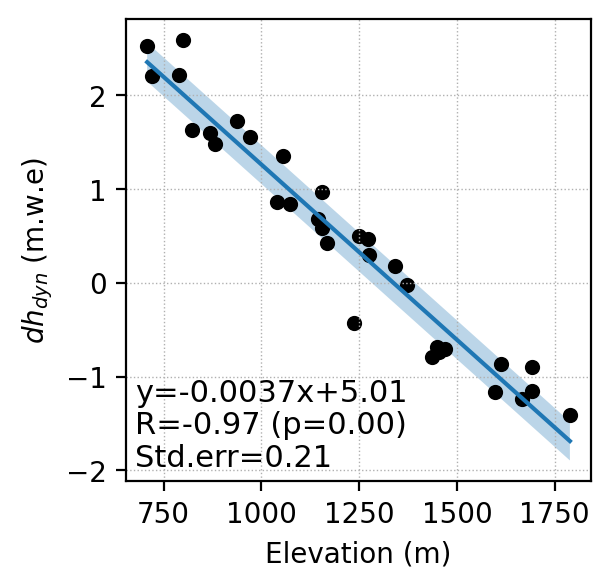

In [ ]:
xh = []
xdyn = []

for p in tqdm( dict_insitu.keys() ):
  if abs(dict_insitu2[p]['dh_dyn'][0]) >= 0:
    xh = np.append(xh, dict_insitu2[p]['h'][0])
    xdyn = np.append(xdyn, dict_insitu2[p]['dh_dyn'][0])

# xh = sorted(xh)
# xdyn = sorted(xdyn)
xdyn = -xdyn
res = stats.linregress(xh, xdyn)
a = res.slope
b = res.intercept
r = res.rvalue
p = res.pvalue
std_err = res.intercept_stderr
# sns.regplot(x = xh, y = xdyn, ci=95)

plt.subplots(1,1, dpi = 200, figsize = (3,3))
plt.scatter(xh, xdyn, color = "k", s= 20)

xs = np.linspace(xh.min(), xh.max(), 10)
plt.plot(xs, a*xs + b)

plt.fill_between(xs, a*xs + b - std_err, a*xs + b + std_err, alpha = 0.3, zorder = 0)
plt.annotate(f"y={a:.4f}x+{b:.2f}", xy=(0.02,0.16), xycoords='axes fraction', fontsize=11, ha='left', va='bottom')
plt.annotate(f"R={r:.2f} (p={p:.2f})", xy=(0.02,0.09), xycoords='axes fraction', fontsize=11, ha='left', va='bottom')
plt.annotate(f"Std.err={std_err:.2f}", xy=(0.02,0.02), xycoords='axes fraction', fontsize=11, ha='left', va='bottom')

plt.xlabel("Elevation (m)")
plt.ylabel("$dh_{dyn}$ (m.w.e)")
plt.grid(ls = ":", lw = 0.5)

In [ ]:
len(zval)

14

In [ ]:
len(np.repeat(np.array(p), len(xval)))

1210

In [ ]:
df

x       y    h  year         d1         d2  b_fld  b_str    rho  \
0   502152  462399  823  2017 2016-10-16 2017-05-01   1.02   1.02  459.0   
1   502152  462399  823  2017 2017-05-01 2017-10-05  -4.64    NaN  500.0   
2   502152  462399  818  2018 2017-10-05 2018-04-28   0.79   0.79  456.0   
3   502152  462399  818  2018 2018-04-28 2018-10-08  -3.42    NaN  500.0   
4   502152  462399  814  2019 2018-10-08 2019-04-30   0.06   0.20  481.0   
5   502152  462399  814  2019 2019-04-30 2019-11-05  -5.53    NaN  500.0   
6   502152  462399  814  2020 2019-11-05 2020-04-28   0.60   0.66  540.0   
7   502152  462399  814  2020 2020-04-28 2020-10-10  -4.73    NaN  500.0   
8   502152  462399  814  2021 2020-10-10 2021-04-29   1.04   1.08  563.0   
9   502152  462399  814  2021 2021-04-29 2021-10-21  -4.64    NaN  500.0   
10  502152  462399  814  2022 2021-10-21 2022-04-26   1.22   1.23  538.0   
11  502152  462399  814  2022 2022-04-26 2022-10-17  -4.79    NaN  500.0   
12  502152  462399  814  2023 2022-10-17 2023-04-26   0.16   0.23  464.0   
13  502152  462399  814  2023 2023-04-26 2023-10-24  -5.26    NaN  500.0   

    ba_fld  ba_str    dh_is2    dh_std  firn  dh_dyn     b_is2    h2_is2  \
0    -3.62   -3.62       NaN       NaN   0.0  -1.629       NaN       NaN   
1    -3.62   -3.62       NaN       NaN   0.0  -1.629       NaN       NaN   
2    -2.49   -2.63       NaN       NaN   0.0  -1.629       NaN  0.449743   
3    -2.49   -2.63  0.526650  1.597354   0.0  -1.629 -1.365600  0.449743   
4    -5.41   -5.33       NaN       NaN   0.0  -1.629       NaN       NaN   
5    -5.41   -5.33       NaN       NaN   0.0  -1.629       NaN  1.366972   
6    -4.09   -4.07  1.678489  1.816419   0.0  -1.629 -0.722616  3.086349   
7    -4.09   -4.07 -2.832864  1.267465   0.0  -1.629 -3.045837  0.173075   
8    -3.59   -3.56       NaN       NaN   0.0  -1.629       NaN       NaN   
9    -3.59   -3.56       NaN       NaN   0.0  -1.629       NaN -1.515818   
10   -3.50   -3.56       NaN       NaN   0.0  -1.629       NaN       NaN   
11   -3.50   -3.56       NaN       NaN   0.0  -1.629       NaN       NaN   
12   -5.10   -5.03       NaN       NaN   0.0  -1.629       NaN -1.201145   
13   -5.10   -5.03       NaN       NaN   0.0  -1.629       NaN       NaN   

         sd2    h1_is2       sd1  
0        NaN       NaN       NaN  
1        NaN       NaN       NaN  
2  -0.482312       NaN       NaN  
3   0.044338  0.449743 -0.482312  
4   0.000000  0.449743  0.044338  
5  -0.037221       NaN  0.000000  
6  -0.078109  1.366972 -0.037221  
7   0.002301  3.086349 -0.078109  
8        NaN  0.173075  0.002301  
9  -0.082457       NaN       NaN  
10       NaN -1.515818 -0.082457  
11       NaN       NaN       NaN  
12 -0.041621       NaN       NaN  
13       NaN -1.201145 -0.041621

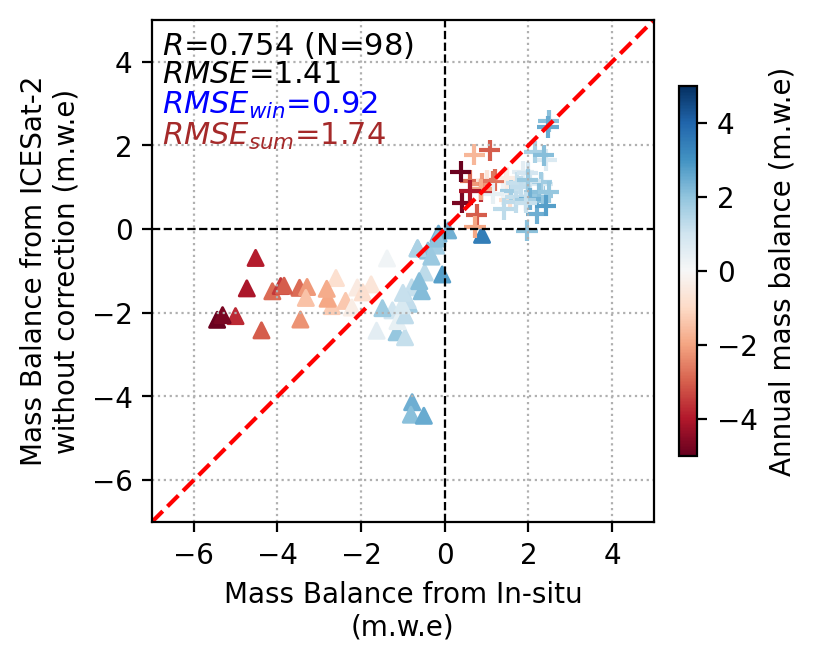

In [ ]:
from sklearn.metrics import mean_squared_error as mse

plt.subplots(1,1, dpi = 200, figsize = (4,4))
xval = []
yval = []
flags = []
names = []
times = []

y_field = 'dh_is2'
for p in dict_insitu2.keys():
  # plt.errorbar(dict_insitu2[p]['b_fld'].values, dict_insitu2[p][y_field].values, dict_insitu2[p]['dh_std'], fmt ='.', markersize = 10,
  #              color = "gray", capsize=4, alpha = 0.5, zorder = 0)
  # plt.scatter(dict_insitu2[p]['b_fld'].values, dict_insitu2[p]['dh_is2'].values, s=50, c = dict_insitu2[p]['h'], vmin = 700, vmax = 1700, marker = "+")

  df = dict_insitu2[p] #.dropna()
  df = df[df['year'] >= 2019]

  month = np.array([m.month for m in df['d2']])
  year = np.array([m.year for m in df['d2']])
  flag = np.zeros(len(month))

  idx_sum = (month > 8) & (month < 12)
  idx_win = (month > 2) & (month < 6)
  flag[idx_win] = 1

  rhos = df['rho'].values
  rhos[np.isnan(rhos)] = 500

  if y_field == 'dh_is2':
    zval = rhos/1000*(df[y_field])
  else:
    zval = df[y_field]

  # print(zval[idx_win])

  # winter mass balance
  plt.scatter(df['b_fld'][idx_win].values, zval[idx_win].values, s=60, c = df['ba_str'][idx_win],
              vmin = -5, vmax = 5, cmap= "RdBu", marker = "+")

  # summer mass balance
  plt.scatter(df['b_fld'][idx_sum].values, zval[idx_sum].values, s=30, c = df['ba_str'][idx_sum],
              vmin = -5, vmax = 5, cmap= "RdBu", marker = "^")

  xval = np.append(xval, df['b_fld'].values)
  yval = np.append(yval, zval)
  flags = np.append(flags, flag)
  names = np.append(names, np.repeat(np.array(p), len(zval)))
  times = np.append(times, year)

idx = (xval > -1000) & (yval > -1000)
rmse = mse(xval[idx], yval[idx]) ** 0.5
r = np.corrcoef(xval[idx], yval[idx])[0][1]

rmse_win = mse(xval[idx & (flags == 1)], yval[idx & (flags == 1)]) ** 0.5
rmse_sum = mse(xval[idx & (flags == 0)], yval[idx & (flags == 0)]) ** 0.5

plt.axis('scaled')
plt.axhline(0, color = "k", ls = "--", lw = 0.8)
plt.axvline(0, color = "k", ls = "--", lw = 0.8)
plt.plot([-7, 5], [-7, 5], color = "r", ls = "--")
plt.grid(ls = ":")
plt.xlim(-7, 5)
plt.ylim(-7, 5)

plt.xlabel("Mass Balance from In-situ\n(m.w.e)")

if y_field == 'dh_is2':
  plt.ylabel("Mass Balance from ICESat-2\nwithout correction (m.w.e)")
else:
  plt.ylabel("Mass Balance from ICESat-2\nwith correction (m.w.e)")

plt.annotate(f"$R$={r:.3f} (N={len(xval[idx])})", xy=(0.02,0.98), xycoords='axes fraction', fontsize=11, ha='left', va='top')
plt.annotate(f"$RMSE$={rmse:.2f}", xy=(0.02,0.92), xycoords='axes fraction', fontsize=11, ha='left', va='top')
plt.annotate("$RMSE_{win}$"+f"={rmse_win:.2f}", xy=(0.02,0.86), xycoords='axes fraction', fontsize=11, ha='left', va='top', color = "b")
plt.annotate("$RMSE_{sum}$"+f"={rmse_sum:.2f}", xy=(0.02,0.80), xycoords='axes fraction', fontsize=11, ha='left', va='top', color = "brown")
plt.colorbar(label = "Annual mass balance (m.w.e)", shrink = 0.6, pad = 0.04)

In [ ]:
keyList = []

for k in dict_insitu2.keys():
  if np.isnan(dict_insitu2[k]['b_is2'].values).all():
    pass
  else:
    keyList.append(k)

len(keyList)

25

In [ ]:
dict_insitu2.keys()

dict_keys(['h18', 'hn10', 'hn11', 'hn12', 'hn12a', 'hn13', 'hn13a', 'hn14', 'hn14a', 'hn15', 'hn15a', 'hn16', 'hn17', 'hn9v', 'hsa11', 'hsa13', 'hsa15', 'hsa16', 'hsa17', 'hsa7', 'hsa9', 'hsv11', 'hsv13', 'hsv15', 'hsv17', 'hsv8', 'hn12v', 'hn10v', 'hsa7v', 'hsa8', 'blt11', 'blt8'])

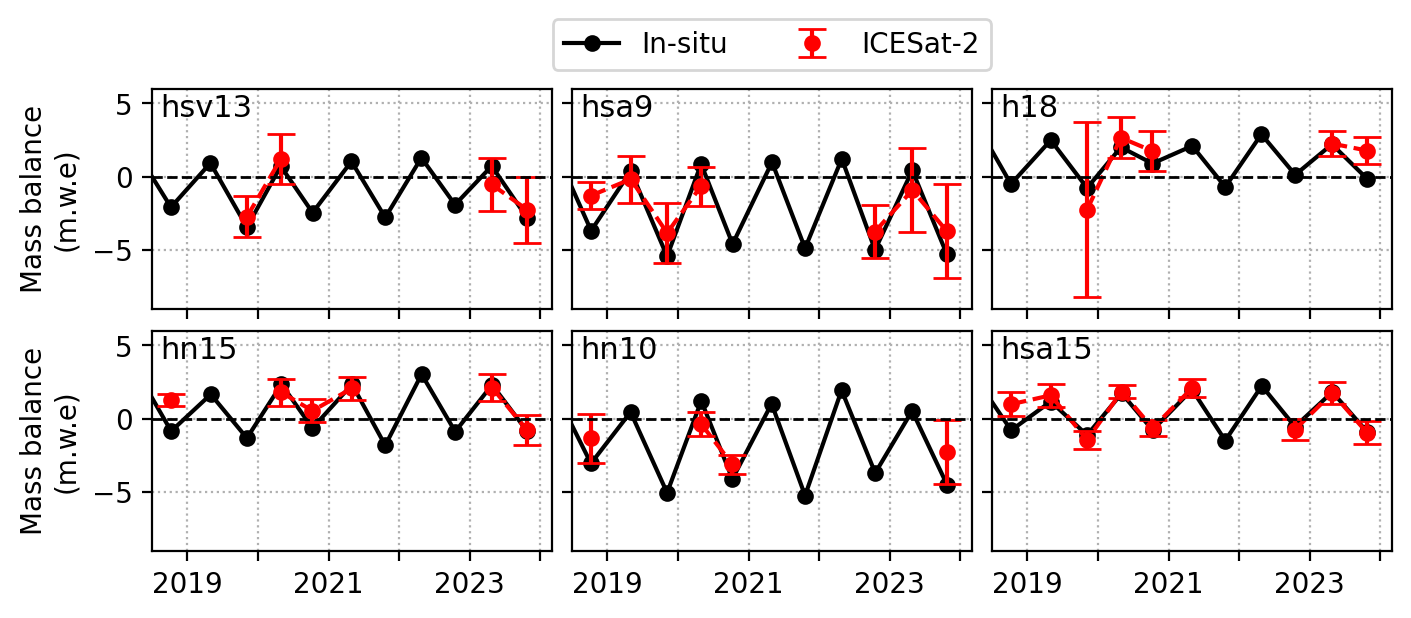

In [ ]:
plotList = ['hsv13', 'hn15', 'hsa9', 'hn10', 'h18', 'hsa15']
#['hn14', 'hn16', 'h18', 'hsa13', 'hsa15', 'hsa11', 'hsa16', 'hsv15', 'hsa9']

N = len(plotList)
fig, ax = plt.subplots(2,3, figsize = (8,3), dpi = 200, sharex = True, sharey= True)
fig.subplots_adjust(wspace = 0.05, hspace = 0.1)

df_compare = pd.DataFrame()

k = 0

for n, site in enumerate(plotList[:]):

  i = n % ax.shape[0]
  j = n // ax.shape[0]

  # print(i, j, n, site)

  df = dict_insitu2[site]

  ax[i,j].plot(df['d2'], df['b_fld'], color = "k", marker = "o", label = "In-situ", markersize = 5)

  df1 = dict_insitu2[site]
  y_field = 'b_is2'
  if len(df1) > 0:
    df1.loc[abs(df1['b_fld']) > 10, 'b_fld'] = np.nan
    ax[i,j].plot(df1['d2'], df1[y_field], color = "r", ls = "--")
    ax[i,j].errorbar(df1['d2'], df1[y_field], df1['dh_std'], fmt ='.', markersize = 10, color = "r", capsize=5, label = "ICESat-2")

  # if len(df2) > 0:
  #   df2.loc[abs(df2['h_balance']) > 10, 'h_balance'] = np.nan
  #   ax[i,j].plot(df2['date'], df2['h_balance'], color = "b", ls = "--")
  #   ax[i,j].errorbar(df2['date'], df2['h_balance'], df2['h_std'], fmt ='.', markersize = 10, color = "b", capsize=4, label = "ICESat")

  # if len(df3) > 0:
  #   df3.loc[abs(df3['h_balance']) > 10, 'h_balance'] = np.nan
  #   ax[i,j].plot(df3['date'], df3['h_balance'], color = "g", ls = "--")
  #   ax[i,j].errorbar(df3['date'], df3['h_balance'], df3['h_std']*0, fmt ='.', markersize = 10, color = "g", capsize=4, label = "CryoSat-2")

  ax[i,j].annotate(site, xy=(0.02,0.98), xycoords='axes fraction', fontsize=11, ha='left', va='top')
  ax[i,j].set_ylim(-9, 6)
  ax[i,j].grid(ls = ":")


  ax[i,j].axhline(0, color = "k", ls = "--", lw = 1)

  ax[i,j].set_xlim(datetime(2018, 7, 1), datetime(2024, 3, 1))
  # ax.fill(df2['date'], df2['h_balance'], color = "r")
  ax[i,j].set_xticks([datetime(2019, 1, 1), datetime(2020, 1, 1), datetime(2021, 1, 1),  datetime(2022, 1, 1), datetime(2023, 1, 1), datetime(2024, 1, 1)],
   [2019, "", 2021, "", 2023, ""])

  if j == 0:
    ax[i,j].set_ylabel("Mass balance\n(m.w.e)")

ax[0,1].legend(fontsize = 10, ncol = 2, bbox_to_anchor = (0.5, 1.2), loc = "center")


# plt.plot(dict_insitu2[p]['d2'], dict_insitu2[p]['b_fld'])
# plt.plot(dict_insitu2[p]['d2'], dict_insitu2[p]['b_is2'])
# plt.xlim(datetime(2018, 10, 1), datetime(2024,1,1))

In [ ]:
track = ee.FeatureCollection("projects/ee-kooala317/assets/West_IS2_laser7")

tracks = gpd.GeoDataFrame()

for n_track in n_tracks:
  print(n_track)
  track0 = track.filter(ee.Filter.eq('Name', str(int(n_track))))
  track1 = geemap.ee_to_gdf(track0).to_crs(3057)
  tracks = pd.concat([tracks, track1])

1236
0352
0497
0794
1297
1000
0939
0055
0558


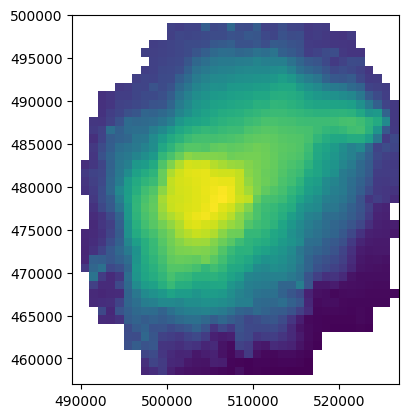

<Axes: >

In [ ]:
import rasterio
from rasterio.plot import show

# from matplotlib import pyplot
src = rasterio.open("drive/MyDrive/iceland_oct2020_low.tif")
show(src)

In [ ]:
files = glob.glob(f"drive/MyDrive/Colab Notebooks/Iceland/Data_glacier/SR_glacier_rgt*.csv")
n_tracks = []
for f in files:
  n_track = str(int(f.split("_rgt")[1][:4]))
  if n_track not in n_tracks:
    n_tracks.append(n_track)

tracks2 = gpd.GeoDataFrame()
for n_track in n_tracks:
  tracks0 = tracks[tracks['Name'] == n_track]
  tracks2 = pd.concat([tracks2, tracks0])

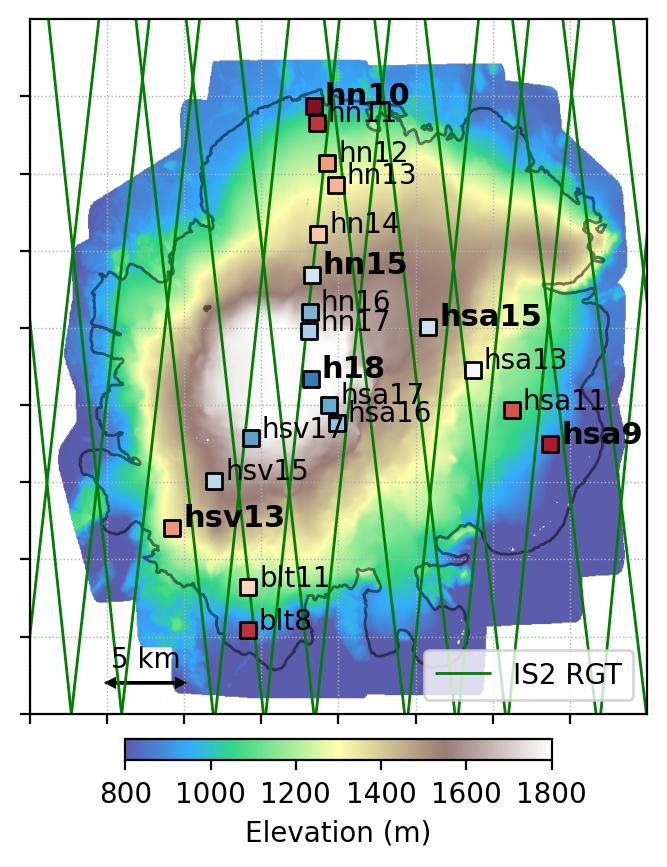

In [ ]:
from rasterio.plot import show
fig, ax = plt.subplots(1,1,figsize = (5.5, 5.5), dpi = 200)

# # create the colorbar
# norm = colors.Normalize(vmin=-5, vmax=5)
# cbar = plt.cm.ScalarMappable(norm=divnorm, cmap='gist_earth_r')

shapefile.boundary.plot(ax = ax, color = "k", lw = 1, alpha = 0.5)
# gdf.plot("h_diff", ax = ax, vmin = -5, vmax = 5, cmap = "RdBu", markersize = 50, edgecolors='black', marker = "s", label = "In-situ")
# gdf_out['bs_is2'] = gdf_out['h_mean_sum'] - gdf_out['h_mean_win']
# gdf_out['bw_is2'] = gdf_out['h_mean_win'] - gdf_out['h_mean_sum']

for n, site in enumerate(keyList[:]):
  df = dict_insitu2[site]
  ax.scatter(df['x'][0], df['y'][0], c = df['ba_str'][0], vmin = -5, vmax = 5, cmap = "RdBu", zorder = 10, s = 30, edgecolors='black', marker = "s")
  if site in plotList:
    ax.text(df['x'][0]+700, df['y'][0]+100, site, zorder = 10, fontsize = 11, weight = "bold") # , weight = "bold"
  else:
    ax.text(df['x'][0]+700, df['y'][0]+100, site, zorder = 10)

tracks.plot(ax = ax, color = "g", lw = 1, label = "IS2 RGT")

# for n_track in n_tracks:
#   tracks0 = tracks[tracks['Name'] == n_track]
#   tracks0.plot('Name', ax = ax, label=n_track, color = "g", lw = 1)
# gdf_out.plot("bw_str", ax = ax, vmin = -5, vmax = 5, cmap = "RdBu", markersize = 50, edgecolors='black', marker = "s", label = "In-situ")

# points = ["hn10", "hn11", "hn12", "hn13", "hn14", "hn15", "hn16", "hn17", "h18"]
# for i in range(0, len(gdf_insitu)):
#   plt.text(gdf_insitu.loc[i, "x"]+500, gdf_insitu.loc[i, "y"]+100, gdf_insitu.loc[i, "#stake"])

# from matplotlib import pyplot
src = rasterio.open("drive/MyDrive/iceland_oct2020_50.tif")
cbar = show(src, cmap = "terrain", ax = ax, alpha = 0.8, vmin = 800, vmax = 1800)

ax.legend(loc = "lower right")
plt.axis('scaled')
# ax.title(f"{y} {season.upper()}")

x1, x2 = ax.set_xlim(488000, 528000)
y1, y2 = ax.set_ylim(457000, 502000)
ax.set_yticks(np.arange(y1, y2, 5000), [])
ax.set_xticks(np.arange(x1, x2, 5000), [])
ax.grid(ls = ":", lw = 0.5)

im = cbar.get_images()[0]
fig.colorbar(im, shrink = 0.5, label = "Elevation (m)", pad= 0.03, orientation = 'horizontal')

# SCale bar
plt.annotate("5 km", xy=(488000 + 7500, 457000+3000), fontsize = 10, ha = "center")
ax.arrow(488000 + 5000, 457000+2000, 5000, 0, color='k', head_length = 500, head_width = 500, length_includes_head = True)
ax.arrow(488000 + 10000, 457000+2000, -5000, 0, color='k', head_length = 500, head_width = 500, length_includes_head = True)

In [ ]:
print(np.unique(df1['rgt']))

df2 = pd.read_csv(file2, index_col = 0)
print(np.unique(df2['rgt']))

[ 352  497  794 1000]
[  55  497  794 1000 1297]


# DEM comparison for repeating track

In [ ]:
file1 = f"drive/MyDrive/Colab Notebooks/Iceland/Data_glacier/SR_glacier_2020_aut.csv"
file2 = f"drive/MyDrive/Colab Notebooks/Iceland/Data_glacier/SR_glacier_2023_aut.csv"

h_th = 20
rgt = 794 # 497, 794, 1000

df1 = pd.read_csv(file1, index_col = 0)
df1 = df1[df1['mean'] > 0].reset_index(drop = True)
gdf1 = gpd.GeoDataFrame(df1, geometry=gpd.points_from_xy(df1.lon, df1.lat), crs="EPSG:4326").to_crs(3057)
gdf1 = gdf1[(abs(gdf1['h_diff']) < h_th) & (gdf1['rgt'] == rgt)].reset_index(drop = True)
gdf1['date'] = gdf1['year']*10000 + gdf1['month']*100 + gdf1['day']

gdf1['x'] = gdf1['geometry'].x
gdf1['y'] = gdf1['geometry'].y

print(pd.unique(gdf1['rgt']))

df2 = pd.read_csv(file2, index_col = 0)
df2 = df2[(df2['mean'] > 0) & (df2['rgt'] == rgt)].reset_index(drop = True)
gdf2 = gpd.GeoDataFrame(df2, geometry=gpd.points_from_xy(df2.lon, df2.lat), crs="EPSG:4326").to_crs(3057)

gdf_fc = geemap.geopandas_to_ee(gdf2.loc[:, ['year', 'month', 'day', 'y_atc', 'x_atc', 'h_mean', 'h_sigma', 'gt', 'rgt', 'lat', 'lon', 'geometry']])

fc_samp = DEM2023.reduceRegions(collection=gdf_fc, reducer=ee.Reducer.mean(), scale=20)
df2 = geemap.ee_to_df(fc_samp)
df2['h_diff'] = df2['h_mean'] - df2['mean']

gdf2 = gpd.GeoDataFrame(df2, geometry=gpd.points_from_xy(df2.lon, df2.lat), crs="EPSG:4326").to_crs(3057)

gdf2 = gdf2[(abs(gdf2['h_diff']) < h_th) & (gdf2['rgt'] == rgt)].reset_index(drop = True)
gdf2['date'] = gdf2['year']*10000 + gdf1['month']*100 + gdf1['day']

gdf2['x'] = gdf2['geometry'].x
gdf2['y'] = gdf2['geometry'].y

print(pd.unique(gdf2['rgt']))

[794]
[794]


Text(0.5, 0, 'ICESat-2 - DEM height (m)')

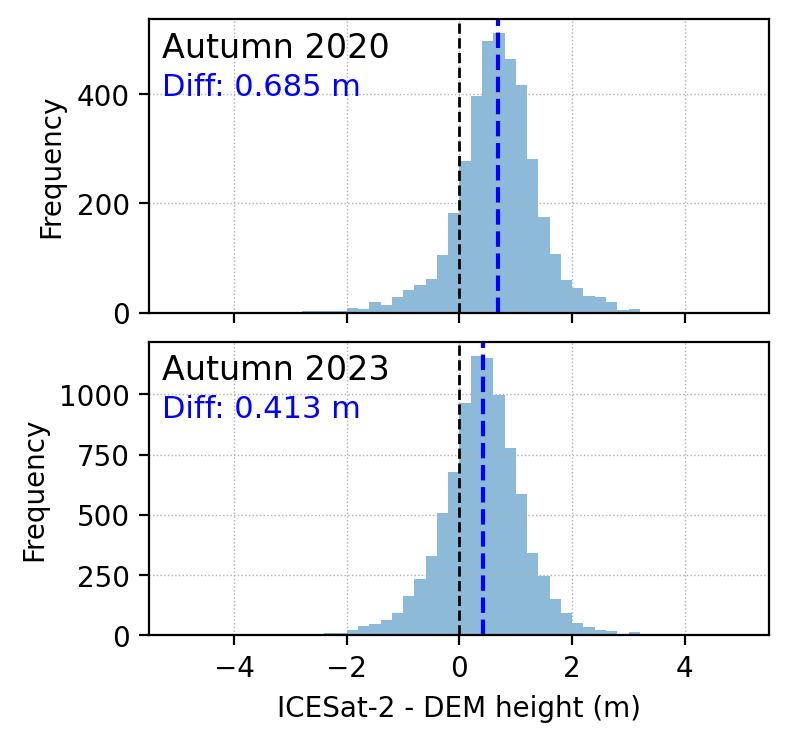

In [ ]:
fig, ax = plt.subplots(2, 1, figsize = (4,4), dpi = 200, sharex = True)
fig.subplots_adjust(wspace = 0.05, hspace = 0.1)

ax[0].hist(gdf1['h_diff'], range = (-5, 5), bins = 50, alpha = 0.5);
ax[0].axvline(gdf1['h_diff'].median(), color = "b", ls = "--")
ax[0].axvline(0, color = "k", ls = "--", lw = 1)
ax[0].grid(ls = ":", lw = 0.5, zorder = 0)
ax[0].set_ylabel("Frequency")
ax[0].annotate(f"Autumn 2020", xy=(0.02, 0.96), xycoords='axes fraction', fontsize=12, ha='left', va='top', color = "k")
ax[0].annotate(f"Diff: {gdf1['h_diff'].median():.3f} m", xy=(0.02, 0.82), xycoords='axes fraction', fontsize=11, ha='left', va='top', color = "b")

ax[1].hist(gdf2['h_diff'], range = (-5, 5), bins = 50, alpha = 0.5);
ax[1].axvline(gdf2['h_diff'].median(), color = "b", ls = "--")
ax[1].axvline(0, color = "k", ls = "--", lw = 1)
ax[1].grid(ls = ":", lw = 0.5, zorder = 0)
ax[1].set_ylabel("Frequency")
ax[1].annotate(f"Autumn 2023", xy=(0.02, 0.96), xycoords='axes fraction', fontsize=12, ha='left', va='top', color = "k")
ax[1].annotate(f"Diff: {gdf2['h_diff'].median():.3f} m", xy=(0.02, 0.82), xycoords='axes fraction', fontsize=11, ha='left', va='top', color = "b")

ax[1].set_xlabel("ICESat-2 - DEM height (m)")

Text(0.5, 0, 'Along-track distance (km)')

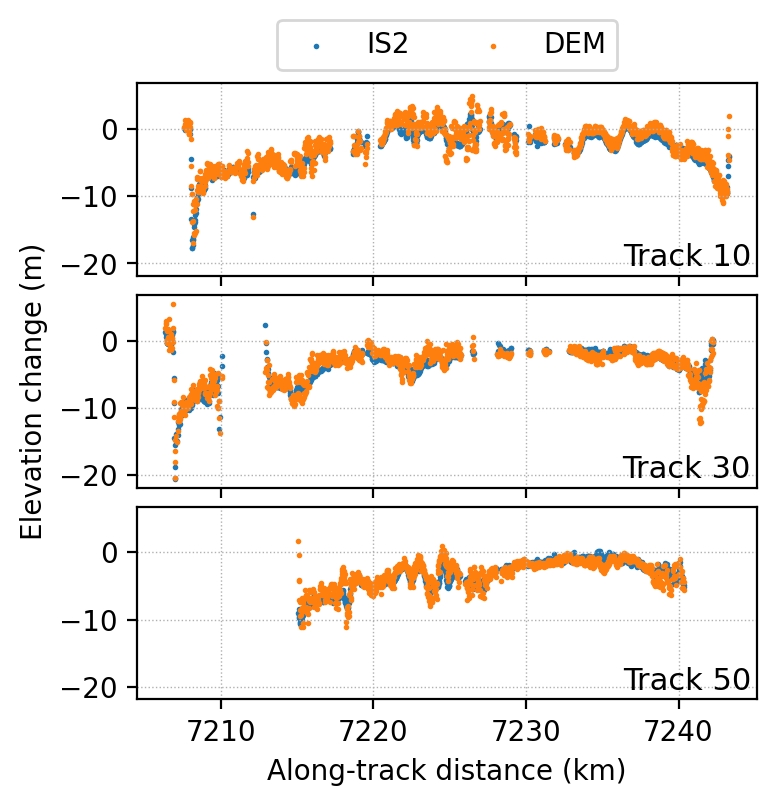

In [ ]:
from scipy.interpolate import interp1d

gts = [10, 30, 50]

fig, ax = plt.subplots(len(gts), 1, figsize = (4,4), dpi = 200, sharex = True, sharey = True)
fig.subplots_adjust(wspace = 0.05, hspace = 0.1)

for i, gt in enumerate(gts):

  xp2 = gdf2.loc[gdf2['gt'] == gt, 'x_atc'].values
  yp2 = gdf2.loc[gdf2['gt'] == gt, 'h_mean'].values
  ydem2 = gdf2.loc[gdf2['gt'] == gt, 'mean'].values

  y_interp2 = interp1d(xp2, yp2, fill_value=(-10, 10), bounds_error=False)
  y_interdem2 = interp1d(xp2, ydem2, fill_value=(-10, 10), bounds_error=False)

  xp1 = gdf1.loc[gdf1['gt'] == gt, 'x_atc'].values
  yp1 = gdf1.loc[gdf1['gt'] == gt, 'h_mean'].values
  ydem1 = gdf1.loc[gdf1['gt'] == gt, 'mean'].values

  y_interp1 = interp1d(xp1, yp1, fill_value=(-10, 10), bounds_error=False)
  y_interdem1 = interp1d(xp1, ydem1, fill_value=(-10, 10), bounds_error=False)

  xs = xp1.copy() #np.arange(xp1.min(), xp2.max(), 20)

  for j in range(0, len(xs)):
    if abs(xs[j] - xp2).min() > 20:
      xs[j] = np.nan

  # xs = xs[xs > 0]

  ys1 = y_interp1(xs)
  ys2 = y_interp2(xs)

  ysd2 = y_interdem2(xs)
  ysd1 = y_interdem1(xs)

  gdf1.loc[gdf1['gt'] == gt, 'h_mean2'] = ys2
  gdf1.loc[gdf1['gt'] == gt, 'h_mean1'] = ys1
  gdf1.loc[gdf1['gt'] == gt, 'h_dem2'] = ysd2
  gdf1.loc[gdf1['gt'] == gt, 'h_dem1'] = ysd1

  gdf1.loc[gdf1['gt'] == gt, 'diff_dem'] = ysd2 - ysd1
  gdf1.loc[gdf1['gt'] == gt, 'diff_is2'] = ys2 - ys1
  gdf1[gdf1['diff_is2'] < -100] = np.nan

  # ax[i].scatter(xp1, yp1, s= 1)
  # ax[i].scatter(xp2, yp2, s= 1)

  # ax[i].scatter(xs, ys1, s= 2)
  ax[i].scatter(xs/1000, ys2 - ys1, s= 1, label = "IS2")
  ax[i].scatter(xs/1000, ysd2 - ysd1, s= 1, label = "DEM")
  ax[i].grid(ls = ":", lw = 0.5)

  ax[i].annotate(f"Track {gt}", xy=(0.99,0.02), xycoords='axes fraction', fontsize=11, ha='right', va='bottom', color = "k")
  # ax[i].set_ylim(-15, 5)

  # ax[i].plot(xs, ys2 - ys1)
  # ax[i].plot(xs, ysd2 - ysd1)

gdf1 = gdf1.dropna()
ax[0].legend(fontsize = 10, ncol = 2, bbox_to_anchor = (0.5, 1.2), loc = "center")
ax[1].set_ylabel("Elevation change (m)")
ax[len(gts)-1].set_xlabel("Along-track distance (km)")

Text(0.02, 0.82, '(N=3870)')

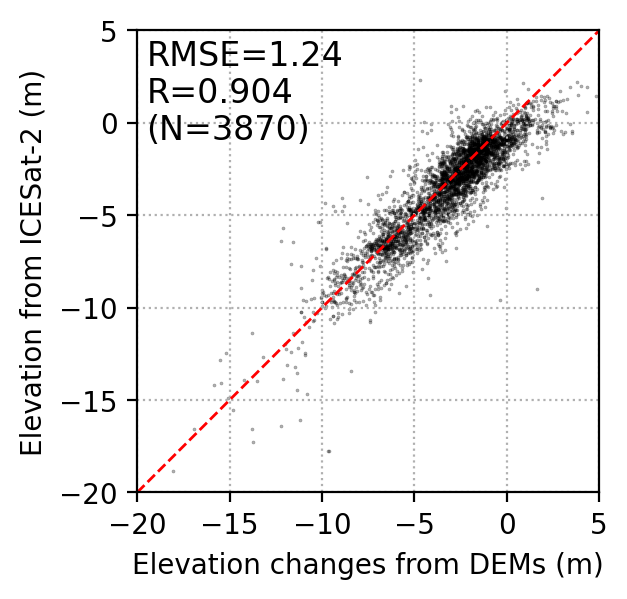

In [ ]:
xval = gdf1['diff_dem']
yval = gdf1['diff_is2']
idx = (abs(xval) > 0) & (abs(yval) > 0)

fig, ax = plt.subplots(1,1, figsize = (3,3), dpi = 200)
rmse = mse(xval[idx], yval[idx]) ** 0.5
r = np.corrcoef(xval[idx], yval[idx])[0][1]

# cbar = plt.hist2d(xval[idx], yval[idx], bins = 200, vmax = 10, cmap = "binary")
plt.scatter(gdf1['diff_dem'], gdf1['diff_is2'], c = "k", s= 5, marker = ".", lw = 0.2, alpha = 0.3)

plt.axis('scaled')
# plt.axhline(0, color = "k", ls = "--", lw = 0.5)
# plt.axvline(0, color = "k", ls = "--", lw = 0.5)
ranges = [-20, 5]
plt.plot(ranges, ranges, color = "r", ls = "--", lw = 1)
plt.grid(ls = ":")
plt.xlim(ranges)
plt.ylim(ranges)

plt.xlabel("Elevation changes from DEMs (m)")
plt.ylabel("Elevation from ICESat-2 (m)")

plt.annotate(f"RMSE={rmse:.2f}", xy=(0.02,0.98), xycoords='axes fraction', fontsize=12, ha='left', va='top', color = "k")
plt.annotate(f"R={r:.3f}", xy=(0.02,0.90), xycoords='axes fraction', fontsize=12, ha='left', va='top', color = "k")
plt.annotate(f"(N={len(xval[idx])})", xy=(0.02,0.82), xycoords='axes fraction', fontsize=12, ha='left', va='top', color = "k")
# fig.colorbar(cbar[3], label = "dh dyn", shrink = 0.6)
# fig.colorbar(cbar[3], ax=ax, shrink = 0.6, label = "Frequency", extend = "max")

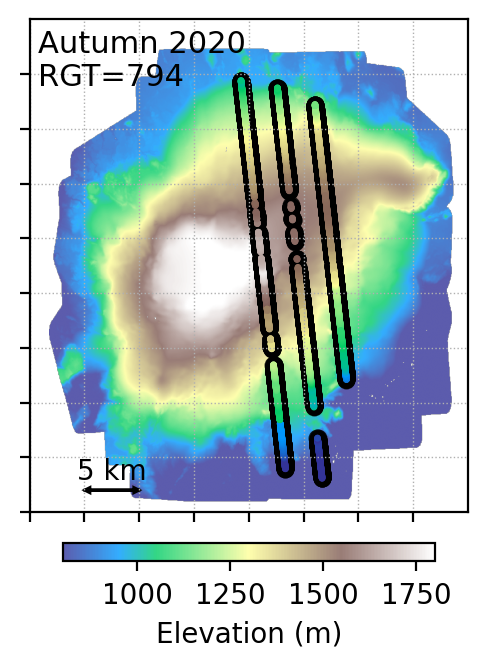

In [ ]:
fig, ax = plt.subplots(1,1,figsize = (4,4), dpi = 200)

gdf1.plot(c = "k", ax = ax, markersize = 30, alpha = 0.8)
gdf1.plot("h_mean", ax = ax, vmin = 800, vmax = 1800, cmap = "terrain", markersize = 2)

# from matplotlib import pyplot
src = rasterio.open("drive/MyDrive/iceland_oct2020_50.tif")
cbar = show(src, cmap = "terrain", ax = ax, alpha = 0.8, vmin = 800, vmax = 1800)

# ax.legend()
plt.axis('scaled')
# ax.title(f"{y} {season.upper()}")

x1, x2 = ax.set_xlim(488000, 528000)
y1, y2 = ax.set_ylim(457000, 502000)
ax.set_yticks(np.arange(y1, y2, 5000), [])
ax.set_xticks(np.arange(x1, x2, 5000), [])
ax.grid(ls = ":", lw = 0.5)

plt.annotate(f"Autumn 2020\nRGT={rgt}", xy=(0.02,0.98), xycoords='axes fraction', fontsize=11, ha='left', va='top', color = "k")

im = cbar.get_images()[0]
fig.colorbar(im, shrink = 0.6, label = "Elevation (m)", orientation = 'horizontal', pad = 0.05)

# SCale bar
plt.annotate("5 km", xy=(488000 + 7500, 457000+3000), fontsize = 10, ha = "center")
ax.arrow(488000 + 5000, 457000+2000, 5000, 0, color='k', head_length = 500, head_width = 500, length_includes_head = True)
ax.arrow(488000 + 10000, 457000+2000, -5000, 0, color='k', head_length = 500, head_width = 500, length_includes_head = True)

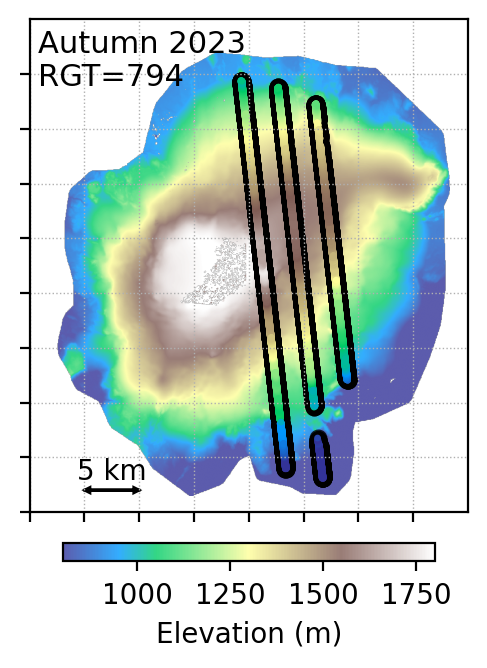

In [ ]:
fig, ax = plt.subplots(1,1,figsize = (4,4), dpi = 200)

gdf2.plot(c = "k", ax = ax, markersize = 30, alpha = 0.8)
gdf2.plot("h_mean", ax = ax, vmin = 800, vmax = 1800, cmap = "terrain", markersize = 2)

# from matplotlib import pyplot
src = rasterio.open("drive/MyDrive/iceland_oct2023_50.tif")
cbar = show(src, cmap = "terrain", ax = ax, alpha = 0.8, vmin = 800, vmax = 1800)

# ax.legend()
plt.axis('scaled')
# ax.title(f"{y} {season.upper()}")

x1, x2 = ax.set_xlim(488000, 528000)
y1, y2 = ax.set_ylim(457000, 502000)
ax.set_yticks(np.arange(y1, y2, 5000), [])
ax.set_xticks(np.arange(x1, x2, 5000), [])
ax.grid(ls = ":", lw = 0.5)

plt.annotate(f"Autumn 2023\nRGT={rgt}", xy=(0.02,0.98), xycoords='axes fraction', fontsize=11, ha='left', va='top', color = "k")

im = cbar.get_images()[0]
fig.colorbar(im, shrink = 0.6, label = "Elevation (m)", orientation = 'horizontal', pad = 0.05)

# SCale bar
plt.annotate("5 km", xy=(488000 + 7500, 457000+3000), fontsize = 10, ha = "center")
ax.arrow(488000 + 5000, 457000+2000, 5000, 0, color='k', head_length = 500, head_width = 500, length_includes_head = True)
ax.arrow(488000 + 10000, 457000+2000, -5000, 0, color='k', head_length = 500, head_width = 500, length_includes_head = True)

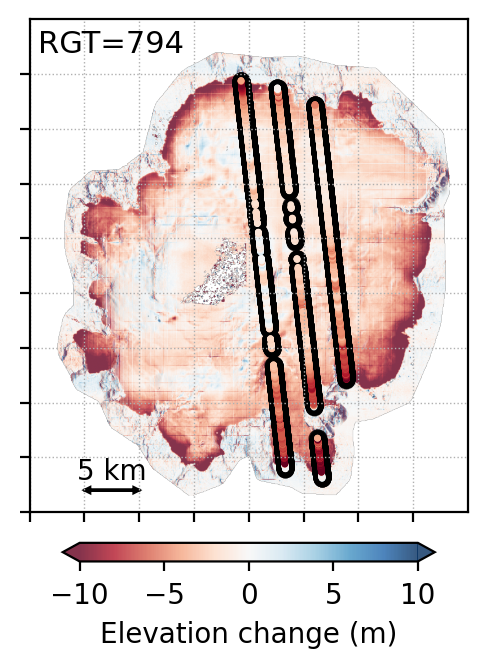

In [ ]:
fig, ax = plt.subplots(1,1,figsize = (4,4), dpi = 200)

gdf1.plot(c = "k", ax = ax, markersize = 30, alpha = 0.8)
gdf1.plot("diff_is2", ax = ax, vmin = -10, vmax = 10, cmap = "RdBu", markersize = 2)

# from matplotlib import pyplot
src = rasterio.open("drive/MyDrive/iceland_diff_50.tif")
cbar = show(src, cmap = "RdBu", vmin = -10, vmax = 10, ax = ax, alpha = 0.8)

# ax.legend()
plt.axis('scaled')
# ax.title(f"{y} {season.upper()}")

x1, x2 = ax.set_xlim(488000, 528000)
y1, y2 = ax.set_ylim(457000, 502000)
ax.set_yticks(np.arange(y1, y2, 5000), [])
ax.set_xticks(np.arange(x1, x2, 5000), [])
ax.grid(ls = ":", lw = 0.5)

plt.annotate(f"RGT={rgt}", xy=(0.02,0.98), xycoords='axes fraction', fontsize=11, ha='left', va='top', color = "k")

im = cbar.get_images()[0]
fig.colorbar(im, shrink = 0.6, label = "Elevation change (m)", orientation = 'horizontal', pad = 0.05, extend = "both")

# SCale bar
plt.annotate("5 km", xy=(488000 + 7500, 457000+3000), fontsize = 10, ha = "center")
ax.arrow(488000 + 5000, 457000+2000, 5000, 0, color='k', head_length = 500, head_width = 500, length_includes_head = True)
ax.arrow(488000 + 10000, 457000+2000, -5000, 0, color='k', head_length = 500, head_width = 500, length_includes_head = True)

# Glacier-wide mass balance

In [ ]:
files = glob.glob(f"drive/MyDrive/Colab Notebooks/Iceland/Data_glacier/SR_glacier_rgt*.csv")
n_tracks = []
for f in files:
  n_track = str(int(f.split("_rgt")[1][:4]))
  if n_track not in n_tracks:
    n_tracks.append(n_track)

# tracks2 = gpd.GeoDataFrame()
# for n_track in n_tracks:
#   tracks0 = tracks[tracks['Name'] == n_track]
#   tracks2 = pd.concat([tracks2, tracks0])

In [ ]:
from scipy.interpolate import interp1d
from pyproj import Proj, transform

def get_firn(df):
  return df


def get_dhdyn(df, h_field = "h"):

  a = 0.004584208473991501
  b = -6.20352769584232

  df['dh_dyn'] = a*df[h_field] + b

  return df

def interpolate_track(f1, f2):

  f3 = f1.copy()

  gts = [10, 20, 30, 40, 50, 60]

  for i, gt in enumerate(gts):

    idx1 = (f1['gt'] == gt)
    idx2 = (f2['gt'] == gt)

    if len(f1[idx1]) > 0 and len(f2[idx2]) > 0:

      xp2 = f2.loc[idx2, 'x_atc'].values
      yp2 = f2.loc[idx2, 'h_mean'].values

      y_interp2 = interp1d(xp2, yp2, fill_value=(-10, 10), bounds_error=False)

      xp1 = f1.loc[idx1, 'x_atc'].values
      yp1 = f1.loc[idx1, 'h_mean'].values

      y_interp1 = interp1d(xp1, yp1, fill_value=(-10, 10), bounds_error=False)

      xs = xp1.copy() #np.arange(xp1.min(), xp2.max(), 20)

      for j in range(0, len(xs)):
        if abs(xs[j] - xp2).min() > 20:
          xs[j] = np.nan

      ys1 = y_interp1(xs)
      ys2 = y_interp2(xs)

      f3.loc[idx1, 'h_mean2'] = ys2
      f3.loc[idx1, 'h_mean1'] = ys1

      f3.loc[idx1, 'diff_is2'] = ys2 - ys1
      f3[abs(f3['diff_is2']) > 10] = np.nan

  return f3

def convert_to_gdf(df1):
  df1 = df1[df1['mean'] > 0].reset_index(drop = True)
  gdf1 = gpd.GeoDataFrame(df1, geometry=gpd.points_from_xy(df1.lon, df1.lat), crs="EPSG:4326").to_crs(3057)
  gdf1 = gdf1[abs(gdf1['h_diff']) < 20].reset_index(drop = True)
  gdf1['x'] = gdf1['geometry'].x
  gdf1['y'] = gdf1['geometry'].y
  return gdf1

def compare_grid(gdf_grid, gdf, h_field = 'h_diff', buf = 5000, points = None):
  # Calculate ICESat-2 measurements within the buffer distance from insitu points
  gdf_out = gdf_grid.copy() #[['x', 'y', 'd1', 'd2', 'd3', 'bw_str', 'bs_str', 'ba_str', 'bw_fld', 'bs_fld', 'ba_fld']]

  for i in range(0, len(gdf_out)):
    x = gdf_out.loc[i, "x"]
    y = gdf_out.loc[i, "y"]

    gdf_part = gdf[(abs(gdf["x"] - x) < buf) & (abs(gdf["y"] - y) < buf)]
    N = len(gdf_part)

    if N > 5:
      gdf_out.loc[i, f"h_mean"] = gdf_part[h_field].median()
      gdf_out.loc[i, f"h_std"] = gdf_part[h_field].std()
    else:
      gdf_out.loc[i, f"h_mean"] = np.nan
      gdf_out.loc[i, f"h_std"] = np.nan

  return gdf_out

In [ ]:
# Track by track - SUMMER
spacing = 500
res = spacing

xp = np.arange(490000, 530000, spacing)
yp = np.arange(460000, 500000, spacing)

x_len = len(xp)
y_len = len(yp)

xp, yp = np.meshgrid(xp, yp)

df_grid = pd.DataFrame({'x': xp.flatten(), 'y': yp.flatten()})
gdf_grid = gpd.GeoDataFrame(df_grid, geometry=gpd.points_from_xy(df_grid.x, df_grid.y), crs="EPSG:3057")

years = range(2019, 2025)
dh_sum = np.zeros([len(years), xp.shape[0], xp.shape[1]])
h_sum = np.zeros([len(years), xp.shape[0], xp.shape[1]])
gdf_sum = []

for i, year in enumerate(years):
  # df1 = pd.read_csv(f"drive/MyDrive/Colab Notebooks/Iceland/Data_glacier/SR_glacier_{year}_win.csv")
  df1 = pd.read_csv(f"drive/MyDrive/Colab Notebooks/Iceland/Data_glacier/SR_glacier_{year}_spr.csv", index_col=0)
  df2 = pd.read_csv(f"drive/MyDrive/Colab Notebooks/Iceland/Data_glacier/SR_glacier_{year}_sum.csv", index_col=0)
  df3 = pd.read_csv(f"drive/MyDrive/Colab Notebooks/Iceland/Data_glacier/SR_glacier_{year}_aut.csv", index_col=0)
  # df5 = pd.read_csv(f"drive/MyDrive/Colab Notebooks/Iceland/Data_glacier/SR_glacier_{year+1}_win.csv")

  gdf1 = convert_to_gdf(df1)
  gdf2 = convert_to_gdf(df2)
  gdf3 = convert_to_gdf(df3)

  gdf_sum0 = gpd.GeoDataFrame()

  # Winter mass balance
  bw = np.zeros([len(n_tracks), xp.shape[0], xp.shape[1]]) * np.nan
  el = np.zeros([len(n_tracks), xp.shape[0], xp.shape[1]]) * np.nan
  for k, n_track in enumerate(n_tracks):
    n = int(n_track)

    gdf1n = gdf1[gdf1['rgt'] == n].reset_index(drop = True).copy()
    gdf2n = gdf2[gdf2['rgt'] == n].reset_index(drop = True).copy()
    gdf3n = gdf3[gdf3['rgt'] == n].reset_index(drop = True).copy()

    bw0 = np.zeros([3, xp.shape[0], xp.shape[1]]) * np.nan
    el0 = np.zeros([3, xp.shape[0], xp.shape[1]]) * np.nan
    N_th = 80

    if len(gdf1n) > N_th and len(gdf3n) > N_th:

      gdf_target = interpolate_track(gdf1n, gdf3n).dropna()
      if len(gdf_target) > N_th:
        # Height difference
        gdf_out1 = compare_grid(gdf_grid, gdf_target, 'diff_is2', buf = res)
        grid_mean = gdf_out1['h_mean'].values.reshape(np.shape(xp))
        bw0[0] = grid_mean
        # Height
        gdf_out2 = compare_grid(gdf_grid, gdf_target, 'h_mean1', buf = res)
        grid_mean2 = gdf_out2['h_mean'].values.reshape(np.shape(xp))
        el0[0] = grid_mean2

        gdf_sum0 = pd.concat([gdf_sum0, gdf_target]).reset_index(drop = True)

    if len(gdf1n) > N_th and len(gdf2n) > N_th:

      gdf_target = interpolate_track(gdf1n, gdf2n).dropna()
      if len(gdf_target) > N_th:
        # Height didfference
        gdf_out1 = compare_grid(gdf_grid, gdf_target, 'diff_is2', buf = res)
        grid_mean = gdf_out1['h_mean'].values.reshape(np.shape(xp)) * 2
        bw0[1] = grid_mean
        # Height
        gdf_out2 = compare_grid(gdf_grid, gdf_target, 'h_mean1', buf = res)
        grid_mean2 = gdf_out2['h_mean'].values.reshape(np.shape(xp))
        el0[1] = grid_mean2

        gdf_sum0 = pd.concat([gdf_sum0, gdf_target]).reset_index(drop = True)
        # bw0 = np.where(np.isnan(bw0), grid_mean, np.nan) #grid_mean[np.isnan(bw0)]

    if len(gdf2n) > N_th and len(gdf3n) > N_th:

      gdf_target = interpolate_track(gdf2n, gdf3n).dropna()

      if len(gdf_target) > N_th:
        # Height difference
        gdf_out1 = compare_grid(gdf_grid, gdf_target, 'diff_is2', buf = res)
        grid_mean = gdf_out1['h_mean'].values.reshape(np.shape(xp)) * 2
        bw0[2] = grid_mean
        # Height
        gdf_out2 = compare_grid(gdf_grid, gdf_target, 'h_mean1', buf = res)
        grid_mean2 = gdf_out2['h_mean'].values.reshape(np.shape(xp))
        el0[2] = grid_mean2

        gdf_sum0 = pd.concat([gdf_sum0, gdf_target]).reset_index(drop = True)
        # bw0 = np.where(np.isnan(bw0), grid_mean, np.nan) #grid_mean[np.isnan(bw0)]

    bw[k] = np.nanmedian(bw0, axis = 0)
    el[k] = np.nanmedian(el0, axis = 0)

  dh_sum[i] = np.nanmedian(bw, axis = 0)
  h_sum[i] = np.nanmedian(el, axis = 0)

  gdf_sum.append(gdf_sum0)

  print(year)

# Open a file and use dump()
myvar = [gdf_sum, dh_sum, h_sum, years]
with open(f"drive/MyDrive/Colab Notebooks/Iceland/Data_glacier/SR_dh_sum_{res}.pkl", 'wb') as file:
    # A new file will be created
    pickle.dump(myvar, file)
del myvar

print("DONE!")

2019
2020
2021
2022
2023
2024
DONE!


In [ ]:
# Track by track - WINTER
spacing = 500
res = spacing

xp = np.arange(490000, 530000, spacing)
yp = np.arange(460000, 500000, spacing)

x_len = len(xp)
y_len = len(yp)

xp, yp = np.meshgrid(xp, yp)

# lats, lons = transform(Proj("EPSG:3057"), Proj("EPSG:4326"), xx, yy)

df_grid = pd.DataFrame({'x': xp.flatten(), 'y': yp.flatten()})
gdf_grid = gpd.GeoDataFrame(df_grid, geometry=gpd.points_from_xy(df_grid.x, df_grid.y), crs="EPSG:3057")

years = range(2019, 2025)
dh_win = np.zeros([len(years), xp.shape[0], xp.shape[1]])
h_win = np.zeros([len(years), xp.shape[0], xp.shape[1]])
gdf_win = []

for i, year in enumerate(years):
  # df1 = pd.read_csv(f"drive/MyDrive/Colab Notebooks/Iceland/Data_glacier/SR_glacier_{year}_win.csv")
  df1 = pd.read_csv(f"drive/MyDrive/Colab Notebooks/Iceland/Data_glacier/SR_glacier_{year-1}_aut.csv", index_col=0)
  df2 = pd.read_csv(f"drive/MyDrive/Colab Notebooks/Iceland/Data_glacier/SR_glacier_{year}_win.csv", index_col=0)
  df3 = pd.read_csv(f"drive/MyDrive/Colab Notebooks/Iceland/Data_glacier/SR_glacier_{year}_spr.csv", index_col=0)
  # df5 = pd.read_csv(f"drive/MyDrive/Colab Notebooks/Iceland/Data_glacier/SR_glacier_{year+1}_win.csv")

  gdf1 = convert_to_gdf(df1)
  gdf2 = convert_to_gdf(df2)
  gdf3 = convert_to_gdf(df3)

  # Winter mass balance
  bw = np.zeros([len(n_tracks), xp.shape[0], xp.shape[1]]) * np.nan
  el = np.zeros([len(n_tracks), xp.shape[0], xp.shape[1]]) * np.nan
  gdf_win0 = gpd.GeoDataFrame()

  for k, n_track in enumerate(n_tracks):
    n = int(n_track)

    gdf1n = gdf1[gdf1['rgt'] == n].reset_index(drop = True).copy()
    gdf2n = gdf2[gdf2['rgt'] == n].reset_index(drop = True).copy()
    gdf3n = gdf3[gdf3['rgt'] == n].reset_index(drop = True).copy()

    bw0 = np.zeros([3, xp.shape[0], xp.shape[1]]) * np.nan
    el0 = np.zeros([3, xp.shape[0], xp.shape[1]]) * np.nan

    N_th = 80

    if len(gdf1n) > N_th and len(gdf3n) > N_th:

      gdf_target = interpolate_track(gdf1n, gdf3n).dropna()
      if len(gdf_target) > N_th:
        # Height difference
        gdf_out1 = compare_grid(gdf_grid, gdf_target, 'diff_is2', buf = res)
        grid_mean = gdf_out1['h_mean'].values.reshape(np.shape(xp))
        bw0[0] = grid_mean
        # Height
        gdf_out2 = compare_grid(gdf_grid, gdf_target, 'h_mean1', buf = res)
        grid_mean2 = gdf_out2['h_mean'].values.reshape(np.shape(xp))
        el0[0] = grid_mean2

        gdf_win0 = pd.concat([gdf_win0, gdf_target]).reset_index(drop = True)

    if len(gdf1n) > N_th and len(gdf2n) > N_th:

      gdf_target = interpolate_track(gdf1n, gdf2n).dropna()
      if len(gdf_target) > N_th:
        # Height difference
        gdf_out1 = compare_grid(gdf_grid, gdf_target, 'diff_is2', buf = res)
        grid_mean = gdf_out1['h_mean'].values.reshape(np.shape(xp)) * 2
        bw0[1] = grid_mean
        # Height
        gdf_out2 = compare_grid(gdf_grid, gdf_target, 'h_mean1', buf = res)
        grid_mean2 = gdf_out2['h_mean'].values.reshape(np.shape(xp))
        el0[1] = grid_mean2

        gdf_win0 = pd.concat([gdf_win0, gdf_target]).reset_index(drop = True)
        # bw0 = np.where(np.isnan(bw0), grid_mean, np.nan) #grid_mean[np.isnan(bw0)]

    if len(gdf2n) > N_th and len(gdf3n) > N_th:

      gdf_target = interpolate_track(gdf2n, gdf3n).dropna()

      if len(gdf_target) > N_th:
        # Height difference
        gdf_out1 = compare_grid(gdf_grid, gdf_target, 'diff_is2', buf = res)
        grid_mean = gdf_out1['h_mean'].values.reshape(np.shape(xp)) * 2
        bw0[2] = grid_mean
        # Height
        gdf_out2 = compare_grid(gdf_grid, gdf_target, 'h_mean1', buf = res)
        grid_mean2 = gdf_out2['h_mean'].values.reshape(np.shape(xp))
        el0[2] = grid_mean2

        gdf_win0 = pd.concat([gdf_win0, gdf_target]).reset_index(drop = True)
        # bw0 = np.where(np.isnan(bw0), grid_mean, np.nan) #grid_mean[np.isnan(bw0)]

    bw[k] = np.nanmedian(bw0, axis = 0)
    el[k] = np.nanmedian(el0, axis = 0)

  dh_win[i] = np.nanmedian(bw, axis = 0)
  h_win[i] = np.nanmedian(el, axis = 0)

  gdf_win.append(gdf_win0)

  print(year)

# Open a file and use dump()
myvar = [gdf_win, dh_win, h_win, years]
with open(f"drive/MyDrive/Colab Notebooks/Iceland/Data_glacier/SR_dh_win_{res}.pkl", 'wb') as file:
    # A new file will be created
    pickle.dump(myvar, file)
del myvar

print("DONE!")

2019
2020
2021
2022
2023
2024
DONE!


# Local hypsometric interpolation

In [ ]:
%pip install scikit-gstat

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 708.5/708.5 kB 5.0 MB/s eta 0:00:00


In [3]:
%pip install xdem

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.7/162.7 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.6/136.6 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 67.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 708.5/708.5 kB 41.8 MB/s eta 0:00:00


In [ ]:
import skgstat as skg

def interpolate(V, xx, yy):
  ok = skg.OrdinaryKriging(V, min_points=4, max_points=20, mode='estimate')
  field = ok.transform(xx.flatten(), yy.flatten()).reshape(xx.shape)
  s2 = ok.sigma.reshape(xx.shape)
  return field, s2

In [4]:
shapefile = gpd.read_file("drive/MyDrive/Colab Notebooks/Iceland/HJ_glacier_dis.shp").to_crs(3057)
outbound = gpd.read_file("drive/MyDrive/Colab Notebooks/Iceland/Iceland_boundary.shp").to_crs(3057)
outside = outbound.difference(shapefile)

In [5]:
# Open a file and use dump()
# myvar = [gdf_sum, dh_sum, years]
with open(f"drive/MyDrive/Colab Notebooks/Iceland/Data_glacier/SR_dh_sum_1000.pkl", 'rb') as file:
  # A new file will be created
  [gdf_sum, dh_sum, h_sum, years] = pickle.load(file)

with open(f"drive/MyDrive/Colab Notebooks/Iceland/Data_glacier/SR_dh_win_1000.pkl", 'rb') as file:
  # A new file will be created
  [gdf_win, dh_win, h_win, years] = pickle.load(file)

In [ ]:
dh_sum.shape

(6, 40, 40)

In [41]:
def draw_plot(xx, yy, field, s2, outside, gdf_plot, title):
  # Draw the results of kriging

  fig, ax = plt.subplots(2, 1, figsize=(4, 6), dpi = 200)
  fig.subplots_adjust(wspace = 0.05, hspace = 0.05)

  # art = ax[0].pcolormesh(xx, yy, field, cmap='RdBu', vmin=-8, vmax=8)
  art = ax[0].contourf(xx, yy, field, cmap='RdBu', vmin=-8, vmax=8, levels = np.arange(-8, 9, 1), extend = "both")
  outside.plot(ax = ax[0], color = "w")
  # ax[0].set_title('%s model' % V1.model.__name__)
  cbar = plt.colorbar(art, ax=ax[0], orientation = "vertical", shrink = 0.6, pad = 0.03, extend = "both", label = "Elevation change (m)")
  cbar.set_ticks(np.arange(-8, 9, 4))
  # cbar.set_ticklabels(ctkls)

  art = ax[1].pcolormesh(xx, yy, s2, cmap='plasma', vmin=0, vmax=4)
  # art = ax[1].contourf(xx, yy, s2, cmap='plasma', vmin=0, vmax=3, levels = np.arange(0, 4, 0.5), extend = "max")
  outside.plot(ax = ax[1], color = "w")
  gdf_plot.plot('diff_is2', vmin = -8, vmax = 8, cmap='RdBu', ax = ax[1], s = 2)
  # ax[0].set_title('%s model' % V1.model.__name__)
  cbar = plt.colorbar(art, ax=ax[1], orientation = "vertical", shrink = 0.6, pad = 0.03, extend = "max", label = "Uncertainty (m)")
  cbar.set_ticks(np.arange(0, 5, 1))

  for a in ax:
    x1, x2 = a.set_xlim(488000, 528000)
    y1, y2 = a.set_ylim(457000, 502000)
    a.set_yticks(np.arange(y1, y2, 5000), [])
    a.set_xticks(np.arange(x1, x2, 5000), [])
    a.grid(ls = ":", lw = 0.5)

    a.annotate("5 km", xy=(488000 + 7500, 457000+3000), fontsize = 10, ha = "center")
    a.arrow(488000 + 5000, 457000+2000, 5000, 0, color='k', head_length = 500, head_width = 500, length_includes_head = True)
    a.arrow(488000 + 10000, 457000+2000, -5000, 0, color='k', head_length = 500, head_width = 500, length_includes_head = True)

    a.annotate(title, xy=(0.02,0.98), xycoords='axes fraction', fontsize=11, ha='left', va='top')

def draw_hypsometry(ddem_bins, title):

  fig, ax = plt.subplots(1,1,figsize=(3,2), dpi = 200)
  ax.plot(ddem_bins.index.mid, ddem_bins["value"], linestyle="--", zorder=1, color = "b")

  df = xdem.volume.hypsometric_binning(dh_dem[mask], ref_dem[mask], aggregation_function=np.std)
  stds = df.value.values
  count = df['count'].values

  ax.errorbar(ddem_bins.index.mid, ddem_bins["value"], yerr = stds, marker='o', markersize=3, ls='none',  color = "b", capsize = 2)

  w = (ddem_bins.index.mid[1] - ddem_bins.index.mid[0])*0.5

  ax.set_xlabel("Elevation (m)")
  ax.set_ylabel("Elevation change (m)", color = "b")
  ax.tick_params(axis='y', colors='b')
  # ax.set_yticks(np.arange(0, np.nanmax(V1.experimental) + 2, 2))

  ax2 = ax.twinx()
  ax2.bar(ddem_bins.index.mid, count, width = w, color = "r", alpha = 0.2, zorder = 0)
  ax2.set_ylabel("Count", rotation = 270, va = "bottom", color = "r")
  ax2.tick_params(axis='y', colors='r')
  ax.annotate(title, xy=(0.02,0.98), xycoords='axes fraction', fontsize=11, ha='left', va='top')

In [7]:
from datetime import datetime

import geoutils as gu
import numpy as np
import matplotlib.pyplot as plt

import xdem

In [8]:
spacing = 1000
xp = np.arange(490000, 530000, spacing)
yp = np.arange(460000, 500000, spacing)

x_len = len(xp)
y_len = len(yp)

xp, yp = np.meshgrid(xp, yp)

# lats, lons = transform(Proj("EPSG:3057"), Proj("EPSG:4326"), xx, yy)

# df_grid = pd.DataFrame({'x': xp.flatten(), 'y': yp.flatten()})
# gdf_grid = gpd.GeoDataFrame(df_grid, geometry=gpd.points_from_xy(df_grid.x, df_grid.y), crs="EPSG:3057")

import rasterio

# from matplotlib import pyplot
with rasterio.open(f"drive/MyDrive/iceland_oct2020_50.tif") as src:
    band1 = src.read(1)
    # band1[band1 < 1100] = np.nan

    height = band1.shape[0]
    width = band1.shape[1]
    cols, rows = np.meshgrid(np.arange(width), np.arange(height))
    xxd, yyd = rasterio.transform.xy(src.transform, rows, cols)
    xxd = xxd.reshape(band1.shape)
    yyd = yyd.reshape(band1.shape)

    print('Band1 has shape', band1.shape)

ref_dem = xp.copy() * 0.

for i in range(0, xp.shape[0]):
  for j in range(0, xp.shape[1]):
    row, col = np.where((abs(xxd-xp[i,j]) < spacing) & ((abs(yyd-yp[i,j]) < spacing)))
    ref_dem[i,j] = np.nanmean(band1[row, col])

ref_dem = xdem.DEM.from_array(ref_dem, (spacing, 0.0, xp[0, 0], 0.0, spacing, yp[0, 0]), 3057)

glaciers = gu.Vector(shapefile)

Band1 has shape (829, 738)


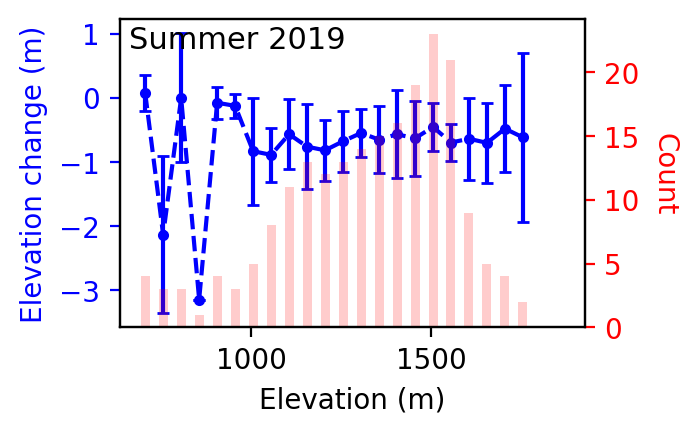

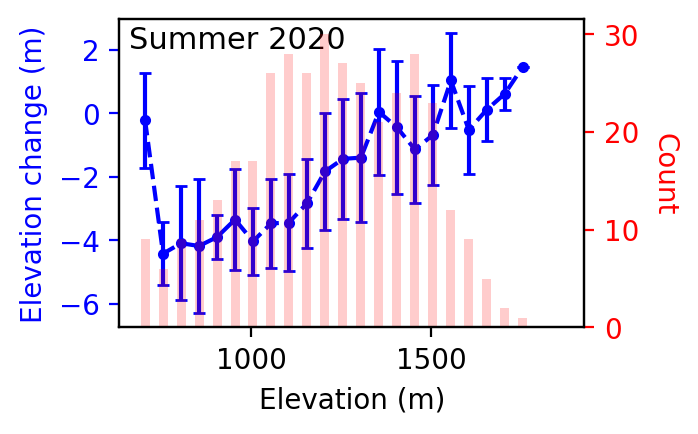

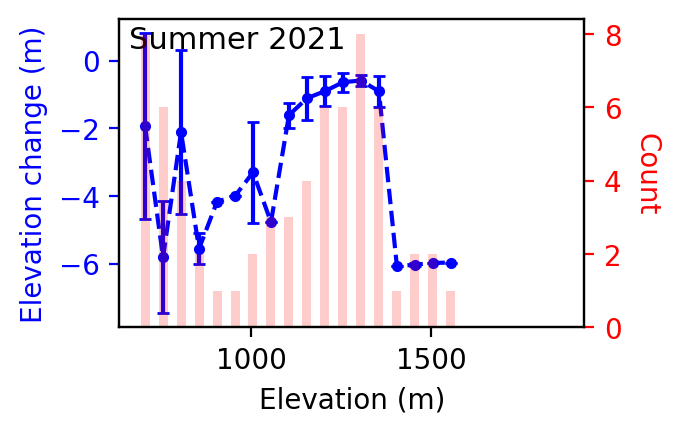

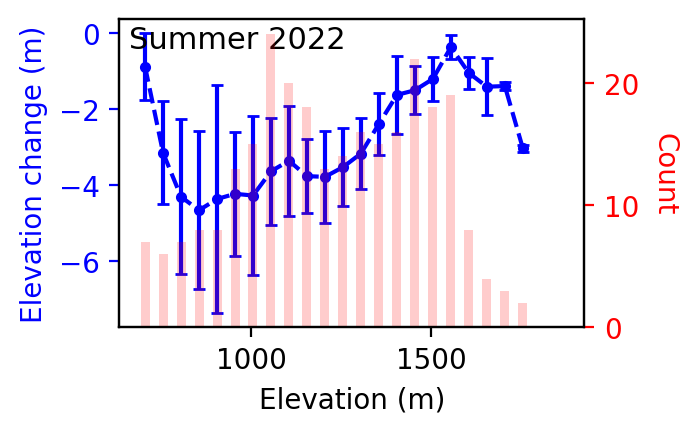

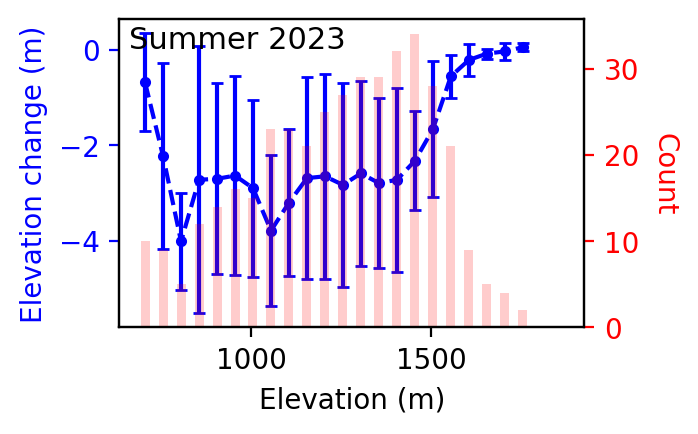

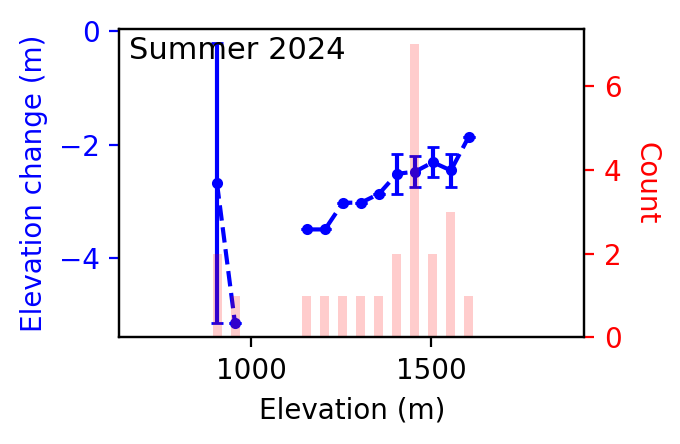

In [42]:
# Summer
xx, yy = xp, yp;
krg_sum = np.zeros([len(dh_sum), xx.shape[0], xx.shape[1]])
krg_sum_s2 = np.zeros([len(dh_sum), xx.shape[0], xx.shape[1]])

for k in range(0, len(dh_sum)):
  dh_dem = xdem.DEM.from_array(dh_sum[k], (spacing, 0.0, xp[0, 0], 0.0, spacing, yp[0, 0]), 3057)
  dh_dem = xdem.dDEM(raster = dh_dem, start_time=datetime(years[k], 4, 1), end_time=datetime(years[k], 10, 1))
  field = dh_dem.interpolate(method="local_hypsometric", reference_elevation=ref_dem, mask = glaciers)

  mask = glaciers.create_mask(dh_dem)

  ddem_bins = xdem.volume.hypsometric_binning(dh_dem[mask], ref_dem[mask])
  stds = xdem.volume.hypsometric_binning(dh_dem[mask], ref_dem[mask], aggregation_function=np.std)
  stds = stds.dropna().reset_index(drop = False)

  s2 = xp.copy() * 0 + 5
  H = ref_dem.data.data

  for i in range(0, len(stds)):
    v0 = stds['index'][i].left
    v1 = stds['index'][i].right
    s2[(H >= v0) & (H < v1)] = stds['value'][i]**2

  krg_sum[k] = field
  krg_sum_s2[k] = s2

  # draw_plot(xp, yp, field, s2, outside, gdf_sum[k], "Summer "+ str(years[k]))
  draw_hypsometry(ddem_bins, "Summer "+ str(years[k]))

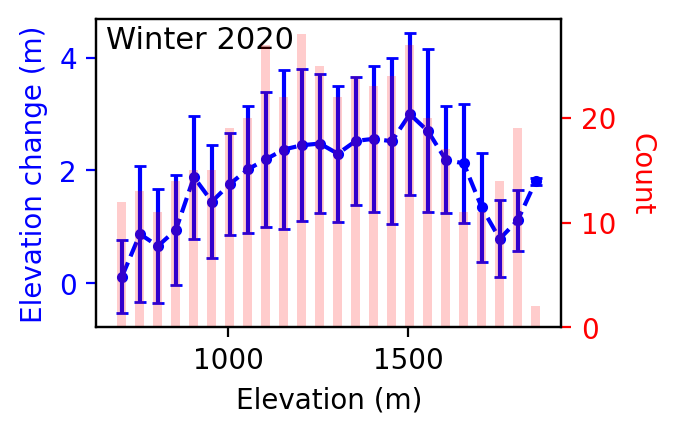

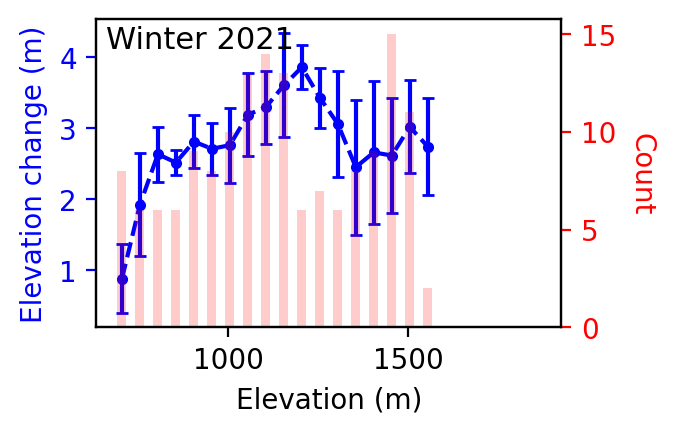

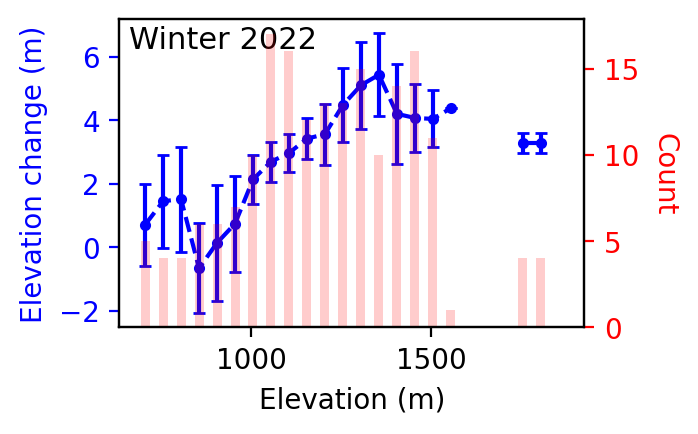

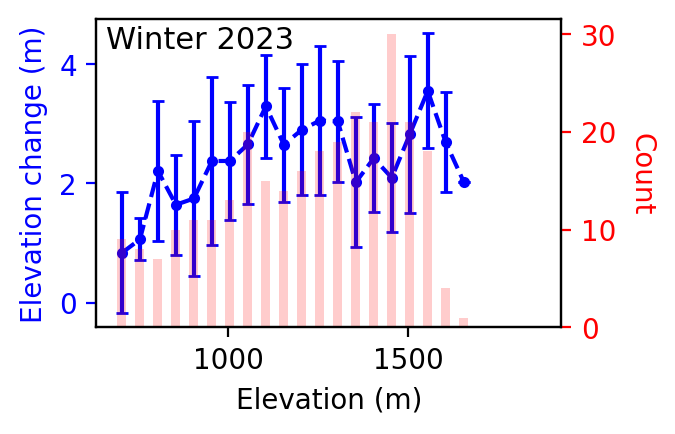

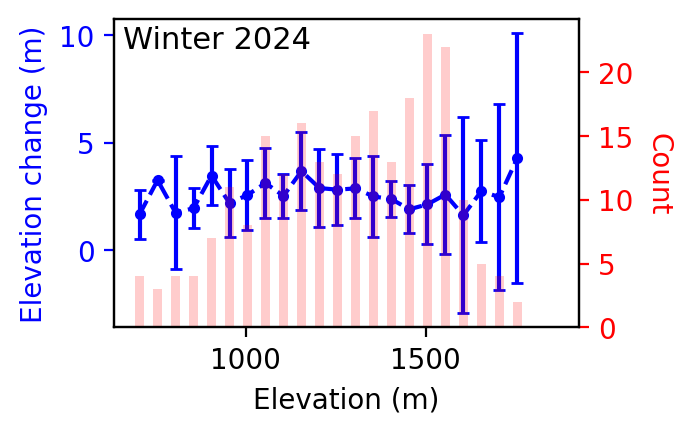

In [43]:
# Winter
xx, yy = xp, yp;
krg_win = np.zeros([len(dh_win), xx.shape[0], xx.shape[1]])
krg_win_s2 = np.zeros([len(dh_win), xx.shape[0], xx.shape[1]])

for k in range(1, len(dh_win)):
  dh_dem = xdem.DEM.from_array(dh_win[k], (spacing, 0.0, xp[0, 0], 0.0, spacing, yp[0, 0]), 3057)
  dh_dem = xdem.dDEM(raster = dh_dem, start_time=datetime(years[k]-1, 10, 1), end_time=datetime(years[k], 4, 1))
  field = dh_dem.interpolate(method="local_hypsometric", reference_elevation=ref_dem, mask = glaciers)

  mask = glaciers.create_mask(dh_dem)

  ddem_bins = xdem.volume.hypsometric_binning(dh_dem[mask], ref_dem[mask])
  stds = xdem.volume.hypsometric_binning(dh_dem[mask], ref_dem[mask], aggregation_function=np.std)
  stds = stds.dropna().reset_index(drop = False)

  s2 = xp.copy() * 0 + 5
  H = ref_dem.data.data

  for i in range(0, len(stds)):
    v0 = stds['index'][i].left
    v1 = stds['index'][i].right
    s2[(H >= v0) & (H < v1)] = stds['value'][i]**2

  krg_win[k] = field
  krg_win_s2[k] = s2

  # draw_plot(xp, yp, field, s2, outside, gdf_win[k], "Winter "+ str(years[k]))
  draw_hypsometry(ddem_bins, "Winter "+ str(years[k]))

# Convert elevation change to mass balance change

In [ ]:
%pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 48.5 MB/s eta 0:00:00


In [ ]:
import rasterio

# from matplotlib import pyplot
with rasterio.open(f"drive/MyDrive/iceland_oct2020_50.tif") as src:
    band1 = src.read(1)
    # band1[band1 < 1100] = np.nan

    height = band1.shape[0]
    width = band1.shape[1]
    cols, rows = np.meshgrid(np.arange(width), np.arange(height))
    xxd, yyd = rasterio.transform.xy(src.transform, rows, cols)
    xxd = xxd.reshape(band1.shape)
    yyd = yyd.reshape(band1.shape)

    print('Band1 has shape', band1.shape)

Band1 has shape (829, 738)


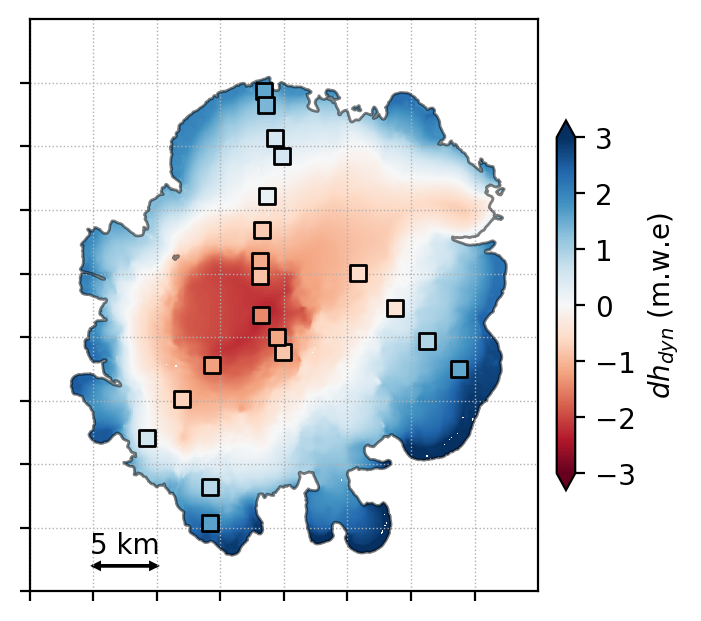

In [ ]:
fig, ax = plt.subplots(1,1,figsize = (4,4), dpi = 200)

# ax.legend()
plt.axis('scaled')
# ax.title(f"{y} {season.upper()}")

shapefile.boundary.plot(ax = ax, color = "k", lw = 1, alpha = 0.5)

# gdf.plot("h_diff", ax = ax, vmin = -5, vmax = 5, cmap = "RdBu", markersize = 50, edgecolors='black', marker = "s", label = "In-situ")
# gdf_out['bs_is2'] = gdf_out['h_mean_sum'] - gdf_out['h_mean_win']
# gdf_out['bw_is2'] = gdf_out['h_mean_win'] - gdf_out['h_mean_sum']

for n, site in enumerate(keyList[:]):
  df = dict_insitu2[site]
  ax.scatter(df['x'][0], df['y'][0], c = -df['dh_dyn'][0], vmin = -3, vmax = 3, cmap = "RdBu", zorder = 10, s = 30, edgecolors='black', marker = "s")
  # ax.text(df['x'][0]+700, df['y'][0]+100, site)

a = 0.004584208473991501
b = -6.20352769584232

z = -(band1*a + b)
im = ax.pcolormesh(xxd, yyd, z, vmin = -3, vmax = 3, cmap = "RdBu")

x1, x2 = ax.set_xlim(488000, 528000)
y1, y2 = ax.set_ylim(457000, 502000)
ax.set_yticks(np.arange(y1, y2, 5000), [])
ax.set_xticks(np.arange(x1, x2, 5000), [])
ax.grid(ls = ":", lw = 0.5)

outside.plot(ax = ax, color = "w")

# im = cbar.get_images()[0]
fig.colorbar(im, shrink = 0.6, label = "$dh_{dyn}$ (m.w.e)", orientation = 'vertical', pad = 0.03, extend = "both")

# SCale bar
plt.annotate("5 km", xy=(488000 + 7500, 457000+3000), fontsize = 10, ha = "center")
ax.arrow(488000 + 5000, 457000+2000, 5000, 0, color='k', head_length = 500, head_width = 500, length_includes_head = True)
ax.arrow(488000 + 10000, 457000+2000, -5000, 0, color='k', head_length = 500, head_width = 500, length_includes_head = True)

-0.0006720972933000212 0.7561702125558296


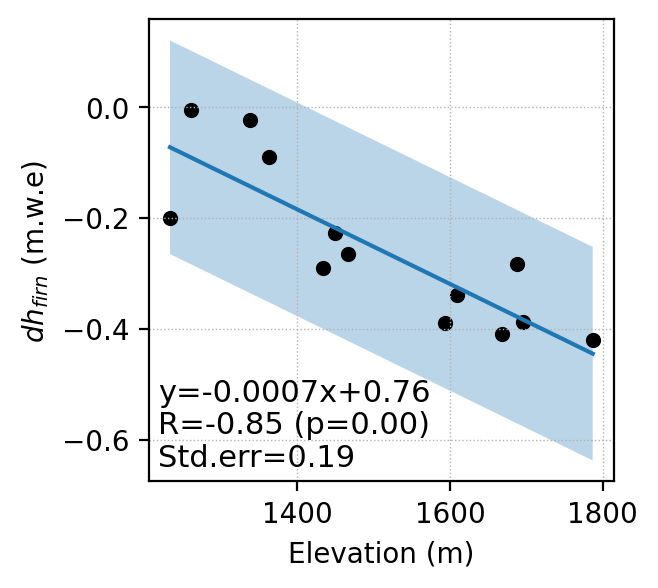

In [ ]:
insitu = pd.read_csv(f"drive/MyDrive/Colab Notebooks/Iceland/Data_insitu/hst-2018.csv") #.reset_index(drop = False)

xh = insitu['h'].values
xba = insitu['ba_str'].values

xh = xh[xba > 0]
xba = xba[xba > 0]

xba = -xba*1000 * (1/550-1/650) *0.5

res = stats.linregress(xh, xba)
a = res.slope
b = res.intercept
r = res.rvalue
p = res.pvalue
std_err = res.intercept_stderr
print(a, b)
# sns.regplot(x = xh, y = xdyn, ci=95)

plt.subplots(1,1, dpi = 200, figsize = (3,3))
plt.scatter(xh, xba, color = "k", s= 20)

xs = np.linspace(xh.min(), xh.max(), 10)
plt.plot(xs, a*xs + b)

plt.fill_between(xs, a*xs + b - std_err, a*xs + b + std_err, alpha = 0.3, zorder = 0)
plt.annotate(f"y={a:.4f}x+{b:.2f}", xy=(0.02,0.16), xycoords='axes fraction', fontsize=11, ha='left', va='bottom')
plt.annotate(f"R={r:.2f} (p={p:.2f})", xy=(0.02,0.09), xycoords='axes fraction', fontsize=11, ha='left', va='bottom')
plt.annotate(f"Std.err={std_err:.2f}", xy=(0.02,0.02), xycoords='axes fraction', fontsize=11, ha='left', va='bottom')

plt.xlabel("Elevation (m)")
plt.ylabel("$dh_{firn}$ (m.w.e)")
plt.grid(ls = ":", lw = 0.5)

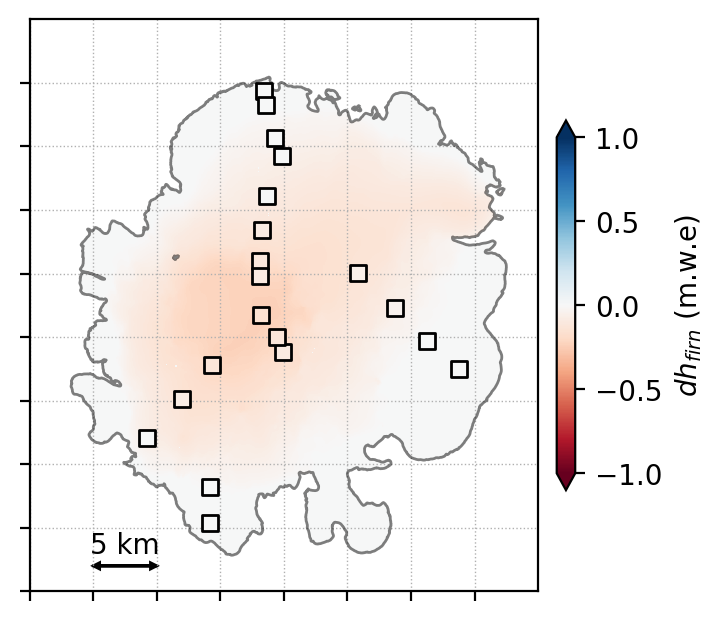

In [ ]:
fig, ax = plt.subplots(1,1,figsize = (4,4), dpi = 200)

# ax.legend()
plt.axis('scaled')
# ax.title(f"{y} {season.upper()}")

shapefile.boundary.plot(ax = ax, color = "k", lw = 1, alpha = 0.5)

for n, site in enumerate(keyList[:]):
  df = dict_insitu2[site]
  ax.scatter(df['x'][0], df['y'][0], c = -df.loc[df['year'] == 2018, 'firn'].mean(), vmin = -3, vmax = 3, cmap = "RdBu", zorder = 10, s = 30, edgecolors='black', marker = "s")
  # ax.text(df['x'][0]+700, df['y'][0]+100, site)

a = -0.0006720972933000212 # -0.0013348599019708757
b = 0.7561702125558296 #1.5018380610483844

z1 = band1*a + b # mass balance
z2 = np.where(z1 < 0, z1*0.5, 0)

im = ax.pcolormesh(xxd, yyd, z2, vmin = -1, vmax = 1, cmap = "RdBu")
fig.colorbar(im, shrink = 0.6, label = "$dh_{firn}$ (m.w.e)", orientation = 'vertical', pad = 0.03, extend = "both")

# art = ax.contourf(xx, yy, z2, cmap='RdBu', vmin=-3, vmax=3, levels = np.arange(-3, 3.2, 0.2), extend = "both")
# cbar = plt.colorbar(art, ax=ax, shrink = 0.6, label = "$dh_{firn}$ (m.w.e)", orientation = 'vertical', pad = 0.03, extend = "both")
outside.plot(ax = ax, color = "w")

x1, x2 = ax.set_xlim(488000, 528000)
y1, y2 = ax.set_ylim(457000, 502000)
ax.set_yticks(np.arange(y1, y2, 5000), [])
ax.set_xticks(np.arange(x1, x2, 5000), [])
ax.grid(ls = ":", lw = 0.5)

# SCale bar
plt.annotate("5 km", xy=(488000 + 7500, 457000+3000), fontsize = 10, ha = "center")
ax.arrow(488000 + 5000, 457000+2000, 5000, 0, color='k', head_length = 500, head_width = 500, length_includes_head = True)
ax.arrow(488000 + 10000, 457000+2000, -5000, 0, color='k', head_length = 500, head_width = 500, length_includes_head = True)

In [ ]:
xx, yy = xp, yp; #np.meshgrid(np.arange(490000., 530000., 500), np.arange(460000., 500000., 500))

df_grid = pd.DataFrame({'x': xx.flatten(), 'y': yy.flatten(), 'flag': yy.flatten()*0})
gdf_grid = gpd.GeoDataFrame(df_grid, geometry=gpd.points_from_xy(df_grid.x, df_grid.y), crs="EPSG:3057")

dd = gpd.sjoin(left_df=gdf_grid, right_df=shapefile, how='inner')
df_grid.loc[dd.index, 'flag'] = 1
# Glacier flag
flag = df_grid['flag'].values.reshape(xx.shape[0], xx.shape[1])
flag = flag.astype(float)

dh_dyn = np.zeros(xx.shape)
dh_firn = np.zeros(xx.shape)

for i in tqdm(range(xx.shape[0])):
  for j in range(yy.shape[1]):
    dh_dyn[i,j] = np.nanmean(z[(abs(xxd - xx[i, j]) < spacing/2) & (abs(yyd - yy[i, j]) <  spacing/2)])
    dh_firn[i,j] = np.nanmean(z2[(abs(xxd - xx[i, j]) <  spacing/2) & (abs(yyd - yy[i, j]) < spacing/2)])

# dh_dyn = dh_dyn - np.nanmean(dh_dyn[flag == 1])

100%|██████████| 40/40 [00:10<00:00,  4.00it/s]


In [ ]:
insitu = pd.read_csv(f"drive/MyDrive/Colab Notebooks/Iceland/Data_insitu/hst-{2019}.csv")
np.nanstd(insitu['rhow']), np.nanmean(insitu['rhow']), np.nanstd(insitu['rhos']), np.nanmean(insitu['rhos'])

(46.47838207166854, 537.0, 10.304020550550781, 567.7777777777778)

In [ ]:
df_mb = pd.DataFrame()

mbs_grid = np.zeros(krg_sum.shape)
mbw_grid = np.zeros(krg_win.shape)
uncs_grid = np.zeros(krg_sum.shape)
uncw_grid = np.zeros(krg_win.shape)
mba_grid = np.zeros(krg_sum.shape)

dh_firn[np.isnan(dh_firn)] = 0
flag[flag == 0] = np.nan

for i, year in enumerate(years[:]):
  dhs = krg_sum[i] * flag
  s2s = krg_sum_s2[i] * flag
  dhw = krg_win[i] * flag
  s2w = krg_win_s2[i] * flag

  # dhs[s2s > 5] = np.nan
  # dhw[s2w > 5] = np.nan

  rhow = 500; drhow = 50;
  rhos = 550; drhos = 20;
  firnv = 0.24; dfirnv = 0.15;
  dynv = 0.0; ddynv = 0.21;

  mbs = dhs*500/1000 - (dh_firn + dh_dyn)*0.5
  mbw = dhw*500/1000 - (dh_firn + dh_dyn)*0.5

  unc_sum = (((dhs+dh_firn)*drhos/1000)**2 + (rhos/1000*s2s)**2 + (rhos/1000*dfirnv)**2)**0.5
  unc_win = (((dhw+dh_firn)*drhow/1000)**2 + (rhow/1000*s2w)**2 + (rhow/1000*dfirnv)**2)**0.5

  mbs_grid[i] = mbs
  mbw_grid[i] = mbw
  mba_grid[i] = mbs + mbw #+ dh_firn + dh_dyn
  uncs_grid[i] = unc_sum
  uncw_grid[i] = unc_win

  df_mb.loc[i, "year"] = year
  valid = (~np.isnan(dhs)) & (~np.isnan(dhw))
  df_mb.loc[i, "mb_sum"] = np.nanmean(mbs[valid])
  df_mb.loc[i, "unc_sum"] = np.nanmean(unc_sum[valid])
  df_mb.loc[i, "mb_win"] = np.nanmean(mbw[valid])
  df_mb.loc[i, "unc_win"] = np.nanmean(unc_win[valid])

  # In-situ measurements
  insitu = pd.read_csv(f"drive/MyDrive/Colab Notebooks/Iceland/Data_insitu/hst-{year}.csv") #.reset_index(drop = False)
  df_mb.loc[i, "mb_sum_stake"] = np.nanmean(insitu['bs_fld'])
  df_mb.loc[i, "unc_sum_stake"] = np.nanstd(insitu['bs_fld'])
  df_mb.loc[i, "mb_win_stake"] = np.nanmean(insitu['bw_fld'])
  df_mb.loc[i, "unc_win_stake"] = np.nanstd(insitu['bw_fld'])

  # Draw
  # fig, ax = plt.subplots(2,2, dpi = 200, figsize = (5,5))


  # # plt.pcolormesh(xx, yy, mb*flag, cmap = "RdBu", vmin = -5, vmax = 5)
  # ax[0, 0].contourf(xx, yy, mbs*flag, cmap = "RdBu", levels = np.arange(-8, 8))
  # ax[0, 1].contourf(xx, yy, mbw*flag, cmap = "RdBu", levels = np.arange(-8, 8))
  # ax[1, 0].pcolormesh(xx, yy, unc_sum, cmap = "plasma", vmin = 0, vmax = 4)
  # ax[1, 1].pcolormesh(xx, yy, unc_win, cmap = "plasma", vmin = 0, vmax = 4)
  # # plt.colorbar()

df_mb['mb_ann'] = df_mb['mb_sum'] + df_mb['mb_win']
df_mb['unc_ann'] = df_mb['unc_sum'] + df_mb['unc_win']
df_mb['mb_ann_stake'] = df_mb['mb_sum_stake'] + df_mb['mb_win_stake']
df_mb['unc_ann_stake'] = df_mb['unc_sum_stake'] + df_mb['unc_win_stake']

Text(0, 0.5, 'Mass balance (m.w.e)')

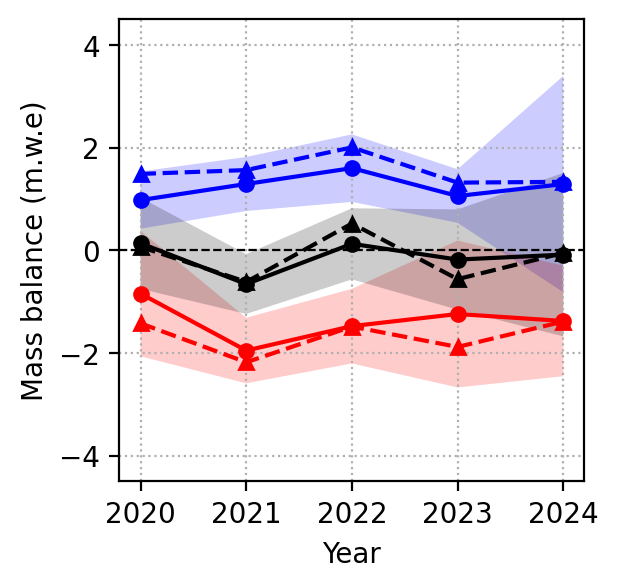

In [ ]:
fig, ax = plt.subplots(1,1, figsize = (3,3), dpi = 200)

df_mb = df_mb[df_mb['year'] > 2019]
plt.plot(df_mb['year'], df_mb['mb_sum'], color = "r", marker = 'o', markersize = 5, label = "Summer")
plt.plot(df_mb['year'], df_mb['mb_win'], color = "b", marker = 'o', markersize = 5, label = "Winter")
plt.plot(df_mb['year'], df_mb['mb_ann'], color = "k", marker = 'o', markersize = 5, label = "Annual")

plt.plot(df_mb['year'], df_mb['mb_sum_stake'], color = "r", marker = '^', ls = "--", markersize = 5, label = "Summer")
plt.plot(df_mb['year'], df_mb['mb_win_stake'], color = "b", marker = '^', ls = "--", markersize = 5, label = "Winter")
plt.plot(df_mb['year'], df_mb['mb_ann_stake'], color = "k", marker = '^', ls = "--", markersize = 5, label = "Annual")

# plt.errorbar(df_mb['year'], df_mb['mb_sum'], df_mb['unc_sum'], fmt ='.', markersize = 10, color = "r", capsize=5, label = "ICESat-2")
# plt.errorbar(df_mb['year'], df_mb['mb_win'], df_mb['unc_win'], fmt ='.', markersize = 10, color = "b", capsize=5, label = "ICESat-2")

plt.fill_between(df_mb['year'], df_mb['mb_win'] - df_mb['unc_win'], df_mb['mb_win'] + df_mb['unc_win'],
                 edgecolor=None, facecolor = "b", alpha = 0.2)
plt.fill_between(df_mb['year'], df_mb['mb_sum'] - df_mb['unc_sum'], df_mb['mb_sum'] + df_mb['unc_sum'],
                 edgecolor=None, facecolor = "r", alpha = 0.2)
plt.fill_between(df_mb['year'], df_mb['mb_ann'] - df_mb['unc_ann']*0.5, df_mb['mb_ann'] + df_mb['unc_ann']*0.5,
                 edgecolor=None, facecolor = "k", alpha = 0.2)

plt.axhline(0, ls = "--", color = "k", lw = 0.8)
# plt.legend(fontsize = 9, loc = "upper center", bbox_to_anchor = (0.5, 1), ncol = 2)
plt.xticks(years[1:])
plt.xlim(2019.8, 2024.2)
plt.ylim(-4.5, 4.5)
plt.grid(ls = ":")
plt.xlabel("Year")
plt.ylabel("Mass balance (m.w.e)")
# plt.errorbar(df_mb['year'], df_mb['mb_ann'], df_mb['unc_ann'], fmt ='.', markersize = 10, color = "k", capsize=5, label = "ICESat-2")

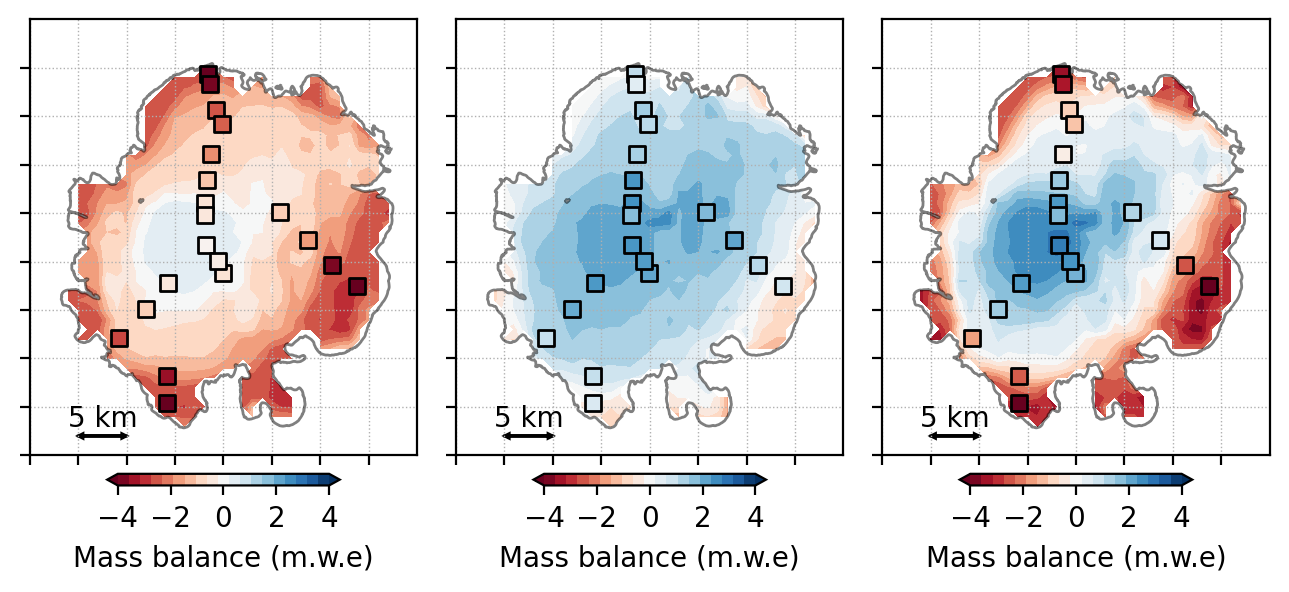

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(8,4), dpi = 200)
fig.subplots_adjust(wspace = 0.1, hspace = 0.05)

vmin = -8; vmax = 8
# art = ax[0].pcolormesh(xx, yy, field, cmap='RdBu', vmin=-8, vmax=8)
art = ax[0].contourf(xx, yy, np.nanmean(mbs_grid, axis = 0), cmap='RdBu', levels = np.linspace(-4, 4, 20), extend = "both")
outside.plot(ax = ax[0], color = "w")
# ax[0].set_title('%s model' % V1.model.__name__)
cbar = plt.colorbar(art, ax=ax[0], orientation = "horizontal", shrink = 0.6, pad = 0.03, extend = "both", label = "Mass balance (m.w.e)")
cbar.set_ticks(np.linspace(-4, 4, 5))
# cbar.set_ticklabels(ctkls)
# ax[0].annotate("Summer", xy=(0.02,0.98), xycoords='axes fraction', fontsize=11, ha='left', va='top')

for n, site in enumerate(keyList[:]):
  df = dict_insitu2[site]
  m = df['d2'].dt.month
  v = df.loc[(df['year'] >= 2019) & (m >= 9) &(m <= 11), 'b_fld'].mean()
  ax[0].scatter(df['x'][0], df['y'][0], c = v, vmin = -4, vmax = 4, cmap = "RdBu", zorder = 10, s = 30, edgecolors='black', marker = "s")

# art = ax[0].pcolormesh(xx, yy, field, cmap='RdBu', vmin=-8, vmax=8)
art = ax[1].contourf(xx, yy, np.nanmean(mbw_grid, axis = 0), cmap='RdBu', levels = np.linspace(-4, 4, 20), extend = "both")
outside.plot(ax = ax[1], color = "w")
# ax[0].set_title('%s model' % V1.model.__name__)
cbar = plt.colorbar(art, ax=ax[1], orientation = "horizontal", shrink = 0.6, pad = 0.03, extend = "both", label = "Mass balance (m.w.e)")
cbar.set_ticks(np.linspace(-4, 4, 5))
# cbar.set_ticklabels(ctkls)
# ax[1].annotate("Winter", xy=(0.02,0.98), xycoords='axes fraction', fontsize=11, ha='left', va='top')

for n, site in enumerate(keyList[:]):
  df = dict_insitu2[site]
  m = df['d2'].dt.month
  v = df.loc[(df['year'] >= 2019) & (m >= 3) & (m <= 5), 'b_fld'].mean()
  ax[1].scatter(df['x'][0], df['y'][0], c = v, vmin = -4, vmax = 4, cmap = "RdBu", zorder = 10, s = 30, edgecolors='black', marker = "s")

# art = ax[0].pcolormesh(xx, yy, field, cmap='RdBu', vmin=-8, vmax=8)
art = ax[2].contourf(xx, yy, np.nanmean(mba_grid, axis = 0), cmap='RdBu', levels = np.linspace(-4, 4, 20), extend = "both")
outside.plot(ax = ax[2], color = "w")
# ax[0].set_title('%s model' % V1.model.__name__)
cbar = plt.colorbar(art, ax=ax[2], orientation = "horizontal", shrink = 0.6, pad = 0.03, extend = "both", label = "Mass balance (m.w.e)")
cbar.set_ticks(np.linspace(-4, 4, 5))
# cbar.set_ticklabels(ctkls)
# ax[2].annotate("Annual", xy=(0.02,0.98), xycoords='axes fraction', fontsize=11, ha='left', va='top')

for n, site in enumerate(keyList[:]):
  df = dict_insitu2[site]
  m = df['d2'].dt.month
  v = df.loc[(df['year'] >= 2019), 'ba_fld'].mean()
  ax[2].scatter(df['x'][0], df['y'][0], c = v, vmin = -4, vmax = 4, cmap = "RdBu", zorder = 10, s = 30, edgecolors='black', marker = "s")

for a in ax:
  shapefile.boundary.plot(ax = a, color = "k", lw = 1, alpha = 0.5)
  x1, x2 = a.set_xlim(488000, 528000)
  y1, y2 = a.set_ylim(457000, 502000)
  a.set_yticks(np.arange(y1, y2, 5000), [])
  a.set_xticks(np.arange(x1, x2, 5000), [])
  a.grid(ls = ":", lw = 0.5)

  a.annotate("5 km", xy=(488000 + 7500, 457000+3000), fontsize = 10, ha = "center")
  a.arrow(488000 + 5000, 457000+2000, 5000, 0, color='k', head_length = 500, head_width = 500, length_includes_head = True)
  a.arrow(488000 + 10000, 457000+2000, -5000, 0, color='k', head_length = 500, head_width = 500, length_includes_head = True)



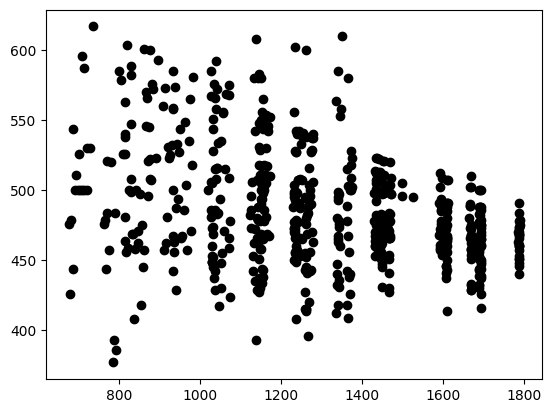

In [ ]:
for p in dict_insitu2.keys():
  df = dict_insitu2[p]
  df = df[df['d1'].dt.month >= 8]
  plt.scatter(df['h'], df['rho'], color = "k")

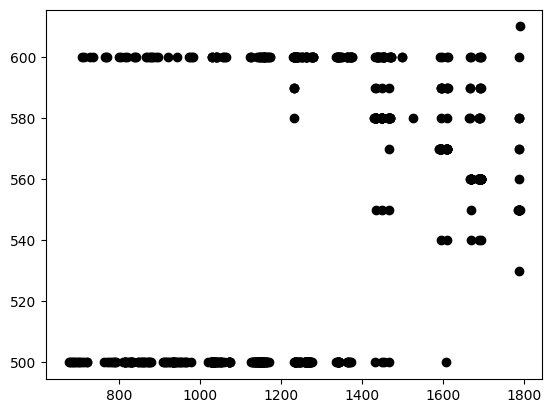

In [ ]:
for p in dict_insitu2.keys():
  df = dict_insitu2[p]
  df = df[df['d1'].dt.month <= 8]
  plt.scatter(df['h'], df['rho'], color = "k")

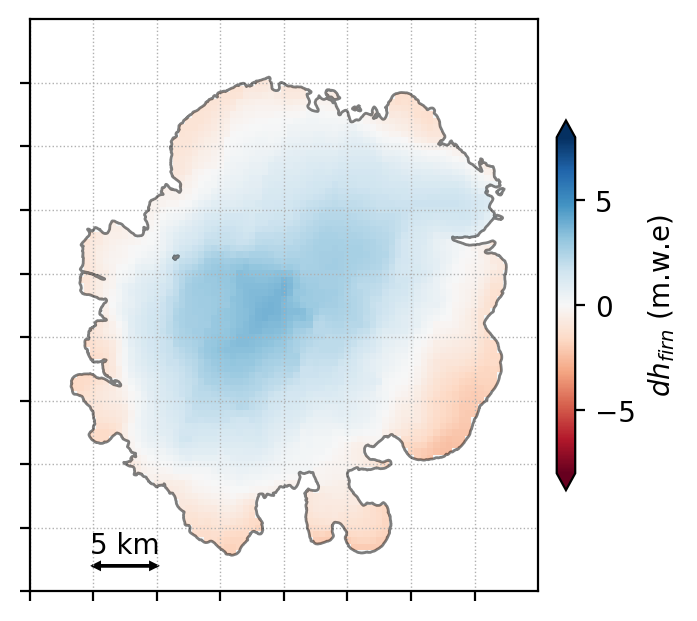

In [ ]:
fig, ax = plt.subplots(1,1,figsize = (4,4), dpi = 200)

# ax.legend()
plt.axis('scaled')
# ax.title(f"{y} {season.upper()}")

shapefile.boundary.plot(ax = ax, color = "k", lw = 1, alpha = 0.5)

im = ax.pcolormesh(xx, yy, np.nanmean(mbw_grid, axis = 0), vmin = -8, vmax = 8, cmap = "RdBu")
fig.colorbar(im, shrink = 0.6, label = "$dh_{firn}$ (m.w.e)", orientation = 'vertical', pad = 0.03, extend = "both")

# art = ax.contourf(xx, yy, z2, cmap='RdBu', vmin=-3, vmax=3, levels = np.arange(-3, 3.2, 0.2), extend = "both")
# cbar = plt.colorbar(art, ax=ax, shrink = 0.6, label = "$dh_{firn}$ (m.w.e)", orientation = 'vertical', pad = 0.03, extend = "both")
outside.plot(ax = ax, color = "w")

x1, x2 = ax.set_xlim(488000, 528000)
y1, y2 = ax.set_ylim(457000, 502000)
ax.set_yticks(np.arange(y1, y2, 5000), [])
ax.set_xticks(np.arange(x1, x2, 5000), [])
ax.grid(ls = ":", lw = 0.5)

# SCale bar
plt.annotate("5 km", xy=(488000 + 7500, 457000+3000), fontsize = 10, ha = "center")
ax.arrow(488000 + 5000, 457000+2000, 5000, 0, color='k', head_length = 500, head_width = 500, length_includes_head = True)
ax.arrow(488000 + 10000, 457000+2000, -5000, 0, color='k', head_length = 500, head_width = 500, length_includes_head = True)

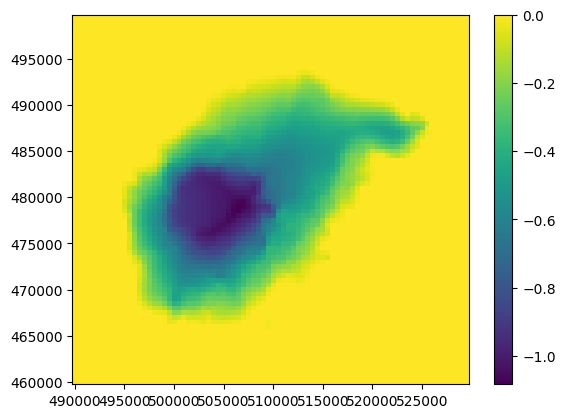

In [ ]:
plt.pcolormesh(xx, yy, dh_firn)
plt.colorbar()

In [ ]:
fig, ax = plt.subplots(1,1,figsize = (4,4), dpi = 200)

# ax.legend()
plt.axis('scaled')
# ax.title(f"{y} {season.upper()}")

shapefile.boundary.plot(ax = ax, color = "w", lw = 1, alpha = 0.5)
# gdf.plot("h_diff", ax = ax, vmin = -5, vmax = 5, cmap = "RdBu", markersize = 50, edgecolors='black', marker = "s", label = "In-situ")
# gdf_out['bs_is2'] = gdf_out['h_mean_sum'] - gdf_out['h_mean_win']
# gdf_out['bw_is2'] = gdf_out['h_mean_win'] - gdf_out['h_mean_sum']

for n, site in enumerate(keyList[:]):
  df = dict_insitu2[site]
  ax.scatter(df['x'][0], df['y'][0], c = df['dh_dyn'][0], vmin = -3, vmax = 3, cmap = "RdBu", zorder = 10, s = 30, edgecolors='black', marker = "s")
  # ax.text(df['x'][0]+700, df['y'][0]+100, site)

a = 0.004584208473991501
b = -6.20352769584232

z = band1*a + b

im = ax.pcolormesh(xs, ys, z, vmin = -3, vmax = 3, cmap = "RdBu")

x1, x2 = ax.set_xlim(488000, 528000)
y1, y2 = ax.set_ylim(457000, 502000)
ax.set_yticks(np.arange(y1, y2, 5000), [])
ax.set_xticks(np.arange(x1, x2, 5000), [])
ax.grid(ls = ":", lw = 0.5)

# im = cbar.get_images()[0]
fig.colorbar(im, shrink = 0.6, label = "$dh_{dyn}$ (m.w.e)", orientation = 'horizontal', pad = 0.05)

# SCale bar
plt.annotate("5 km", xy=(488000 + 7500, 457000+3000), fontsize = 10, ha = "center")
ax.arrow(488000 + 5000, 457000+2000, 5000, 0, color='k', head_length = 500, head_width = 500, length_includes_head = True)
ax.arrow(488000 + 10000, 457000+2000, -5000, 0, color='k', head_length = 500, head_width = 500, length_includes_head = True)

In [ ]:
df2 = pd.read_csv(file2, index_col = 0)
df2 = df2[df2['mean'] > 0].reset_index(drop = True)
gdf2 = gpd.GeoDataFrame(df2, geometry=gpd.points_from_xy(df2.lon, df2.lat), crs="EPSG:4326").to_crs(3057)
gdf2 = gdf2[(abs(gdf2['h_diff']) < h_th) & (gdf2['rgt'] == rgt)].reset_index(drop = True)
gdf2['date'] = gdf2['year']*10000 + gdf1['month']*100 + gdf1['day']

gdf2['x'] = gdf2['geometry'].x
gdf2['y'] = gdf2['geometry'].y

gdf2

geometry  day  gt      h_mean   h_sigma        lat  \
0     POINT (513433.428 463235.213)   21  50  861.866694  0.189071  64.669947   
1     POINT (513435.536 463255.117)   21  50  863.352682  0.030002  64.670126   
2     POINT (513437.646 463275.021)   21  50  864.871569  0.028792  64.670304   
3     POINT (513439.755 463294.924)   21  50  866.370616  0.072857  64.670483   
4     POINT (513441.855 463314.829)   21  50  868.061972  0.044542  64.670661   
...                             ...  ...  ..         ...       ...        ...   
3318  POINT (516844.039 496063.084)   21  50  859.922696  0.022360  64.964260   
3319  POINT (516846.186 496082.984)   21  50  859.138666  0.093183  64.964438   
3320  POINT (516848.359 496103.095)   21  50  858.612882  0.115787  64.964618   
3321   POINT (516850.558 496123.41)   21  50  859.368307  0.136547  64.964801   
3322  POINT (516852.628 496142.681)   21  50  858.139549  0.101912  64.964973   

            lon        mean  month  rgt       x_atc      y_atc  year  \
0    -18.718692  867.657288     10  497  12862046.0 -3200.4187  2023   
1    -18.718646  870.297119     10  497  12862026.0 -3200.3872  2023   
2    -18.718599  872.024292     10  497  12862006.0 -3200.3547  2023   
3    -18.718553  873.455078     10  497  12861986.0 -3200.3235  2023   
4    -18.718508  875.021423     10  497  12861966.0 -3200.3003  2023   
...         ...         ...    ...  ...         ...        ...   ...   
3318 -18.643394  859.669006     10  497  12829037.0 -3205.1863  2023   
3319 -18.643346  859.662964     10  497  12829017.0 -3205.1038  2023   
3320 -18.643297  858.405518     10  497  12828997.0 -3205.0176  2023   
3321 -18.643248  859.056396     10  497  12828977.0 -3204.9258  2023   
3322 -18.643202  859.406738     10  497  12828957.0 -3204.8555  2023   

        h_diff        date              x              y  
0    -5.790593  20231026.0  513433.427625  463235.213094  
1    -6.944437  20231026.0  513435.536402  463255.116864  
2    -7.152723  20231026.0  513437.646093  463275.020618  
3    -7.084462  20231026.0  513439.754510  463294.924056  
4    -6.959451  20231026.0  513441.854953  463314.829259  
...        ...         ...            ...            ...  
3318  0.253690         NaN  516844.038668  496063.084171  
3319 -0.524298         NaN  516846.185763  496082.983505  
3320  0.207365         NaN  516848.358593  496103.095403  
3321  0.311910         NaN  516850.557870  496123.409938  
3322 -1.267189         NaN  516852.627629  496142.681201  

[3323 rows x 17 columns]

(array([   8.,   17.,   51.,  264.,  333.,  762., 1765.,  116.,    3.,
           4.]),
 array([-18.02819923, -15.38501316, -12.74182709, -10.09864102,
         -7.45545495,  -4.81226888,  -2.16908281,   0.47410326,
          3.11728933,   5.7604754 ,   8.40366148]),
 <BarContainer object of 10 artists>)

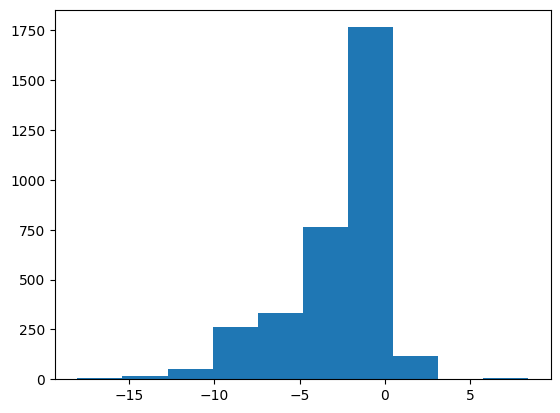

In [ ]:
plt.hist(gdf2['h_diff'])

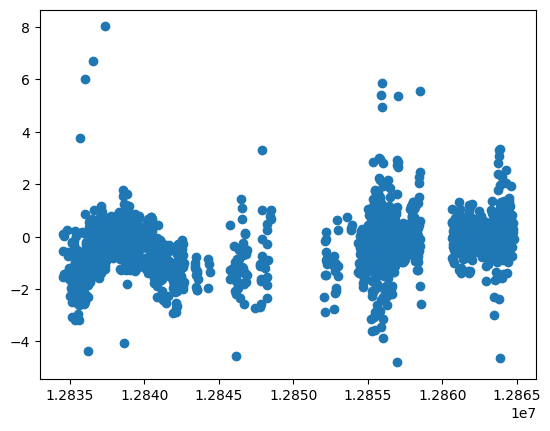

In [ ]:
plt.scatter(gdf1['x_atc'], gdf1['h_diff'])

(array([4.000e+00, 3.000e+00, 1.600e+01, 4.500e+01, 2.020e+02, 1.632e+03,
        3.780e+03, 9.270e+02, 9.900e+01, 2.000e+01]),
 array([-5.7694705 , -4.74827838, -3.72708626, -2.70589414, -1.68470201,
        -0.66350989,  0.35768223,  1.37887435,  2.40006647,  3.42125859,
         4.44245072]),
 <BarContainer object of 10 artists>)

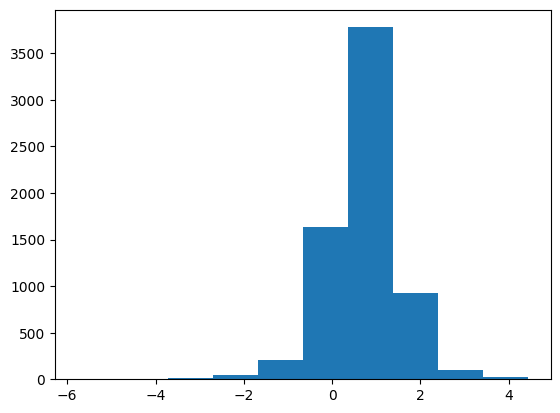

In [ ]:
plt.hist(gdf1['h_diff'].values)

In [ ]:
## BY YEAR
import os

# List of keys
keyList = pd.unique(gdf_insitu["#stake"])

mm = { 'win': 1, 'spr': 4, 'sum': 7, 'aut': 10}
mm = { 'win': 2, 'spr': 5, 'sum': 8, 'aut': 11}

# initialize dictionary
dict_insitu = {}
dict_is2 = {}
dict_is1 = {}
dict_cs2 = {}

# # iterating through the elements of list
# for p in keyList:
#     dict_insitu[p] = pd.DataFrame()
#     dict_is2[p] = pd.DataFrame()
#     dict_is1[p] = pd.DataFrame()
#     dict_cs2[p] = pd.DataFrame()

is2 = True
is1 = False
cs2 = False

for y in tqdm(range(1988, 2024)):

  insitu = pd.read_csv(f"drive/MyDrive/Colab Notebooks/Iceland/Data_insitu/hst-{y}.csv") #.reset_index(drop = False)
  points = np.unique(insitu["#stake"])

  for p in points:
    if p not in dict_insitu.keys():
      dict_insitu[p] = pd.DataFrame()
      dict_is2[p] = pd.DataFrame()
      dict_is1[p] = pd.DataFrame()
      dict_cs2[p] = pd.DataFrame()

  gdf_out = gpd.GeoDataFrame(insitu, geometry=gpd.points_from_xy(insitu.x, insitu.y), crs="EPSG:3057")

  for season in ["win", "spr", "sum", "aut"]:

    # ICESat-2 data
    file1 = f"drive/MyDrive/Colab Notebooks/Iceland/Data_glacier/SR_glacier_{y}_{season}.csv"
    if os.path.exists(file1) and is2:
      is2 = True
      df1 = pd.read_csv(file1, index_col = 0)
      df1 = df1[df1['mean'] > 0].reset_index(drop = True)
      gdf1 = gpd.GeoDataFrame(df1, geometry=gpd.points_from_xy(df1.lon, df1.lat), crs="EPSG:4326").to_crs(3057)
      gdf1 = gdf1[abs(gdf1['h_diff']) < 20].reset_index(drop = True)
      gdf1['date'] = gdf1['month']*100 + gdf1['day']

      gdf1['x'] = gdf1['geometry'].x
      gdf1['y'] = gdf1['geometry'].y

      gdf_out1 = compare_insitu(gdf_out, gdf1, season, 'h_diff', buf = 3000)  # Compare with ICESat-2
    else:
      is2 = False

    # ICESat data
    file2 = f"drive/MyDrive/Colab Notebooks/Iceland/Data_glacier/IS_glacier_{y}_{season}.csv"
    if os.path.exists(file2) and is1:
      is1 = True
      df2 = pd.read_csv(file2, index_col = 0)
      gdf2 = gpd.GeoDataFrame(df2, geometry=gpd.points_from_xy(df2.Longitude, df2.Latitude), crs="EPSG:4326").to_crs(3057)

      gdf2['x'] = gdf2['geometry'].x
      gdf2['y'] = gdf2['geometry'].y

      gdf_out2 = compare_insitu(gdf_out, gdf2, season, 'Elevation', buf = 3000) # Compare with ICESat
    else:
      is1 = False

    # CryoSat-2 data
    file3 = f"drive/MyDrive/Colab Notebooks/Iceland/Data_glacier/CS2_glacier_{y}_{season}.csv"
    if os.path.exists(file3) and cs2:
      cs2 = True
      df3 = pd.read_csv(file3, index_col = 0)
      gdf3 = gpd.GeoDataFrame(df3, geometry=gpd.points_from_xy(df3.lon, df3.lat), crs="EPSG:4326").to_crs(3057)
      gdf3['h_diff'] = gdf3['h1'] - gdf3['mean']
      gdf3 = gdf3[abs(gdf3['h_diff']) < 20].reset_index(drop = True)

      gdf3['x'] = gdf3['geometry'].x
      gdf3['y'] = gdf3['geometry'].y

      gdf_out3 = compare_insitu(gdf_out, gdf3, season, 'h1', buf = 3000, N_th = 5) # Compare with CryoSat-2
    else:
      cs2 = False

    for k in dict_insitu.keys():
      ind0 = np.where(gdf_out['#stake'] == k)[0] #[0][0]

      if len(ind0) > 0:
        ind = ind0[0]

        # Process in-situ data
        if season == "win":
          df = pd.DataFrame({'date': [datetime.strptime(str(gdf_out.loc[ind, 'd2']), "%Y%m%d")], 'balance': [gdf_out.loc[ind, 'bw_str']],
                             'ba_str': [gdf_out.loc[ind, 'ba_str']]})
          df['year'] = y
          df['season'] = season
          if len(df) > 0:
            dict_insitu[k] = pd.concat([dict_insitu[k], df]).reset_index(drop = True)

        elif season == "sum":
          df = pd.DataFrame({'date': [datetime.strptime(str(gdf_out.loc[ind, 'd3']), "%Y%m%d")], 'balance': [gdf_out.loc[ind, 'bs_str']],
                             'ba_str': [gdf_out.loc[ind, 'ba_str']]})
          df['year'] = y
          df['season'] = season
          if len(df) > 0:
            dict_insitu[k] = pd.concat([dict_insitu[k], df]).reset_index(drop = True)

        d = datetime(y, mm[season], 20)

        if is2:
          df_is2_part = pd.DataFrame({'date': [d], 'h': gdf_out1.loc[ind, f'h_mean_{season}'], 'h_std': gdf_out1.loc[ind, f'h_std_{season}']})
          df_is2_part['year'] = y
          df_is2_part['season'] = season
          if len(df_is2_part) > 0:
            dict_is2[k] = pd.concat([dict_is2[k], df_is2_part]).reset_index(drop = True)

        if is1:
          df_is1_part = pd.DataFrame({'date': [d], 'h': gdf_out2.loc[ind, f'h_mean_{season}'], 'h_std': gdf_out2.loc[ind, f'h_std_{season}']})
          df_is1_part['year'] = y
          df_is1_part['season'] = season
          if len(df_is1_part) > 0:
            dict_is1[k] = pd.concat([dict_is1[k], df_is1_part]).reset_index(drop = True)

        if cs2:
          df_cs2_part = pd.DataFrame({'date': [d], 'h': gdf_out3.loc[ind, f'h_mean_{season}'], 'h_std': gdf_out3.loc[ind, f'h_std_{season}']})
          df_cs2_part['year'] = y
          df_cs2_part['season'] = season
          if len(df_cs2_part) > 0:
            dict_cs2[k] = pd.concat([dict_cs2[k], df_cs2_part]).reset_index(drop = True)

# for k in dict_insitu.keys():

#   if (k in dict_is2.keys()) and (len(dict_is2[k]) > 0):
#     dict_is2[k].loc[1:, "h_balance"] = dict_is2[k]['h'][1:].values - dict_is2[k]['h'][:-1].values
#   if (k in dict_is1.keys()) and (len(dict_is1[k]) > 0):
#     dict_is1[k].loc[1:, "h_balance"] = dict_is1[k]['h'][1:].values - dict_is1[k]['h'][:-1].values
#   if (k in dict_cs2.keys()) and (len(dict_cs2[k]) > 0):
#     dict_cs2[k].loc[1:, "h_balance"] = dict_cs2[k]['h'][1:].values - dict_cs2[k]['h'][:-1].values

print("DONE!")

100%|██████████| 36/36 [00:08<00:00,  4.07it/s]

DONE!


In [ ]:
gdf_out1

#stake    ar        d1        d2        d3       x       y     h    dw  \
0   blt11  2023  20221017  20230426  20231024  502170  465188  1073  0.98   
1    blt8  2023  20221017  20230426  20231024  502152  462399   814  0.50   
2     h18  2023  20221018  20230426  20231025  506208  478717  1787  5.75   
3    hn10  2023  20221018  20230427  20231025  506429  496391   934  1.28   
4    hn11  2023  20221018  20230427  20231025  506612  495289  1032  0.85   
5    hn12  2023  20221018  20230427  20231025  507278  492681  1152  2.86   
6    hn13  2023  20221018  20230427  20231025  507822  491243  1235  2.21   
7    hn14  2023  20221018  20230427  20231025  506691  488070  1340  2.47   
8    hn15  2023  20221018  20230427  20231025  506293  485418  1434  5.11   
9    hn16  2023  20221018  20230427  20231025  506144  483023  1594  5.84   
10   hn17  2023  20221018  20230426  20231025  506112  481773  1689  3.96   
11  hsa11  2023  20221017  20230428  20231024  519222  476657  1028  1.59   
12  hsa13  2023  20221017  20230428  20231024  516723  479274  1232  4.31   
13  hsa15  2023  20221017  20230428  20231024  513834  482080  1449  4.46   
14  hsa16  2023  20221018  20230426  20231024  507919  475845  1609  4.82   
15  hsa17  2023  20221018  20230426  20231024  507421  477028  1694  4.98   
16   hsa9  2023  20221017  20230428  20231024  521738  474456   830  1.10   
17  hsv13  2023  20221017  20230425  20231024  497242  469064  1259  1.73   
18  hsv15  2023  20221017  20230425  20231024  499955  472097  1466  4.53   
19  hsv17  2023  20221017  20230426  20231024  502314  474839  1668  5.55   

    rhow  ...  nswe  bw_str  bs_str  ba_str  bw_fld  bs_fld  ba_fld  \
0    509  ...  0.10    0.50   -3.69   -3.19    0.49   -3.59   -3.10   
1    464  ...  0.00    0.23   -5.26   -5.03    0.16   -5.26   -5.10   
2    448  ...  0.50    2.58   -0.15    2.43    2.20    0.35    2.55   
3    467  ...  0.00    0.60   -4.52   -3.92    0.52   -4.52   -4.00   
4    445  ...  0.02    0.38   -3.92   -3.54    0.27   -3.90   -3.63   
5    505  ...  0.26    1.44   -2.70   -1.26    1.29   -2.44   -1.15   
6    471  ...  0.23    1.04   -2.37   -1.33    0.77   -2.14   -1.37   
7    467  ...  0.28    1.15   -1.96   -0.81    0.87   -1.68   -0.81   
8    507  ...  0.20    2.59   -0.86    1.73    2.30   -0.66    1.64   
9    478  ...  0.38    2.79   -0.06    2.74    2.41    0.32    2.74   
10   453  ...  0.51    1.79   -0.48    1.32    1.42    0.03    1.46   
11   506  ...  0.14    0.80   -3.84   -3.04    0.76   -3.70   -2.94   
12   499  ...  0.32    2.15   -1.63    0.52    1.87   -1.31    0.56   
13   475  ...  0.41    2.12   -0.89    1.23    1.81   -0.48    1.33   
14   466  ...  0.38    2.25   -0.65    1.60    1.97   -0.27    1.70   
15   449  ...  0.38    2.24   -0.18    2.06    1.97    0.20    2.17   
16   499  ...  0.01    0.55   -5.31   -4.76    0.42   -5.30   -4.88   
17   495  ...  0.12    0.86   -2.80   -1.94    0.72   -2.68   -1.96   
18   477  ...  0.38    2.16   -1.00    1.16    1.94   -0.62    1.32   
19   454  ...  0.37    2.52   -0.32    2.20    2.26    0.05    2.31   

                 geometry  h_mean_aut  h_std_aut  
0   POINT (502170 465188)         NaN        NaN  
1   POINT (502152 462399)         NaN        NaN  
2   POINT (506208 478717)    0.523058   1.185994  
3   POINT (506429 496391)   -5.070738   2.946569  
4   POINT (506612 495289)   -3.599628   2.935316  
5   POINT (507278 492681)   -1.369510   2.407537  
6   POINT (507822 491243)   -1.334920   1.343246  
7   POINT (506691 488070)   -0.736693   1.035118  
8   POINT (506293 485418)   -0.936357   0.856086  
9   POINT (506144 483023)   -0.961465   1.045117  
10  POINT (506112 481773)   -0.828818   1.094026  
11  POINT (519222 476657)   -3.467403   1.494307  
12  POINT (516723 479274)   -2.018233   1.204748  
13  POINT (513834 482080)   -1.075712   0.797907  
14  POINT (507919 475845)    0.502119   1.587161  
15  POINT (507421 477028)    0.700328   1.408512  
16  POINT (521738 474456) 

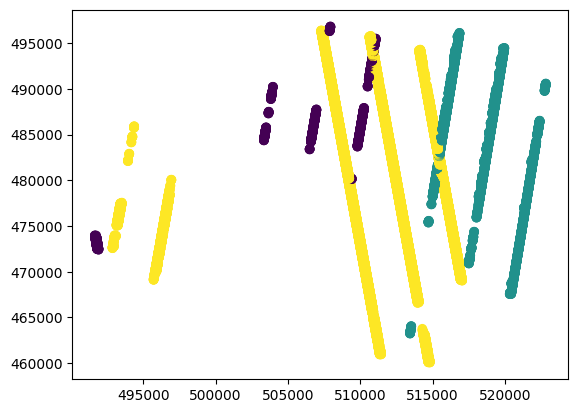

In [ ]:
plt.scatter(gdf1['x'], gdf1['y'], c = gdf1['month'])

Text(0.5, 1.0, '2015 SPR')

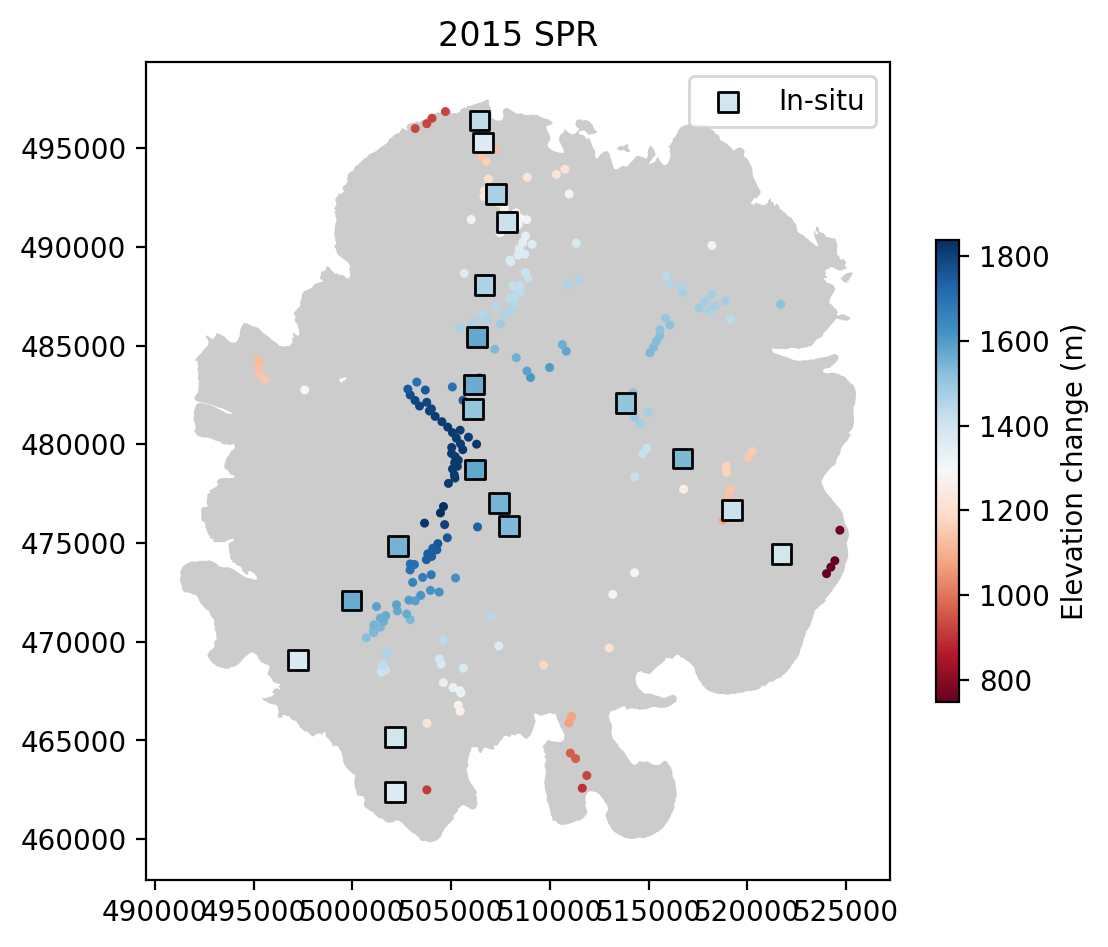

In [ ]:
y = 2015
season = "spr"
file3 = f"drive/MyDrive/Colab Notebooks/Iceland/Data_glacier/CS2_glacier_{y}_{season}.csv"
if os.path.exists(file3):
  cs2 = True
  df3 = pd.read_csv(file3, index_col = 0)
  gdf3 = gpd.GeoDataFrame(df3, geometry=gpd.points_from_xy(df3.lon, df3.lat), crs="EPSG:4326").to_crs(3057)
  gdf3['h_diff'] = gdf3['h1'] - gdf3['mean']
  gdf3 = gdf3[abs(gdf3['h_diff']) < 10].reset_index(drop = True)

  gdf3['x'] = gdf3['geometry'].x
  gdf3['y'] = gdf3['geometry'].y


fig, ax = plt.subplots(1,1,figsize = (6,6), dpi = 200)

# # create the colorbar
# norm = colors.Normalize(vmin=-5, vmax=5)
# cbar = plt.cm.ScalarMappable(norm=divnorm, cmap='gist_earth_r')

shapefile.plot(ax = ax, color = "k", alpha = 0.2)

# gdf['rgt'] == 55
g_plot = gdf3.plot("h1", ax = ax, cmap = "RdBu", s = 5, legend = True, legend_kwds={"label": "Elevation change (m)", "shrink": 0.5})
# g_plot = gdf1.plot("h_mean", ax = ax, cmap = "RdBu", s = 5, legend = True, legend_kwds={"label": "Elevation change (m)", "shrink": 0.5})
gdf_insitu.plot(field[season], ax = ax, vmin = -5, vmax = 5, cmap = "RdBu", markersize = 50, edgecolors='black', marker = "s", label = "In-situ")

plt.legend()
plt.title(f"{y} {season.upper()}")

# ax_cbar = fig.colorbar(cbar, ax=ax)


['blt11' 'blt8' 'h18' 'hn10' 'hn11' 'hn12' 'hn13' 'hn14' 'hn15' 'hn16'
 'hn17' 'hsa11' 'hsa13' 'hsa15' 'hsa16' 'hsa17' 'hsa9' 'hsv13' 'hsv15'
 'hsv17']


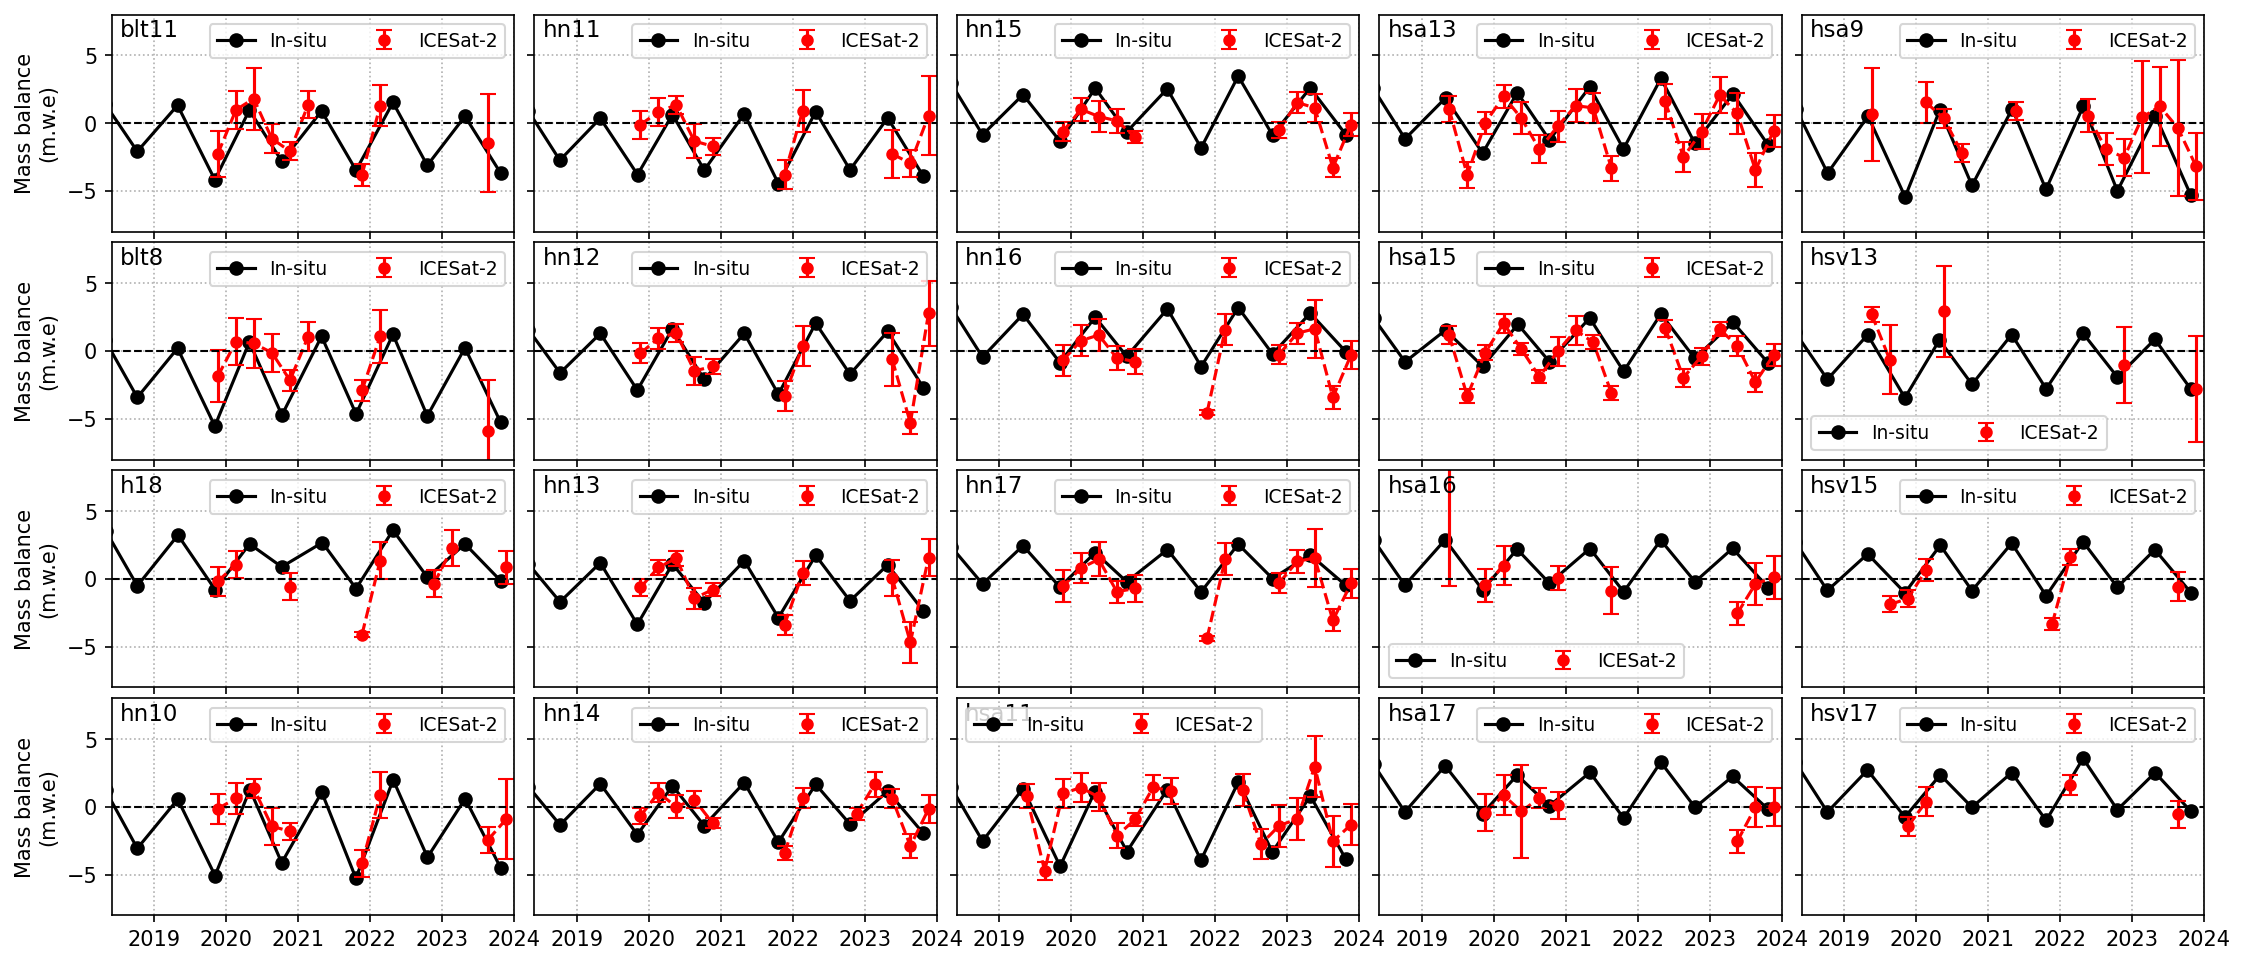

In [ ]:
print(keyList)

N = len(keyList)
fig, ax = plt.subplots(4, 5, figsize = (6*3, 2.6*3), dpi = 150, sharex = True, sharey= True)
fig.subplots_adjust(wspace = 0.05, hspace = 0.05)

df_compare = pd.DataFrame()

k = 0

for n, site in enumerate(keyList[:]):

  i = n % ax.shape[0]
  j = n // ax.shape[0]

  # print(i, j, n, site)

  df = dict_insitu[site]

  ax[i,j].plot(df['date'], df['balance'], color = "k", marker = "o", label = "In-situ")

  df1 = dict_is2[site]
  df2 = dict_is1[site]
  df3 = dict_cs2[site]

  for y in np.arange(2019, 2020):
    df_compare.loc[k, "site"] = site
    df_compare.loc[k, "ba_str"] = df.loc[df['year'] >= y, "ba_str"].mean()
    df_compare.loc[k, "ba_is2"] = df1.loc[(df1['year'] >= y) & ((df1['season']=="win") | (df1['season']=="win")), "h_balance"].mean() \
    + df1.loc[(df1['year'] >= y) & ((df1['season']=="sum") | (df1['season']=="sum")), "h_balance"].mean()

    k += 1

  if len(df1) > 0:
    df1.loc[abs(df1['h_balance']) > 10, 'h_balance'] = np.nan
    ax[i,j].plot(df1['date'], df1['h_balance'], color = "r", ls = "--")
    ax[i,j].errorbar(df1['date'], df1['h_balance'], df1['h_std'], fmt ='.', markersize = 10, color = "r", capsize=4, label = "ICESat-2")

  # if len(df2) > 0:
  #   df2.loc[abs(df2['h_balance']) > 10, 'h_balance'] = np.nan
  #   ax[i,j].plot(df2['date'], df2['h_balance'], color = "b", ls = "--")
  #   ax[i,j].errorbar(df2['date'], df2['h_balance'], df2['h_std'], fmt ='.', markersize = 10, color = "b", capsize=4, label = "ICESat")

  # if len(df3) > 0:
  #   df3.loc[abs(df3['h_balance']) > 10, 'h_balance'] = np.nan
  #   ax[i,j].plot(df3['date'], df3['h_balance'], color = "g", ls = "--")
  #   ax[i,j].errorbar(df3['date'], df3['h_balance'], df3['h_std']*0, fmt ='.', markersize = 10, color = "g", capsize=4, label = "CryoSat-2")

  ax[i,j].annotate(site, xy=(0.02,0.98), xycoords='axes fraction', fontsize=11,
                horizontalalignment='left', verticalalignment='top')
  ax[i,j].set_ylim(-8, 8)
  ax[i,j].grid(ls = ":")
  ax[i,j].legend(fontsize = 9, ncol = 2)

  ax[i,j].axhline(0, color = "k", ls = "--", lw = 1)

  ax[i,j].set_xlim(datetime(2018, 6, 1), datetime(2024, 1, 1))
  # ax.fill(df2['date'], df2['h_balance'], color = "r")

  if j == 0:
    ax[i,j].set_ylabel("Mass balance\n(m.w.e)")

In [ ]:
import numpy.ma as ma

def RMSE(prd, obs):
    err = np.square(obs-prd)
    return np.nanmean(err)**0.5

def corr(prd, obs):
    prd = prd.flatten()
    obs = obs.flatten()

    r = ma.corrcoef(ma.masked_invalid(prd), ma.masked_invalid(obs))[0, 1]
    return r

Text(0.03, 0.97, 'RMSE=2.03m')

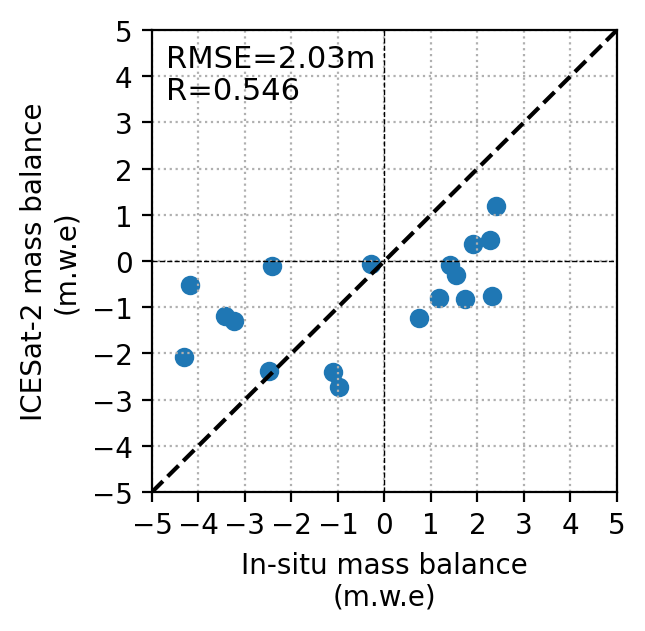

In [ ]:
plt.subplots(1,1, figsize = (3,3), dpi = 200)
plt.scatter(df_compare['ba_str'], df_compare['ba_is2'])
# plt.axis('scaled')
plt.grid(ls = ":")
plt.plot([-5, 5], [-5, 5], color = "k", ls = "--")
plt.xticks(np.arange(-5, 6, 1));
plt.yticks(np.arange(-5, 6, 1));
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.axhline(0, color = "k", ls = "--", lw = 0.5)
plt.axvline(0, color = "k", ls = "--", lw = 0.5)

rmse = RMSE(df_compare['ba_str'].values, df_compare['ba_is2'].values)
R = corr(df_compare['ba_str'].values, df_compare['ba_is2'].values)

plt.xlabel("In-situ mass balance\n(m.w.e)")
plt.ylabel("ICESat-2 mass balance\n(m.w.e)")

plt.annotate(f"R={R:.3f}", xy=(0.03, 0.90), xycoords='axes fraction', fontsize=11, ha='left', va='top')
plt.annotate(f"RMSE={rmse:.2f}m", xy=(0.03, 0.97), xycoords='axes fraction', fontsize=11, ha='left', va='top')

In [ ]:
df_compare

site  ba_str    ba_is2
0   blt11  -2.424 -0.104796
1    blt8  -4.310 -2.073383
2     h18   2.804       NaN
3    hn10  -3.432 -1.197769
4    hn11  -3.242 -1.291094
5    hn12  -0.974 -2.721499
6    hn13  -1.110 -2.411840
7    hn14  -0.288 -0.059569
8    hn15   1.532 -0.298209
9    hn16   2.322 -0.759909
10   hn17   1.736 -0.817340
11  hsa11  -2.474 -2.376663
12  hsa13   0.740 -1.239613
13  hsa15   1.182 -0.792440
14  hsa16   1.896  0.361180
15  hsa17   2.396  1.186321
16   hsa9  -4.178 -0.520577
17  hsv13  -1.610       NaN
18  hsv15   1.420 -0.085916
19  hsv17   2.276  0.445762

### Read ICESat data (2004-2008)

In [ ]:
df = pd.read_csv(f"drive/MyDrive/Colab Notebooks/Iceland/Data_glacier/IS_glacier.csv")
df['time'] = pd.to_datetime(df['Time'])
df['year'] = df['time'].dt.year
df['month'] = df['time'].dt.month
df['day'] = df['time'].dt.day

In [ ]:
df

Longitude   Latitude  Elevation                 Time  Track  \
0    -18.688814  64.610336    650.544  10/24/2003 03:14:29     31   
1    -18.690185  64.613388    651.481  10/24/2003 03:14:29     31   
2    -18.691549  64.616432    652.458  10/24/2003 03:14:29     31   
3    -18.692914  64.619484    653.911  10/24/2003 03:14:29     31   
4    -18.694275  64.622543    653.529  10/24/2003 03:14:30     31   
...         ...        ...        ...                  ...    ...   
2317 -18.871755  65.011040    892.895  10/08/2009 05:54:36     31   
2318 -18.873159  65.014091    896.834  10/08/2009 05:54:36     31   
2319 -18.874564  65.017143    895.973  10/08/2009 05:54:36     31   
2320 -18.875977  65.020203    892.790  10/08/2009 05:54:36     31   
2321 -18.877397  65.023247    891.225  10/08/2009 05:54:36     31   

                     Campaign  \
0     Laser 2A (Post Delta-T)   
1     Laser 2A (Post Delta-T)   
2     Laser 2A (Post Delta-T)   
3     Laser 2A (Post Delta-T)   
4     Laser 2A (Post Delta-T)   
...                       ...   
2317                 Laser 2F   
2318                 Laser 2F   
2319                 Laser 2F   
2320                 Laser 2F   
2321                 Laser 2F   

                                                   Link                time  \
0     https://n5eil01u.ecs.nsidc.org/opendap/GLAS/GL... 2003-10-24 03:14:29   
1     https://n5eil01u.ecs.nsidc.org/opendap/GLAS/GL... 2003-10-24 03:14:29   
2     https://n5eil01u.ecs.nsidc.org/opendap/GLAS/GL... 2003-10-24 03:14:29   
3     https://n5eil01u.ecs.nsidc.org/opendap/GLAS/GL... 2003-10-24 03:14:29   
4     https://n5eil01u.ecs.nsidc.org/opendap/GLAS/GL... 2003-10-24 03:14:30   
...                                                 ...                 ...   
2317  https://n5eil01u.ecs.nsidc.org/opendap/GLAS/GL... 2009-10-08 05:54:36   
2318  https://n5eil01u.ecs.nsidc.org/opendap/GLAS/GL... 2009-10-08 05:54:36   
2319  https://n5eil01u.ecs.nsidc.org/opendap/GLAS/GL... 2009-10-08 05:54:36   
2320  https://n5eil01u.ecs.nsidc.org/opendap/GLAS/GL... 2009-10-08 05:54:36   
2321  https://n5eil01u.ecs.nsidc.org/opendap/GLAS/GL... 2009-10-08 05:54:36   

      year  month  day  
0     2003     10   24  
1     2003     10   24  
2     2003     10   24  
3     2003     10   24  
4     2003     10   24  
...    ...    ...  ...  
2317  2009     10    8  
2318  2009     10    8  
2319  2009     10    8  
2320  2009     10    8  
2321  2009     10    8  

[2322 rows x 11 columns]

In [ ]:
years = np.arange(2003, 2009)
months = { 'win': ['12', '01', '02'], 'spr': ['03', '04', '05'], 'sum': ['06', '07', '08'], 'aut': ['09', '10', '11']}

for season in months.keys():
  for y in years:

    first = True

    for m in months[season]:
      if m =="12":
        ny = y - 1 # for Dec, include the previous year Dec data (nominal year)
      else:
        ny = y

      df0 = df[(df['year'] == y) & (df['month'] == int(m))]

      if len(df0) > 0:

        if first:
          df2 = df0
          first = False
        else:
          df2 = pd.concat([df2, df0]).reset_index(drop = True)

    if first == False:
      df2.to_csv(f"drive/MyDrive/Colab Notebooks/Iceland/Data_glacier/IS_glacier_{y}_{season}.csv")

      print(y, season)

2004 win
2005 win
2008 win
2004 spr
2005 spr
2006 spr
2007 spr
2008 spr
2006 sum
2003 aut
2005 aut
2006 aut
2007 aut
2008 aut


### Read CryoSat-2 data (2010-2024)

In [ ]:
import xarray as xr

In [ ]:
cs2_files = sorted(glob.glob(f"drive/MyDrive/Colab Notebooks/Iceland/CS2/*_SIN_2_*{ny}{m}.nc"))

In [ ]:

files_season = []
years = np.arange(2010, 2024)
months = { 'win': ['12', '01', '02'], 'spr': ['03', '04', '05'], 'sum': ['06', '07', '08'], 'aut': ['09', '10', '11']}

for season in months.keys():
  for y in years:

    first = True

    for m in months[season]:
      if m =="12":
        ny = y - 1 # for Dec, include the previous year Dec data (nominal year)
      else:
        ny = y
      files = glob.glob(f"drive/MyDrive/Colab Notebooks/Iceland/CS2/*_SIN_2__{ny}{m}*.nc")

      for f in tqdm(files):
        ds0 = xr.open_dataset(f)

        lat = ds0.lat_poca_20_ku.values
        lon = ds0.lon_poca_20_ku.values
        times = ds0.time_20_ku.values

        h1 = ds0.height_1_20_ku.values
        h2 = ds0.height_2_20_ku.values
        h3 = ds0.height_3_20_ku.values

        df0 = pd.DataFrame({'time': times, 'lat': lat, 'lon': lon, 'h1': h1, 'h2': h2, 'h3': h3})

        if first:
          df = df0
          first = False
        else:
          df = pd.concat([df, df0]).reset_index(drop = True)

    if first == False:

      df['year'] = df['time'].dt.year
      df['month'] = df['time'].dt.month
      df['day'] = df['time'].dt.day

      gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat), crs="EPSG:4326") #.to_crs(3057)
      gdf = gdf.clip(gdf_glacier)

      gdf_fc = geemap.geopandas_to_ee(gdf.loc[:, ['year', 'month', 'day', 'h1', 'h2', 'h3', 'lat', 'lon', 'geometry']])

      fc_samp = DEM2020.reduceRegions(collection=gdf_fc, reducer=ee.Reducer.mean(), scale=20)
      gdf2 = geemap.ee_to_gdf(fc_samp)

      gdf2 = gdf2[gdf2['mean'] > 0].reset_index(drop = True)

      gdf2.to_csv(f"drive/MyDrive/Colab Notebooks/Iceland/Data_glacier/CS2_glacier_{y}_{season}.csv")

    print(y, season)

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


2010 win


100%|██████████| 3/3 [00:01<00:00,  1.53it/s]


2011 win


100%|██████████| 4/4 [00:02<00:00,  1.57it/s]


2012 win


100%|██████████| 4/4 [00:01<00:00,  2.61it/s]


2013 win


100%|██████████| 2/2 [00:00<00:00,  2.27it/s]


2014 win


100%|██████████| 4/4 [00:01<00:00,  2.95it/s]


2015 win


100%|██████████| 3/3 [00:01<00:00,  2.39it/s]


2016 win


100%|██████████| 4/4 [00:01<00:00,  3.10it/s]


2017 win


100%|██████████| 7/7 [00:02<00:00,  2.71it/s]


2018 win


100%|██████████| 4/4 [00:01<00:00,  3.46it/s]


2019 win


100%|██████████| 8/8 [00:02<00:00,  3.46it/s]


2020 win


100%|██████████| 2/2 [00:00<00:00,  3.57it/s]


2021 win


100%|██████████| 3/3 [00:01<00:00,  2.88it/s]


2022 win


100%|██████████| 2/2 [00:00<00:00,  2.16it/s]


2023 win


0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


2010 spr


100%|██████████| 4/4 [00:01<00:00,  3.02it/s]


2011 spr


100%|██████████| 2/2 [00:01<00:00,  1.70it/s]


2012 spr


100%|██████████| 5/5 [00:01<00:00,  3.25it/s]


2013 spr


100%|██████████| 3/3 [00:01<00:00,  1.93it/s]


2014 spr


100%|██████████| 5/5 [00:01<00:00,  2.86it/s]


2015 spr


100%|██████████| 3/3 [00:01<00:00,  2.82it/s]


2016 spr


100%|██████████| 3/3 [00:00<00:00,  3.51it/s]


2017 spr


100%|██████████| 3/3 [00:00<00:00,  3.55it/s]


2018 spr


100%|██████████| 4/4 [00:01<00:00,  2.36it/s]


2019 spr


100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


2020 spr


100%|██████████| 2/2 [00:00<00:00,  3.32it/s]


2021 spr


100%|██████████| 2/2 [00:00<00:00,  3.34it/s]


2022 spr


100%|██████████| 4/4 [00:02<00:00,  1.91it/s]


2023 spr


0it [00:00, ?it/s]
100%|██████████| 4/4 [00:01<00:00,  3.39it/s]
0it [00:00, ?it/s]


2010 sum


100%|██████████| 4/4 [00:01<00:00,  2.87it/s]


2011 sum


100%|██████████| 5/5 [00:02<00:00,  2.44it/s]


2012 sum


100%|██████████| 5/5 [00:01<00:00,  3.40it/s]


2013 sum


100%|██████████| 3/3 [00:01<00:00,  2.15it/s]


2014 sum


100%|██████████| 4/4 [00:01<00:00,  3.25it/s]


2015 sum


100%|██████████| 3/3 [00:01<00:00,  2.61it/s]


2016 sum


100%|██████████| 4/4 [00:01<00:00,  3.13it/s]


2017 sum


100%|██████████| 4/4 [00:01<00:00,  2.13it/s]


2018 sum


100%|██████████| 5/5 [00:01<00:00,  3.42it/s]


2019 sum


100%|██████████| 6/6 [00:02<00:00,  2.40it/s]


2020 sum


100%|██████████| 2/2 [00:00<00:00,  3.45it/s]


2021 sum


100%|██████████| 5/5 [00:02<00:00,  2.28it/s]


2022 sum


100%|██████████| 6/6 [00:02<00:00,  2.83it/s]


2023 sum


100%|██████████| 2/2 [00:00<00:00,  2.18it/s]


2010 aut


100%|██████████| 3/3 [00:00<00:00,  3.37it/s]


2011 aut


100%|██████████| 6/6 [00:02<00:00,  2.58it/s]


2012 aut


100%|██████████| 3/3 [00:01<00:00,  2.79it/s]


2013 aut


100%|██████████| 3/3 [00:00<00:00,  3.37it/s]


2014 aut


100%|██████████| 5/5 [00:01<00:00,  2.62it/s]


2015 aut


100%|██████████| 4/4 [00:01<00:00,  3.20it/s]


2016 aut


100%|██████████| 4/4 [00:01<00:00,  2.14it/s]


2017 aut


100%|██████████| 4/4 [00:01<00:00,  3.56it/s]


2018 aut


100%|██████████| 4/4 [00:01<00:00,  3.22it/s]


2019 aut


100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


2020 aut


100%|██████████| 7/7 [00:06<00:00,  1.07it/s]


2021 aut


100%|██████████| 3/3 [00:01<00:00,  2.90it/s]


2022 aut


100%|██████████| 4/4 [00:01<00:00,  2.32it/s]


2023 aut


<Axes: >

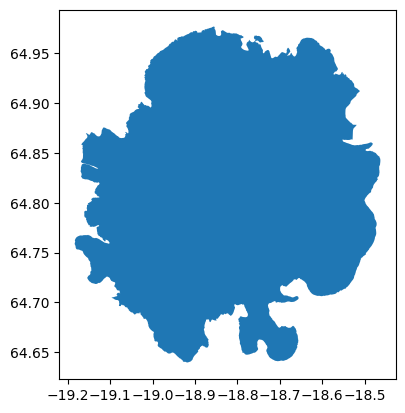

In [ ]:
gdf_glacier.plot()

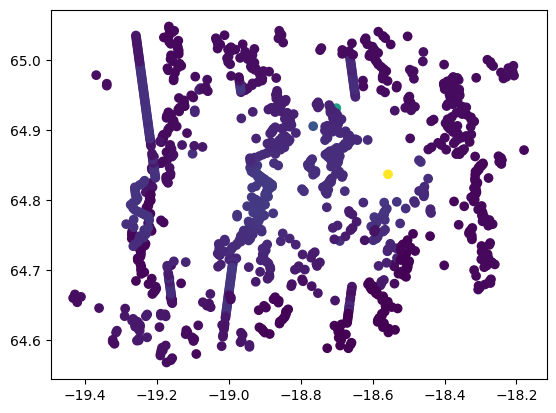

In [ ]:
plt.scatter(df.lon, df.lat, c = df['h1'])

In [ ]:
ny = 2012
m = "05"
files = glob.glob(f"drive/MyDrive/Colab Notebooks/Iceland/CS2/*SIN*{ny}{m}*.nc")

files

['drive/MyDrive/Colab Notebooks/Iceland/CS2/CS_LTA__SIR_SIN_2__20120506T055510_20120506T055601_E001_segment_84.nc',
 'drive/MyDrive/Colab Notebooks/Iceland/CS2/CS_LTA__SIR_SIN_2__20120508T171328_20120508T171414_E001_segment_85.nc']

In [ ]:
ds0

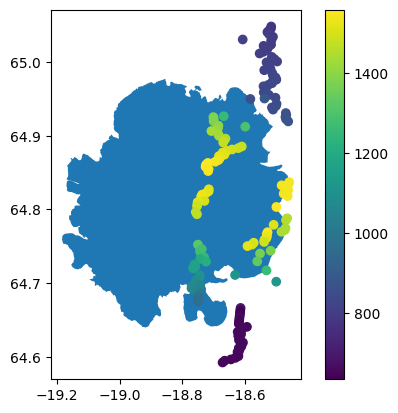

In [ ]:
ds0 = xr.open_dataset(files[0])

lat = ds0.lat_poca_20_ku.values
lon = ds0.lon_poca_20_ku.values
times = ds0.time_20_ku.values

h1 = ds0.height_1_20_ku.values
h2 = ds0.height_2_20_ku.values
h3 = ds0.height_3_20_ku.values

gdf_glacier.plot()
plt.scatter(lon, lat, c = h1)
plt.colorbar()

In [ ]:
ds0

<xarray.Dataset> Size: 38kB
Dimensions:                           (time_cor_01: 8, time_20_ku: 170)
Coordinates:
    lat_01                            (time_cor_01) float64 64B ...
    lat_poca_20_ku                    (time_20_ku) float64 1kB ...
    lon_01                            (time_cor_01) float64 64B ...
    lon_poca_20_ku                    (time_20_ku) float64 1kB ...
  * time_20_ku                        (time_20_ku) datetime64[ns] 1kB 2012-05...
  * time_cor_01                       (time_cor_01) datetime64[ns] 64B 2012-0...
Data variables: (12/54)
    alt_01                            (time_cor_01) float64 64B ...
    echo_avg_numval_20_ku             (time_20_ku) float32 680B ...
    flag_cor_applied_20_ku            (time_20_ku) float64 1kB ...
    flag_cor_err_01                   (time_cor_01) float64 64B ...
    flag_instr_conf_rx_str_in_use_01  (time_cor_01) float32 32B ...
    flag_instr_mode_op_20_ku          (time_20_ku) float32 680B ...
    ...                                ...
    ssha_interp_20_ku                 (time_20_ku) float64 1kB ...
    ssha_interp_numval_20_ku          (time_20_ku) float32 680B ...
    ssha_interp_rms_20_ku             (time_20_ku) float64 1kB ...
    surf_type_20_ku                   (time_20_ku) float32 680B ...
    swh_ocean_01_ku                   (time_cor_01) float64 64B ...
    wind_speed_alt_01_ku              (time_cor_01) float64 64B ...
Attributes: (12/102)
    product_name:                 CS_LTA__SIR_SIN_2__20120506T055510_20120506...
    processing_stage:             LTA_
    reference_document:           CS-RS-ACS-ESL-5265 2.1
    doi:                          10.5270/CR2-65cff05
    acquisition_station:          Kiruna              
    mission:                      Cryosat
    ...                           ...
    xref_surf_type:               CS_OPER_AUX_LS_MAP_00000000T000000_99999999...
    xref_tidal_load:              CS_OPER_AUX_TDLOAD_00000000T000000_99999999...
    xref_u_wind:                  CS_OPER_AUX_U_WIND_20120506T000000_20120506...
    xref_uso:                     CS_OPER_AUX_DORUSO_20100411T040029_20211117...
    xref_v_wind:                  CS_OPER_AUX_V_WIND_20120506T000000_20120506...
    xref_wet_trop:                CS_OPER_AUX_WETTRP_20120506T000000_20120506...

In [ ]:
h2

array([726145.696, 726158.225, 726170.745, 726183.253, 726195.742,
       726208.216, 726220.681, 726233.141])

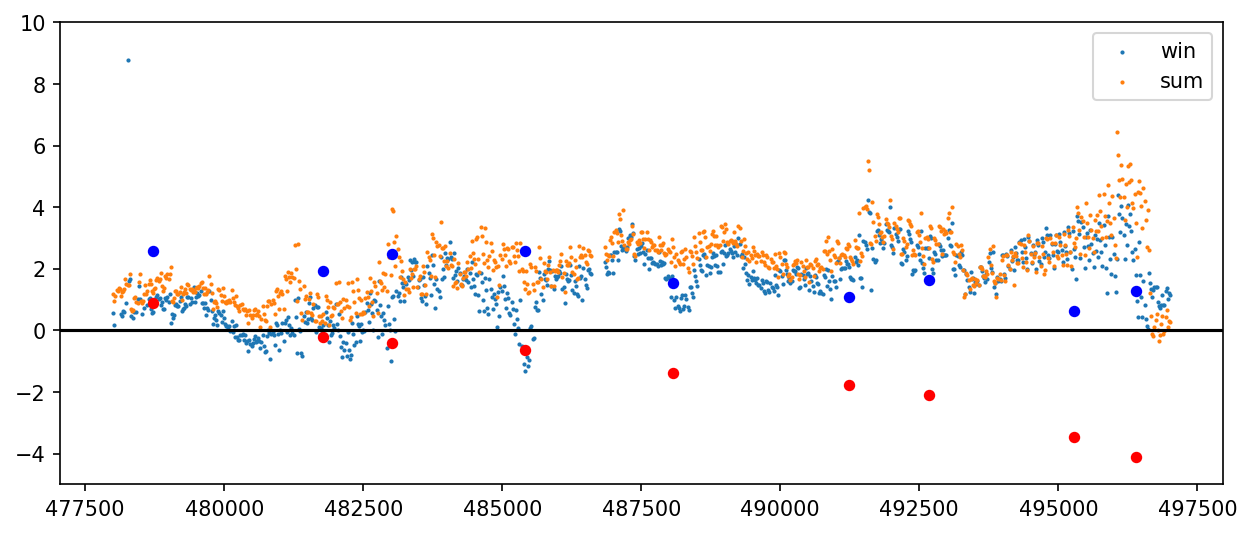

In [ ]:
y = 2020
gdf_out = gdf_insitu.copy()

points = ["hn10", "hn11", "hn12", "hn13", "hn14", "hn15", "hn16", "hn17", "h18"]
field = {"win": "bw_str", "spr": "bw_str", "sum": "bs_str",  "aut": "bs_str"}

fig, ax = plt.subplots(1,1, figsize = (10,4), dpi = 150)

for season in ["win", "sum"]:

  # Read ICESat-2 data
  df = pd.read_csv(f"drive/MyDrive/Colab Notebooks/Iceland/Data_glacier/SR_glacier_{y}_{season}.csv", index_col = 0)
  df = df[df['mean'] > 0].reset_index(drop = True)
  gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat), crs="EPSG:4326").to_crs(3057)

  gdf['x'] = gdf['geometry'].x
  gdf['y'] = gdf['geometry'].y

  gdf2 = gdf[(gdf['y'] > 478000) & (gdf['y'] < 498000) & (gdf['rgt'] == 55) & (gdf['gt'] == 40)]

  # Read in-intu glacier data
  insitu = pd.read_csv(f"drive/MyDrive/Colab Notebooks/Iceland/Data_insitu/hst-{y}.csv") #.reset_index(drop = False)
  gdf_insitu = gpd.GeoDataFrame(insitu, geometry=gpd.points_from_xy(insitu.x, insitu.y), crs="EPSG:3057")

  fields = ['#stake', 'ar', 'x', 'y', 'd1', 'd2', 'd3', 'ds', 'dw', 'bw_str', 'bs_str', 'ba_str', 'bw_fld', 'bs_fld', 'ba_fld', 'geometry']
  gdf_insitu = gdf_insitu[fields]

  plt.scatter(gdf2['y'], gdf2['h_diff'], label = season, s=1)
  gdf_out = compare_insitu(gdf_out, gdf, season, buf = 4000, points = points)

gdf_out = gdf_out[gdf_out['select']]

plt.scatter(gdf_out['y'], gdf_out['bw_str'], s = 20, c = "b")
plt.scatter(gdf_out['y'], gdf_out['bs_str'], s = 20, c = "r")

ax.axhline(0, color = "k")
plt.ylim(-5,  10)
# plt.ylim()

plt.legend()

In [ ]:
gdf

NameError: name 'gdf' is not defined

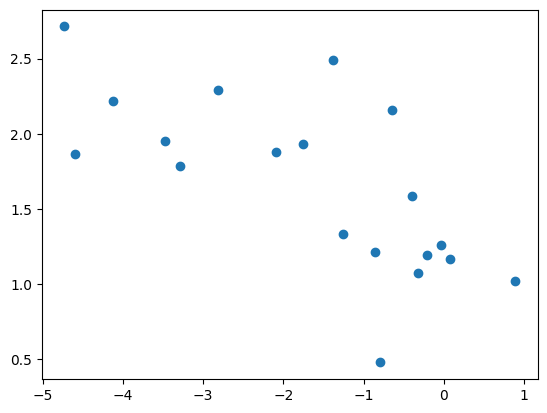

In [ ]:
plt.scatter(gdf_out['bs_str'], gdf_out['h_mean_sum'])

Text(0.5, 1.0, '2020 SUM')

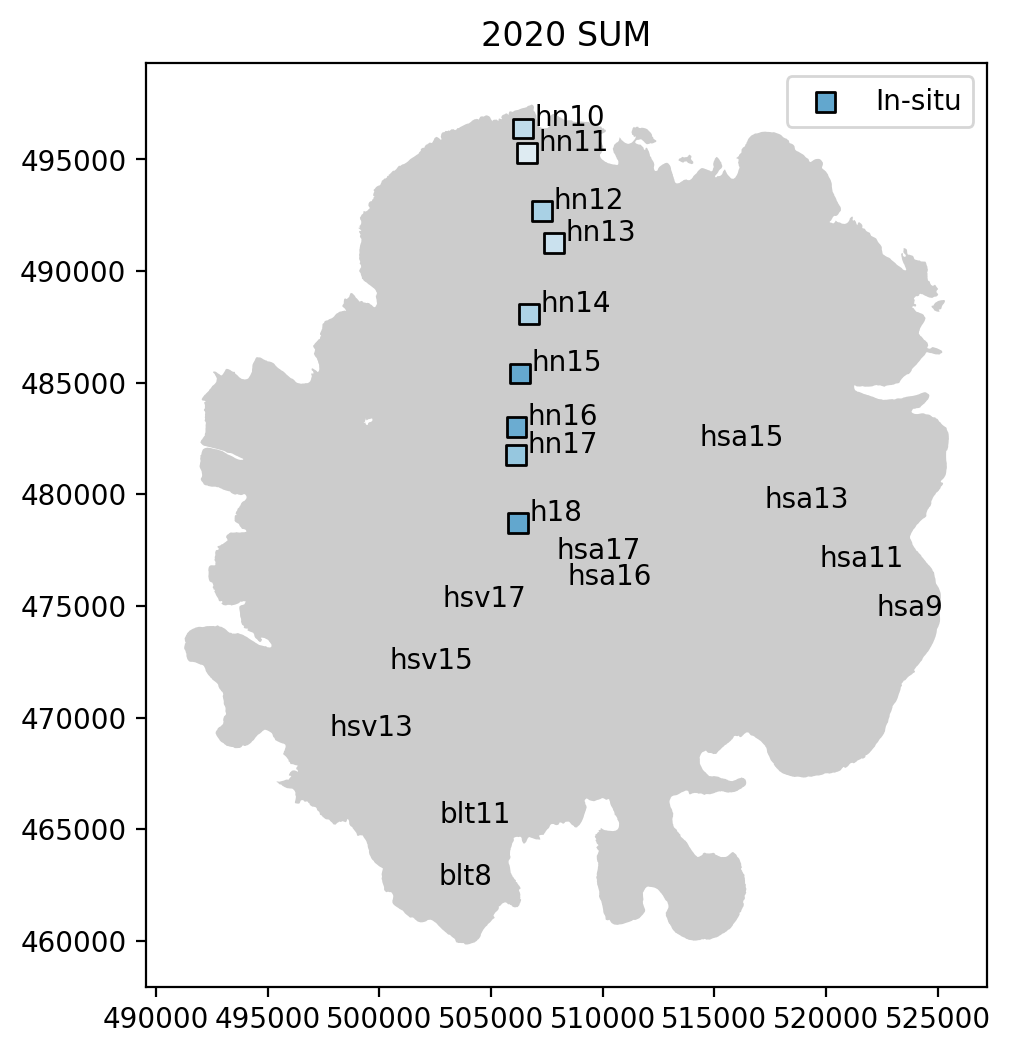

In [ ]:
fig, ax = plt.subplots(1,1,figsize = (6,6), dpi = 200)

# # create the colorbar
# norm = colors.Normalize(vmin=-5, vmax=5)
# cbar = plt.cm.ScalarMappable(norm=divnorm, cmap='gist_earth_r')

shapefile.plot(ax = ax, color = "k", alpha = 0.2)
# gdf.plot("h_diff", ax = ax, vmin = -5, vmax = 5, cmap = "RdBu", markersize = 50, edgecolors='black', marker = "s", label = "In-situ")
# gdf_out['bs_is2'] = gdf_out['h_mean_sum'] - gdf_out['h_mean_win']
# gdf_out['bw_is2'] = gdf_out['h_mean_win'] - gdf_out['h_mean_sum']
gdf_out.plot("bw_str", ax = ax, vmin = -5, vmax = 5, cmap = "RdBu", markersize = 50, edgecolors='black', marker = "s", label = "In-situ")

points = ["hn10", "hn11", "hn12", "hn13", "hn14", "hn15", "hn16", "hn17", "h18"]
for i in range(0, len(gdf_insitu)):
  plt.text(gdf_insitu.loc[i, "x"]+500, gdf_insitu.loc[i, "y"]+100, gdf_insitu.loc[i, "#stake"])

plt.legend()
plt.title(f"{y} {season.upper()}")

# ax_cbar = fig.colorbar(cbar, ax=ax)

In [ ]:
gdf

geometry  day  gt      h_mean   h_sigma  \
0      POINT (513154.197 460487.448)   28  50  692.167022  0.042339   
1      POINT (513156.295 460507.503)   28  50  691.220328  0.115768   
2      POINT (513158.341 460527.058)   28  50  690.580155  0.109872   
3      POINT (513160.427 460546.965)   28  50  690.959892  0.096684   
4      POINT (513162.513 460566.871)   28  50  691.478508  0.091526   
...                              ...  ...  ..         ...       ...   
11472  POINT (519943.577 494493.934)   28  30  865.170898  0.062985   
11473  POINT (519857.002 494502.905)   28  40  863.149106  0.039395   
11474  POINT (519858.925 494522.828)   28  40  862.659305  0.084849   
11475   POINT (519860.83 494542.754)   28  40  861.286963  0.053882   
11476  POINT (519862.755 494562.677)   28  40  860.248041  0.036574   

             lat        lon        mean  month  rgt       x_atc        y_atc  \
0      64.645310 -18.724789  691.265015      4  497  12864808.0 -3192.888700   
1      64.645490 -18.724744  690.645752      4  497  12864788.0 -3192.884500   
2      64.645666 -18.724699  690.414062      4  497  12864768.0 -3192.880900   
3      64.645844 -18.724654  690.358154      4  497  12864748.0 -3192.873500   
4      64.646023 -18.724608  691.071838      4  497  12864728.0 -3192.865700   
...          ...        ...         ...    ...  ...         ...          ...   
11472  64.950013 -18.577997  864.171387      4  497  12830278.0    40.008163   
11473  64.950099 -18.579827  862.925049      4  497  12830278.0   -47.037926   
11474  64.950278 -18.579784  863.217834      4  497  12830258.0   -47.181374   
11475  64.950456 -18.579741  860.197021      4  497  12830238.0   -47.342911   
11476  64.950635 -18.579697  859.741821      4  497  12830218.0   -47.484726   

       year    h_diff              x              y  
0      2020  0.902008  513154.197423  460487.448481  
1      2020  0.574576  513156.295398  460507.503288  
2      2020  0.166093  513158.340745  460527.058426  
3      2020  0.601738  513160.426526  460546.965063  
4      2020  0.406669  513162.512548  460566.871466  
...     ...       ...            ...            ...  
11472  2020  0.999511  519943.577174  494493.934304  
11473  2020  0.224058  519857.002395  494502.904507  
11474  2020 -0.558530  519858.925292  494522.828268  
11475  2020  1.089942  519860.830192  494542.753898  
11476  2020  0.506220  519862.754702  494562.677492  

[11477 rows x 16 columns]

In [ ]:
y = 2021
season = "spr"

# Read ICESat-2 data
df = pd.read_csv(f"drive/MyDrive/Colab Notebooks/Iceland/Data_glacier/SR_glacier_{y}_{season}.csv", index_col = 0)
df = df[df['mean'] > 0].reset_index(drop = True)
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat), crs="EPSG:4326").to_crs(3057)
gdf = gdf[abs(gdf['h_diff']) < 20].reset_index(drop = True)

gdf['x'] = gdf['geometry'].x
gdf['y'] = gdf['geometry'].y

# Read in-intu glacier data
insitu = pd.read_csv(f"drive/MyDrive/Colab Notebooks/Iceland/Data_insitu/hst-{y}.csv") #.reset_index(drop = False)
gdf_insitu = gpd.GeoDataFrame(insitu, geometry=gpd.points_from_xy(insitu.x, insitu.y), crs="EPSG:3057")

Text(0.5, 1.0, '2021 SPR')

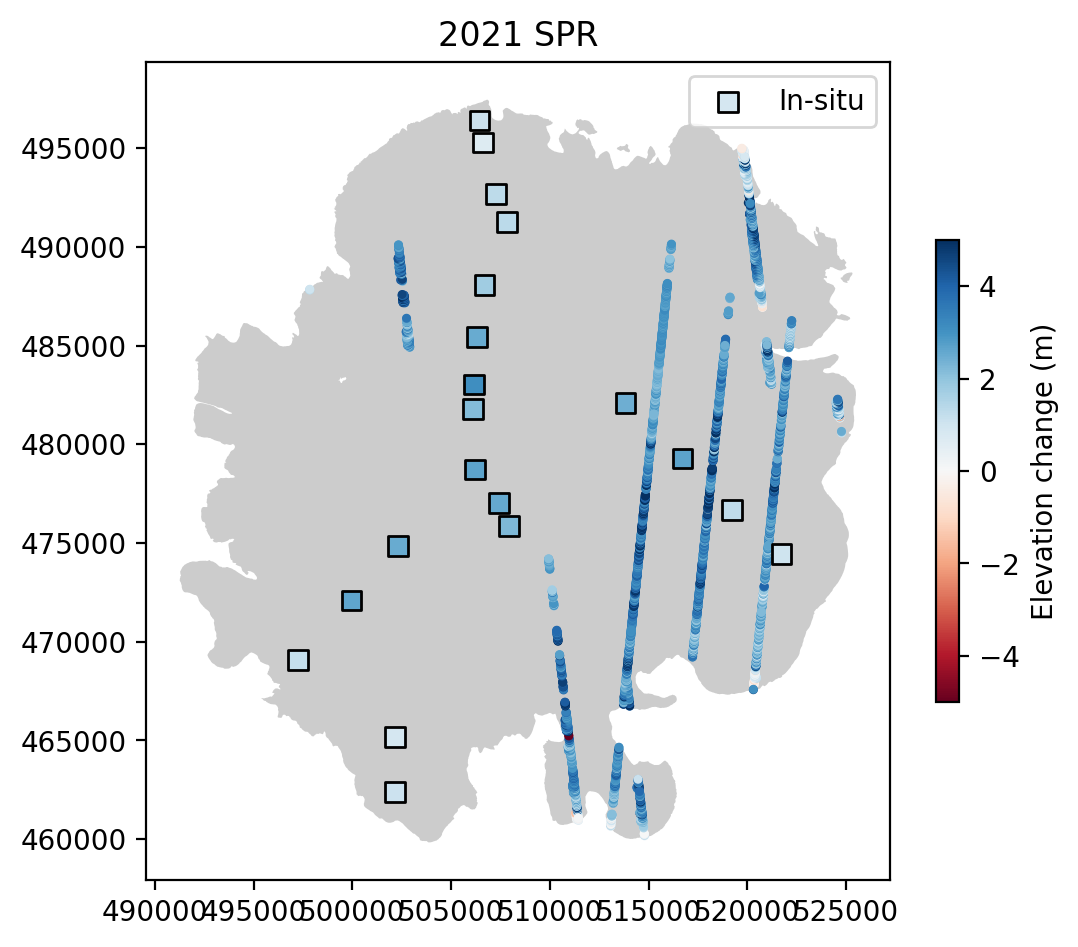

In [ ]:
fig, ax = plt.subplots(1,1,figsize = (6,6), dpi = 200)

# # create the colorbar
# norm = colors.Normalize(vmin=-5, vmax=5)
# cbar = plt.cm.ScalarMappable(norm=divnorm, cmap='gist_earth_r')

shapefile.plot(ax = ax, color = "k", alpha = 0.2)

# gdf['rgt'] == 55
g_plot = gdf.plot("h_diff", ax = ax, vmin = -5, vmax = 5, cmap = "RdBu", s = 5, legend = True, legend_kwds={"label": "Elevation change (m)", "shrink": 0.5})
gdf_insitu.plot(field[season], ax = ax, vmin = -5, vmax = 5, cmap = "RdBu", markersize = 50, edgecolors='black', marker = "s", label = "In-situ")

plt.legend()
plt.title(f"{y} {season.upper()}")

# ax_cbar = fig.colorbar(cbar, ax=ax)

Text(0, 0.5, 'Mass balance (m.w.e)')

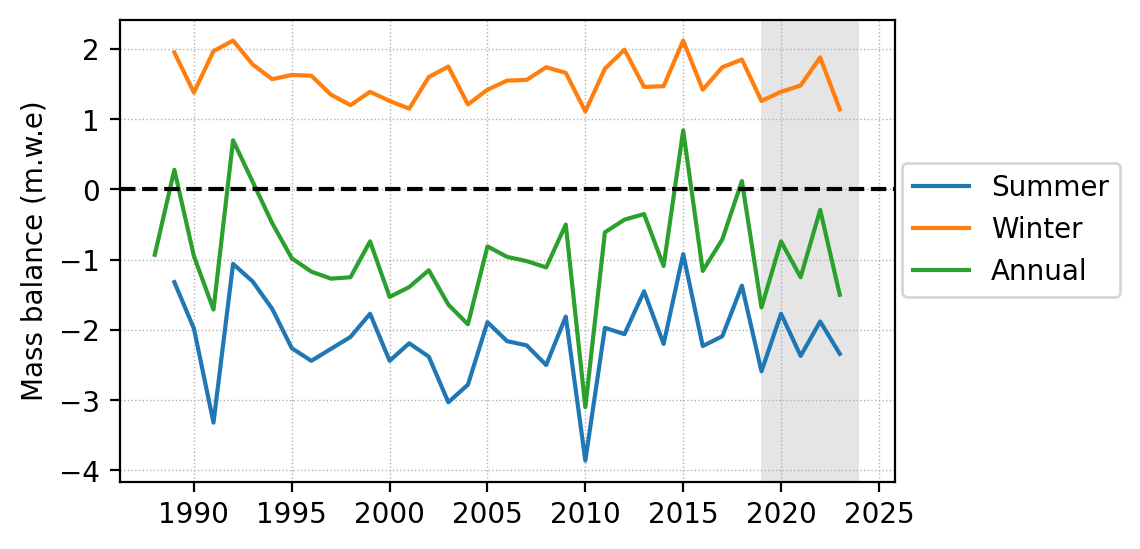

In [ ]:
df_meas = pd.read_csv(f"drive/MyDrive/Colab Notebooks/Iceland/glacier-mass-balance.csv", skiprows = 1)

plt.figure(figsize = (5,3), dpi = 200)
plt.plot(df_meas['yr'], df_meas['bs'], label = "Summer")
plt.plot(df_meas['yr'], df_meas['bw'], label = "Winter")
plt.plot(df_meas['yr'], df_meas['ba'], label = "Annual")
plt.legend(loc = (1.01,0.4))

plt.axvspan(2019, 2024, alpha=0.2, facecolor = 'gray')

plt.axhline(0, color = "k", ls = "--")
plt.grid(ls = ":", lw = 0.5)
plt.ylabel("Mass balance (m.w.e)")

In [ ]:
df_meas.head(5)

glims_id    yr    bw    bs    ba     ela
0  G341164E64838N  1988   NaN   NaN -0.93     NaN
1  G341164E64838N  1989  1.95 -1.32  0.28  1124.0
2  G341164E64838N  1990  1.38 -1.98 -0.95  1269.0
3  G341164E64838N  1991  1.97 -3.32 -1.71  1365.0
4  G341164E64838N  1992  2.12 -1.06  0.70  1111.0

Text(0, 0.5, '$\\Delta$h relative to 2020 DEM (m)')

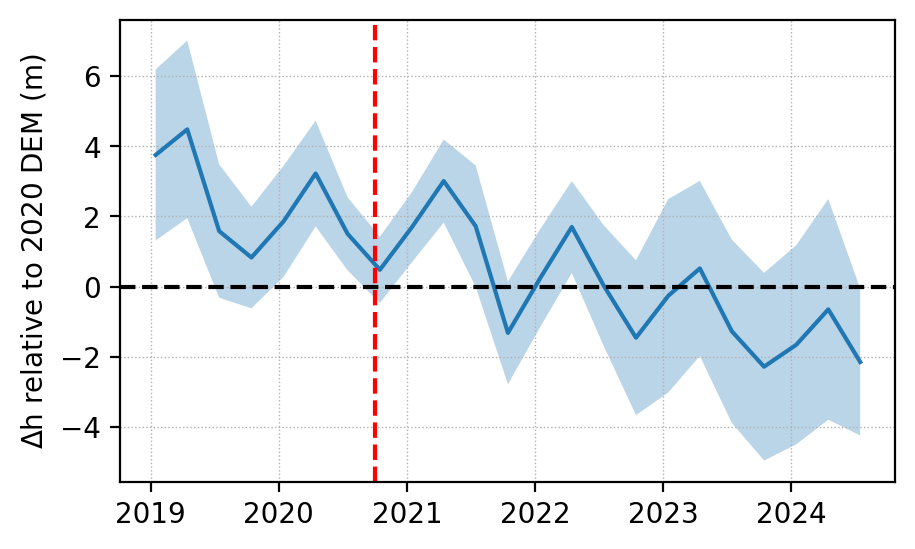

In [ ]:
plt.figure(figsize = (5,3), dpi = 200)
plt.plot(df_season['date'], df_season['h_diff_mean'])
# plt.plot(df_season['date'], df_season['h_diff_min'])
# plt.plot(df_season['date'], df_season['h_diff_max'])
plt.fill_between(df_season['date'], df_season['h_diff_mean']-df_season['h_diff_std'], df_season['h_diff_mean']+df_season['h_diff_std'], alpha = 0.3)
plt.axhline(0, color = "k", ls = "--")
plt.axvline(datetime(2020,10,1), color = "r", ls = "--")
plt.grid(ls = ":", lw = 0.5)
plt.ylabel("$\Delta$h relative to 2020 DEM (m)")

In [ ]:
plt.plot(gdf['lat'], gdf['h_mean'], '.')
plt.plot(gdf['lat'], gdf['mean'], '.')

In [ ]:
gdf_glacier.plot(color = "gray", alpha = 0.5)
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat), crs="EPSG:4326")
gdf = gdf.clip(gdf_glacier)
# Plot ICESat-2 height
plt.scatter(gdf['lon'], gdf['lat'], c=gdf["h_diff"], cmap='RdBu', s=1.0, zorder=3, vmin = -2, vmax = 2)
plt.colorbar(label = "IS2 elevation (m)");

In [ ]:
gdf_clip = gdf.clip(gdf_glacier)
gdf_clip

In [ ]:
gdf

In [ ]:
plt.plot(gdf['geometry'])

In [ ]:
from shapely.geometry import Point, Polygon
import geopandas

polys = geopandas.GeoSeries({
    'foo': Polygon([(5, 5), (5, 13), (13, 13), (13, 5)]),
    'bar': Polygon([(10, 10), (10, 15), (15, 15), (15, 10)]),
})

_pnts = [Point(3, 3), Point(8, 8), Point(11, 11)]
pnts = geopandas.GeoDataFrame(geometry=_pnts, index=['A', 'B', 'C'])
pnts = pnts.assign(**{key: pnts.within(geom) for key, geom in polys.items()})

print(pnts)

In [ ]:
polys

In [ ]:
# Plot ICESat-2 height
plt.scatter(df['lon'], df['lat'], c=df["h_diff"], cmap='jet', s=1.0, zorder=3, vmin = -2, vmax = 2)
plt.colorbar(label = "IS2 elevation (m)");

In [ ]:
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat), crs="EPSG:4326")

In [ ]:
s = gdf.intersection(gdf_glacier)

In [ ]:
s

## Draw maps

In [ ]:
fig, ax = fig, ax = plt.subplots(1, 4, figsize=(10, 2.5), dpi= 200, subplot_kw={'projection': projection})

In [ ]:
%pip install rasterio

In [ ]:
import rasterio

In [ ]:
# plot deformation on top of the SAR image

img = rasterio.open(f"drive/MyDrive/Colab Notebooks/Iceland/Data_glacier/hofs_mos_oct2020_mgm_2x2m_isn93_zmae.tif")
a1 = img.read(1)
img.close()

plt.figure(figsize=(8, 8), dpi = 180)
ax = plt.axes(projection=crs)

ax.imshow(a1, cmap='terrain', origin='upper')

plt.show()

In [ ]:
import pyproj
lon = -74.6604194
lat = 40.3450248
alt = 50

transformer = pyproj.Transformer.from_crs("EPSG:4326", "EPSG:4978", always_xy = True)
print(transformer)
xyz = transformer.transform(lon, lat, alt)
print('Projected XY', xyz)
lonlat = transformer.transform(xyz[0], xyz[1], xyz[2], direction='INVERSE')
print('Lon Lat', lonlat)

In [ ]:
import pyproj
lon = -19.500027  #-19.500027	64.755247
lat = 64.755247
alt = 650

transformer = pyproj.Transformer.from_crs("EPSG:4326", "EPSG:3057", always_xy = False)
print(transformer)
xyz = transformer.transform(lon, lat, alt)
print('Projected XY', xyz)
lonlat = transformer.transform(xyz[0], xyz[1], xyz[2], direction='INVERSE')
print('Lon Lat', lonlat)

In [ ]:
from pyproj import CRS, Geod
geod_clrk = Geod(ellps='clrk66') # Use Clarke 1866 ellipsoid.
geod_clrk
Geod(ellps='clrk66')
geod_wgs84 = CRS("EPSG:4326").get_geod()
geod_wgs84

In [ ]:
a1.keys()

In [ ]:
wdm = pyproj.Proj(init="EPSG:3057") #EPSG:3057
wgs = pyproj.Proj(init="EPSG:4326")
print(pyproj.transform(wdm, wgs, 7219120.5, 44.057457, 575.380371))
# print(pyproj.transform(wgs, wdm, 34.68016909181368, 38.31245226053967))

In [ ]:
gdf_a1 = geemap.geopandas_to_ee(a1.loc[:, ['y_atc', 'x_atc', 'h_mean', 'gt', 'rgt', 'lat', 'lon', 'geometry']])
gdf_a2 = geemap.geopandas_to_ee(a2.loc[:, ['y_atc', 'x_atc', 'h_mean', 'gt', 'rgt', 'lat', 'lon', 'geometry']])

In [ ]:
# Sampling
fc_samp_isn93 = DEM_10m_isn93.reduceRegions(
    collection=gdf_fc, reducer=ee.Reducer.mean(), scale=20
)

gdf_isn93 = geemap.ee_to_df(fc_samp_isn93)

In [ ]:
# Sampling
fc_offset = DEM_diff.reduceRegions(
    collection=gdf_fc, reducer=ee.Reducer.mean(), scale=20
)

gdf_offset = geemap.ee_to_df(fc_offset)

In [ ]:


# Sampling
fc_a1 = DEM_10m_wgs84.reduceRegions(
    collection=gdf_a1, reducer=ee.Reducer.mean(), scale=20
)

gdf_a1 = geemap.ee_to_df(fc_a1)

# Sampling
fc_a2 = DEM_10m_wgs84.reduceRegions(
    collection=gdf_a2, reducer=ee.Reducer.mean(), scale=20
)

gdf_a2 = geemap.ee_to_df(fc_a2)



In [ ]:
gdf_a2

In [ ]:
gdf_samp = gdf_isn93.copy()
gdf_samp['h_dtm'] = gdf_isn93['mean'] - gdf_offset['mean']
gdf_samp['snow_depth'] = gdf_samp['h_mean'] - gdf_samp['h_dtm']
gdf_samp.head(5)

In [ ]:
gdf_wgs84
gdf_samp = gdf_wgs84.copy()

In [ ]:
# Output of reduceRegions: feature collection
gdf_samp = geemap.ee_to_df(fc_samp)
gdf_samp

In [ ]:
plt.hist(gdf_samp['h_mean'] - gdf_samp['mean'], range = (-3,3), bins =40);

In [ ]:
offset

In [ ]:
gdf_samp = gdf_a2.copy()
offset = gdf_samp['mean'].mean() - gdf_samp['h_mean'].mean()
print(offset)
plt.figure()
plt.plot(gdf_samp['mean'], '.', label = "DTM")
plt.plot(gdf_samp['h_mean'], '.', label = "ICESat-2")
plt.legend()

In [ ]:
plt.plot(gdf_a1['x_atc']/1000, gdf_a1['h_mean'], '.')
plt.plot(gdf_a2['x_atc']/1000, gdf_a2['h_mean'], '.')
# plt.xlim(64.55, 64.60)
# plt.ylim(700, 900)

In [ ]:
plt.scatter(gdf_a1['lon'], gdf_a1['lat'], s = 20)
plt.scatter(gdf_a2['lon'], gdf_a2['lat'], s = 3)

In [ ]:
plt.plot(gdf_samp['h_mean'] - gdf_samp['mean'] + offset)
plt.ylim(-1, 1)
plt.xlim(400, 600)

In [ ]:
def scale_point_size(feature):
  elevation = feature.getNumber('elevation')
  point_size = elevation.unitScale(vis_min, vis_max).multiply(15)
  feature.set('style', {'pointSize': point_size})
  return feature


# Visualize sample data using ee.FeatureCollection.style().
styled = samples.map(scale_point_size).style(
    color='000000FF',
    fillColor='00000000',
    styleProperty='style',
    neighborhood=6,  # increase to correctly draw large points
)

## **References**
- https://slideruleearth.io/web/rtd/index.html
- https://slideruleearth.io/web/rtd/getting_started/Examples.html
- https://slideruleearth.io/web/rtd/user_guide/ICESat-2.html